# Study on Drug and Alcohol Involvement in U.S. Fatal Traffic Accidents (2018–2023)

## Project Introduction

This notebook outlines the entire data science pipeline, from data ingestion to predictive model training, using the **Fatal Accident Reporting System (FARS)** dataset (2018, 2019, 2022, 2023).

### **Dataset: Fatality Analysis Reporting System (FARS)**

* **Source**:  National Highway Traffic Safety Administration (NHTSA)
* **Scope**: Census of all fatal motor vehicle traffic crashes in the U.S. (national level).
* **Description**: FARS is the official U.S. source, compiled from detailed police reports and toxicology results (tables: `accident`, `person`, `drugs`).
* **Data Access**:
  * **Official Repository**: [NHTSA website with FARS reports](https://www.nhtsa.gov/file-downloads?p=nhtsa/downloads/FARS/) (Contains raw CSV/SAS files per year).
  * **Documentation**: [FARS Analytical User’s Manual](/docs/FARS_user_manual_1975_2023.pdf) (Dataset metadata), obtained through the following [link](https://crashstats.nhtsa.dot.gov/Api/Public/ViewPublication/813706).

  * **Repository**: the full repository is available at: [GitHub - PFans-201/US_accidents_project](https://github.com/PFans-201/US_accidents_project)

---
TODO: Update the Table osf Contents with links to sections after the notebook is finalized.
### Table of Contents 

1. Environment Setup
2. Data Loading
3. Basic Statistics
4. Data Quality Assessment
5. Geographic Coverage
6. Temporal Patterns
7. Severity Distribution
8. Initial Findings

- [**Data Ingestion & Cleaning**](#1-data-loading): Load, standardize, and merge `accident`, `person`, and `drugs` tables.
- [**Feature Engineering**](#): Create periodic time features (sin/cos) and custom harm metrics (e.g., Pedestrian Fatalities).
- [**Missing Data & Clustering**](): missing value imputation (probabilistic and deterministic aproaches), `AGE` group identification through **Gaussian Mixture Model**. **WOE and OHE** strategies setup.
- [**Exploratory Data Analysis (EDA)**](): Analyze temporal trends, spatial hotspots, and impairment distributions.
- [**Feature Selection**](): Rigorous multi-stage filtering using **IV, L1-Lasso,** and **Bayesian Structure Learning**.
- [**Model Training & Analysis**](): Train **Logistic Regression** (Interpretable) and **Random Forest** (Black-Box) models.
- [**Model Evaluation & Interpretation**](): Evaluate with **ROC-AUC, Precision-Recall**, and interpret using **LIME values**.



## 0. Environment Setup

In [65]:
# Core Data science
import pandas as pd
import numpy as np
import sklearn as sk

# Modeling, missing data handling and feature engineering

from scipy.stats import norm
import category_encoders as ce

from sklearn.impute import SimpleImputer
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel 
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier

# Exploratory Data Analysis (EDA)
from ydata_profiling import ProfileReport

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import PercentFormatter # Import this for nice % labels
import plotly

# Other utilities
import time
from pathlib import Path
import shutil
import os
# import warnings
from typing import Any, cast
from IPython.display import Image, display

# # Suppress warnings
# warnings.filterwarnings('ignore', category=FutureWarning)
print("✓ Required packages imported")

✓ Required packages imported


In [66]:
# Setup
sns.set_style('whitegrid')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Helper function:
def rel_path(target_path: Path) -> str:
    """
    Returns the path relative to the current working directory (project root),
    prefixed with the project directory name.
    """
    try:
        file_abs = target_path.resolve() # Convert input to absolute path
        root = Path.cwd() # Get the current working directory (Project Root)
        rel_part = file_abs.relative_to(root) # Calculate the path relative to root
       
        return f"/{root.name}/{rel_part.as_posix()}" # Combination

    except ValueError:
        # Happens if the file is NOT inside the project root
        return target_path.as_posix()
    except Exception:
        return str(target_path)

print("✓ Environment setup complete")

✓ Environment setup complete


<a id="data_loading"></a>
## 1. Data Loading

### 1.1. Selection of years and datasets to load

In [67]:
# --- Configuration ---
RAW_DATA_PATH = Path("data/raw/") 
FARS_SELECTED = RAW_DATA_PATH / "FARS_SELECTED"
FILES_OF_INTEREST = ["accident.csv", "person.csv", "drugs.csv"]

def get_file_info(file_path):
    """
    Helper to get file size in MB and row count.
    Uses a generator to count lines to avoid loading the whole file into RAM.
    """
    # 1. Get Size
    size_bytes = file_path.stat().st_size
    size_mb = size_bytes / (1024 * 1024)
    
    # 2. Get Rows (Fast line count)
    # We subtract 1 because of the header.
    # We use ISO-8859-1 because FARS data often has legacy encoding.
    try:
        with open(file_path, 'r', encoding='ISO-8859-1') as f:
            row_count = sum(1 for _ in f) - 1
    except Exception:
        row_count = "Unknown"

    return f"{size_mb:.2f} MB", row_count

def select_data():
    """
    Iterates through raw year folders, finds specific CSVs,
    saves them as filename_year.csv, and logs size/rows.
    """
    print("--- Starting Data Selection Process ---")
    FARS_SELECTED.mkdir(parents=True, exist_ok=True)
    rel_raw = rel_path(RAW_DATA_PATH)
    # 1. Map years to folders
    year_folder_map = {}
    if RAW_DATA_PATH.exists():
        for folder in RAW_DATA_PATH.glob("FARS*"):
            if folder.is_dir():
                digits = ''.join(filter(str.isdigit, folder.name))
                if digits:
                    year_folder_map[int(digits)] = folder
    else:
        print(f"Error: Raw data path {rel_raw} not found.")
        return

    available_years = sorted(year_folder_map.keys())
    print(f"Found {len(available_years)} years of raw data: {available_years}")

    # 2. Process each file type for each year
    for year in available_years:
        src_folder = year_folder_map[year]
        
        for filename in FILES_OF_INTEREST:
            # Case-insensitive search for the file
            matches = [f for f in src_folder.rglob("*") if f.name.lower() == filename.lower()]

            if matches:
                source_file = matches[0]
                
                # Construct new filename: accident.csv -> accident_1975.csv
                stem = Path(filename).stem
                suffix = Path(filename).suffix
                new_filename = f"{stem}_{year}{suffix}"
                dest_path = FARS_SELECTED / new_filename
                
                try:
                    # Copy the file
                    shutil.copy(source_file, dest_path)
                    
                    # Calculate Stats for the Print Statement
                    size_str, rows = get_file_info(dest_path)
                    
                    print(f"  - Saved: {new_filename}\n     -- Size {size_str}, rows {rows}")
                    
                except Exception as e:
                    print(f"  Error processing {filename} for {year}: {e}")
            else:
                # pass silently if file missing
                pass

def validate_data():
    """
    Checks FARS_SELECTED to see which years exist for each file type
    """
    rel_fars = rel_path(FARS_SELECTED)
    print(f"\n--- Checking Selected Data in {rel_fars} ---")
    
    if not FARS_SELECTED.exists():
        print("Destination directory does not exist.")
        return

    for base_filename in FILES_OF_INTEREST:
        stem = Path(base_filename).stem 
        found_files = list(FARS_SELECTED.glob(f"{stem}_*.csv"))
        
        years_found = []
        for f in found_files:
            try:
                year_part = f.stem.split('_')[-1]
                if year_part.isdigit():
                    years_found.append(int(year_part))
            except:
                pass
        
        years_found.sort()
        
        if years_found:
            print(f"Type: {base_filename}")
            print(f"  - Years found: {years_found}")
            print( "  - Data present: Yes")
        else:
            print(f"Type: {base_filename} - No files found.")

# --- Main Execution Flow ---

if FARS_SELECTED.exists() and any(FARS_SELECTED.iterdir()):
    print("Folder with selected datasets already exists.")
    validate_data()
else:
    print("Destination empty or missing. Starting ETL process...")
    select_data()
    validate_data()

Folder with selected datasets already exists.

--- Checking Selected Data in /US_accidents_project/data/raw/FARS_SELECTED ---
Type: accident.csv
  - Years found: [2018, 2019, 2023]
  - Data present: Yes
Type: person.csv
  - Years found: [2018, 2019, 2023]
  - Data present: Yes
Type: drugs.csv
  - Years found: [2018, 2019, 2023]
  - Data present: Yes


In [68]:
# --- Configuration ---
RAW_DATA_PATH = Path("data/raw/") 
FARS_SELECTED = RAW_DATA_PATH / "FARS_SELECTED"
# We define these to know what to look for in the summary report
SELECTED_DATA = ["accident", "person", "drugs"]

def optimize_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """
    Optimizes data types to save memory and ensure logical consistency.
    """
    # 1. Convert to nullable types (Int64, string, boolean)
    df = df.convert_dtypes()

    # 2. Downcast Numeric Columns
    for col in df.select_dtypes(include=['number']):
        df[col] = pd.to_numeric(df[col], downcast='integer')
        if df[col].dtype == 'float64':
            df[col] = pd.to_numeric(df[col], downcast='float')

    # 3. Convert Low-Cardinality Strings/Objects to Categories
    for col in df.select_dtypes(include=['string', 'object']):
        num_unique = df[col].nunique()
        num_total = len(df)
        if num_total > 0 and (num_unique / num_total) < 0.5:
            df[col] = df[col].astype('category')
            
    return df

def load_fars_dictionary():
    """
    Scans the FARS_SELECTED folder and builds a nested dictionary:
    fars_data[year][data_type] = DataFrame
    """
    fars_data = {}
    
    print(f"--- Loading FARS CSV files from {FARS_SELECTED} ---\n")
    
    if not FARS_SELECTED.exists():
        print("❌ Error: FARS_SELECTED directory not found.")
        return {}

    # 1. Find all CSVs
    all_files = list(FARS_SELECTED.glob("*.csv"))
    
    if not all_files:
        print("⚠️ No CSV files found.")
        return {}

    # 2. Loop through every file found
    for csv_file in all_files:
        try:
            # Filename format: "accident_1975.csv"
            base_name = csv_file.stem
            
            # Split into Type and Year
            parts = base_name.rsplit('_', 1) 
            
            if len(parts) != 2:
                print(f"  Skipping {csv_file.name} (does not match 'name_year' format)")
                continue
                
            data_type = parts[0]  # e.g., "accident"
            year_str = parts[1]   # e.g., "1975"
            
            if not year_str.isdigit():
                continue
                
            year = int(year_str)

            # Initialize dictionary for this year if it doesn't exist yet
            if year not in fars_data:
                fars_data[year] = {}

            # Load the DataFrame
            df = pd.read_csv(
                csv_file, 
                low_memory=False, 
                encoding='ISO-8859-1'
            )
            
            # Optimization step
            fars_data[year][data_type] = optimize_dataframe(df)

        except Exception as e:
            print(f"❌ Error reading {csv_file.name}: {e}")

    print(f"Finished loading {len(all_files)} files!\n")
    return fars_data

# --- Execute Loading ---
fars_data = load_fars_dictionary()

# --- Print Overview ---
if fars_data:
    print("FARS Data Overview:")
    
    # Sort years so the report is chronological
    available_years = sorted(fars_data.keys())
    
    for year in available_years:
        print(f"\nFARS data for year {year}:")
        
        for dataset in SELECTED_DATA:
            if dataset not in fars_data[year]:
                print(f"  - {dataset}: Not available")
                continue
            
            df = fars_data[year][dataset]
            print(f"  - {dataset}, shape: {df.shape}")
            
            # Optimization: Only printing first 10 columns to avoid massive output
            cols = df.columns.tolist()
            if len(cols) > 10:
                print(f"    - columns ({len(cols)} total): {cols[:10]} ...")
            else:
                print(f"    - columns: {cols}")
else:
    print("No data loaded.")

--- Loading FARS CSV files from data/raw/FARS_SELECTED ---

Finished loading 9 files!

FARS Data Overview:

FARS data for year 2018:
  - accident, shape: (33919, 91)
    - columns (91 total): ['STATE', 'STATENAME', 'ST_CASE', 'VE_TOTAL', 'VE_FORMS', 'PVH_INVL', 'PEDS', 'PERSONS', 'PERMVIT', 'PERNOTMVIT'] ...
  - person, shape: (84344, 118)
    - columns (118 total): ['STATE', 'STATENAME', 'ST_CASE', 'VE_FORMS', 'VEH_NO', 'PER_NO', 'STR_VEH', 'COUNTY', 'DAY', 'DAYNAME'] ...
  - drugs, shape: (99097, 9)
    - columns: ['STATE', 'STATENAME', 'ST_CASE', 'VEH_NO', 'PER_NO', 'DRUGSPEC', 'DRUGSPECNAME', 'DRUGRES', 'DRUGRESNAME']

FARS data for year 2019:
  - accident, shape: (33487, 91)
    - columns (91 total): ['STATE', 'STATENAME', 'ST_CASE', 'VE_TOTAL', 'VE_FORMS', 'PVH_INVL', 'PEDS', 'PERSONS', 'PERMVIT', 'PERNOTMVIT'] ...
  - person, shape: (82843, 119)
    - columns (119 total): ['STATE', 'STATENAME', 'ST_CASE', 'VE_FORMS', 'VEH_NO', 'PER_NO', 'STR_VEH', 'COUNTY', 'DAY', 'DAYNAME'] ...

In [69]:
# Example by accessing the 'drugs' dataset for the year 2023
fars_data[2023]['drugs'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129629 entries, 0 to 129628
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   STATE           129629 non-null  Int8    
 1   STATENAME       129629 non-null  category
 2   ST_CASE         129629 non-null  Int32   
 3   VEH_NO          129629 non-null  Int8    
 4   PER_NO          129629 non-null  Int8    
 5   DRUGSPEC        129629 non-null  Int8    
 6   DRUGSPECNAME    129629 non-null  category
 7   DRUGMETHOD      129629 non-null  Int8    
 8   DRUGMETHODNAME  129629 non-null  category
 9   DRUGRES         129629 non-null  Int16   
 10  DRUGRESNAME     129629 non-null  category
 11  DRUGQTY         129629 non-null  Int8    
 12  DRUGQTYNAME     129629 non-null  category
 13  DRUGACTQTY      129629 non-null  Float64 
 14  DRUGACTQTYNAME  129629 non-null  category
 15  DRUGUOM         129629 non-null  Int8    
 16  DRUGUOMNAME     129629 non-null  categ

In [70]:
# for data_type in SELECTED_DATA:
#     print(f"\nFARS {data_type} sample:")
#     for year in available_years:
#         if data_type not in fars_data[year]:
#             print(f"  - {data_type} data in {year}: Not available")
#             continue
#         df = fars_data[year][data_type]
#         print(f"  - {data_type} {year}, shape: {df.shape}")
#         display(df.head(2))

<a id="init_feat_selec"></a>
### 1.2. Initial feature selection per dataset (data_type)

We aim to select a subset of features from each dataset that are relevant to our analysis of drug and alcohol involvement in fatal traffic accidents. The selected features will help us understand the circumstances surrounding these accidents, the demographics of those involved, and the outcomes.

We must understand the structure of each dataset and the meaning of each feature. The FARS Analytical User’s Manual will be a crucial resource for this task. 

Features might change depending on the year, so we will need to account for any differences in feature names or coding schemes across years.

In [71]:
# Keep only columns of interest/drop unimportant columns, 
# further feature selection will be held downstream

SELECTED_COLS = {
    'accident':[
        'ST_CASE', 'STATENAME', 'PEDS', 'PERNOTMVIT', 'VE_TOTAL', 'VE_FORMS', 'PVH_INVL', 'PERSONS', 'PERMVIT',
        'COUNTYNAME', 'MONTH', 'DAY', 'DAY_WEEKNAME', 'YEAR', 'HOUR', 'MINUTE', 'TWAY_ID', 'ROUTENAME',
        'RUR_URBNAME', 'FUNC_SYSNAME', 'RD_OWNERNAME', 'NHSNAME', 'SP_JURNAME', 'HARM_EVNAME',
        'MAN_COLLNAME', 'RELJCT2NAME', 'TYP_INTNAME', 'REL_ROADNAME', 'WRK_ZONE', 'LGT_CONDNAME', 'WEATHERNAME',
        'SCH_BUSNAME', 'RAIL', 'NOT_HOUR', 'NOT_MIN', 'FATALS'
        ],
    'drugs'   :['ST_CASE', 'PER_NO', 'DRUGRESNAME'],
    'person'  :['ST_CASE', 'PER_NO', 'AGE', 'PER_TYP', 'INJ_SEV', 'ALC_RES'] 
}

# Fast check if SELECTED_COLS exist across all years
for data_type, columns in SELECTED_COLS.items():
    print(f"\nChecking columns for dataset: {data_type}")
    for year in available_years:
        if data_type not in fars_data[year]:
            print(f"  - {data_type} data in {year}: Not available")
            continue
        
        df = fars_data[year][data_type]
        missing_cols = [col for col in columns if col not in df.columns]
        
        if missing_cols:
            print(f"  - Year {year}: Missing columns: {missing_cols}")
        else:
            print(f"  - Year {year}: All columns present")


Checking columns for dataset: accident
  - Year 2018: All columns present
  - Year 2019: All columns present
  - Year 2023: All columns present

Checking columns for dataset: drugs
  - Year 2018: All columns present
  - Year 2019: All columns present
  - Year 2023: All columns present

Checking columns for dataset: person
  - Year 2018: All columns present
  - Year 2019: All columns present
  - Year 2023: All columns present


In [72]:
# filter only selected columns
for data_type, columns in SELECTED_COLS.items():
    for year in available_years:
        if data_type not in fars_data[year]:
            continue
        df = fars_data[year][data_type]
        fars_data[year][data_type] = df[columns]

## 2. Data Cleaning and Preprocessing

In [ ]:
# Missing values analysis
# TODO personrf has indications of whether or not a drug/alcohol test was refused
missing = pd.DataFrame({
        'Column': [],
        'Missing_Count': [],
        'Missing_Percentage': []
    })

remap_vals = {
    'ROUTENAME': {
        'County': 'County Road',
        'Township': 'Local Street - Township',
        'Municipal': 'Local Street - Municipality',
        'Local Street - Frontage Road': 'Other',
        'Parkway Marker or Forest Route Marker [Specify:]': 'Other',
        'Off-Interstate Business Marker': 'Other',
        'Secondary Route': 'Other',
        'Bureau of Indian Affairs': 'Other'
        },
    'FUNC_SYSNAME': {
        'Other Freeways and Expressways': 'Principal Arterial - Other Freeways and Expressways',
        'Other Principal Arterial': 'Principal Arterial - Other'
        },
    'MAN_COLLNAME': {
        'First Harmful Event was Not a Collision with Motor Vehicle In-Transport': 'Not a Collision with Motor Vehicle In-Transport'
        },
    'DRUGRESNAME': {
        'Narcotic Analgesics': 'Narcotics',
        'Phencyclidine (PCP)': 'Other Drug (Specify:)',
        'Dissociative Anesthetics': 'Other Drug (Specify:)',
        'Non-Psychoactive/Other Drugs': 'None Detected/Below Threshold',
    }
}

missing_vals = {
    'HOUR': [99],
    'MINUTE': [99],
    'TWAY_ID': [999999999999999999999999999999],
    'ROUTENAME': ['Unknown/Not Reported', 'Trafficway Not in State Inventory', 'Unknown'], # Changes 2023
    'RUR_URBNAME': [6, 8, 9],
    'FUNC_SYSNAME': [96, 98, 99], # Changes 2023
    'RD_OWNERNAME': [96, 98, 99],
    'NHSNAME': [9],
    'SP_JURNAME': [9],
    'HARM_EVNAME': ['Reported as Unknown'],
    'MAN_COLLNAME': ['Unknown'], # Changes 2019
    'RELJCT2NAME': ['Reported as Unknown', 'Not Reported'],
    'TYP_INTNAME': ['Reported as Unknown', 'Not Reported'], # Changes 2020
    'REL_ROADNAME': ['Reported as Unknown', 'Not Reported'],
    'LGT_CONDNAME': ['Other', 'Not Reported', 'Reported as Unknown'],
    'WEATHERNAME': ['Not Reported', 'Unknown', 'Reported as Unknown'],
    'RAIL': ['9999999'],
    'NOT_HOUR': [88, 99],
    'NOT_MIN': [88, 98, 99],
    'DRUGRESNAME': ['Reported as Unknown if Tested for Drugs', 'Tested for Drugs, Results Unknown', 'Not Reported'], # Changes 2022
    'ALC_RES': [999], # Needs more than just dealing with missing values
    'INJ_SEV': [9],
    'AGE': [998, 999] # Maximum age is 120, other values 'Not Reported' and 'Reported as Unknown', respectively
}

for data_type in SELECTED_DATA:
    for year in available_years:
        dataset = fars_data[year][data_type]
        for column in dataset.columns:
            if (column in remap_vals or column in missing_vals) and isinstance(dataset[column].dtype, pd.CategoricalDtype):
                dataset[column] = dataset[column].astype('object')
            if column in remap_vals:
                for value in remap_vals[column]:
                    dataset.loc[dataset[column] == value, column] = remap_vals[column][value]
            if column in missing_vals:
                for value in missing_vals[column]:
                    dataset.loc[dataset[column] == value, column] = None

print("Remapped non-missing values & replaced missing values")


Remapped non-missing values & replaced missing values


Columns with missing values: 17 out of 45

Columns with missing data:


Dataset        Column  Missing_Count  Missing_Percentage
12  accident       NOT_MIN          56757               54.02
11  accident      NOT_HOUR          55546               52.87
16     drugs   DRUGRESNAME          32504                9.92
9   accident   WEATHERNAME           6574                6.26
3   accident     ROUTENAME           4737                4.51
13    person           AGE           6165                2.37
14    person       INJ_SEV           3647                1.40
1   accident        MINUTE            753                0.72
0   accident          HOUR            752                0.72
15    person       ALC_RES           1844                0.71
8   accident  LGT_CONDNAME            691                0.66
6   accident   TYP_INTNAME            413                0.39
5   accident   RELJCT2NAME            291                0.28
7   accident  REL_ROADNAME            285                0.27
4   accident   HARM_EVNAME            111                0.11
10  accident          RAIL             18                0.02
2   accident       TWAY_ID              1                0.00

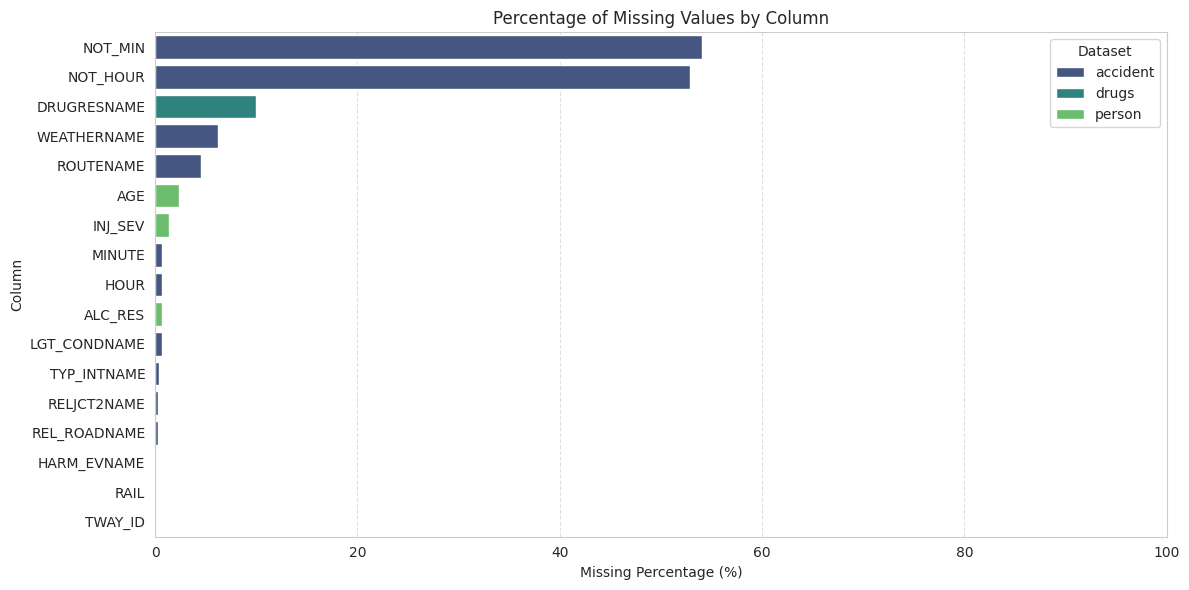


ANALYSIS FOR: ACCIDENT
Nullity Co-occurrence Score: 0.1253
-> Pattern: WEAK/MIXED


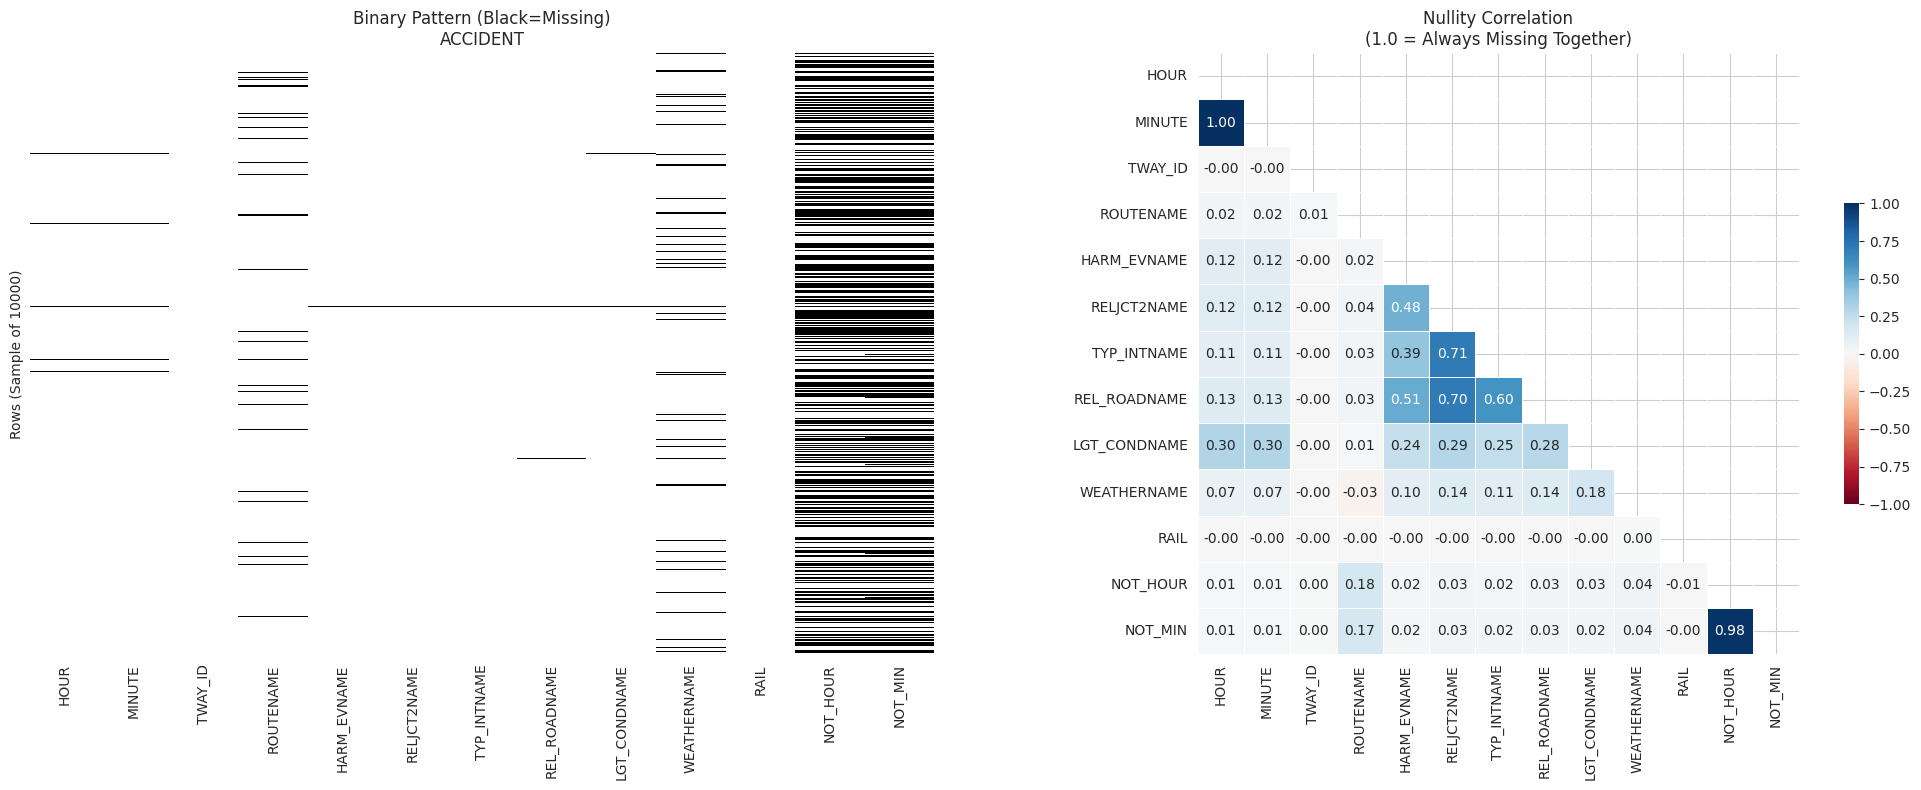


ANALYSIS FOR: PERSON
Nullity Co-occurrence Score: 0.1943
-> Pattern: WEAK/MIXED


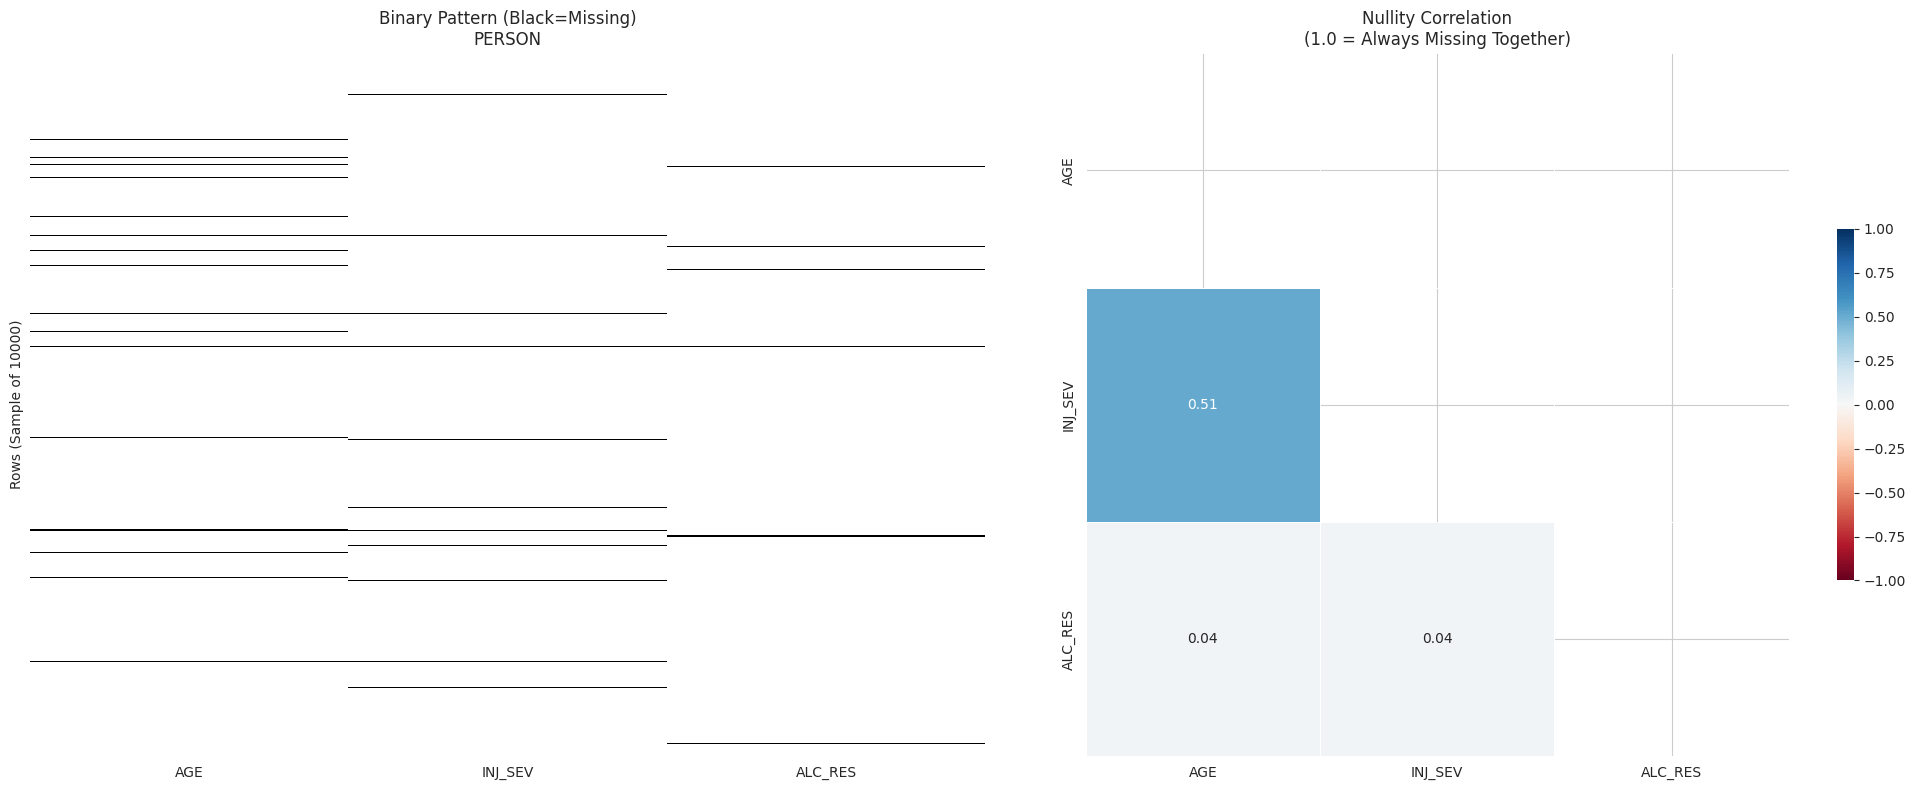

In [90]:
# --- Missing Value Analysis & Visualization ---

def calculate_nullity_score(df):
    """
    Calculates a single 'Co-occurrence Score' for a dataset.
    Returns the average correlation between missingness columns.
    """
    # Create a boolean dataframe (True where missing)
    nullity = df.isna()
    
    # Filter to columns that have *some* but not *all* missing values
    cols_varying = [col for col in df.columns if 0 < df[col].isna().sum() < len(df)]
    
    if len(cols_varying) < 2:
        return 0.0, pd.DataFrame() 
        
    # Calculate correlation matrix of the boolean dataframe
    corr_matrix = nullity[cols_varying].corr()
    
    # Calculate average correlation (excluding diagonal)
    mask = np.ones_like(corr_matrix, dtype=bool)
    np.fill_diagonal(mask, False)
    avg_score = corr_matrix.where(mask).abs().mean().mean()
    
    return avg_score, corr_matrix

def plot_missing_analysis(summary_df, data_dict):
    if summary_df.empty:
        print("No missing data to plot.")
        return

    # --- Plot 1: Percentage of Missing Values by Column ---
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=summary_df, 
        x='Missing_Percentage', 
        y='Column', 
        hue='Dataset', 
        dodge=False, 
        palette='viridis'
    )
    plt.title('Percentage of Missing Values by Column')
    plt.xlabel('Missing Percentage (%)')
    plt.xlim(0, 100)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.legend(title='Dataset')
    plt.tight_layout()
    plt.show()

    # --- Analyze Nullity Patterns per Dataset ---
    datasets_with_missing = summary_df['Dataset'].unique()

    for name in datasets_with_missing:
        df = data_dict[name]
        
        score, corr_matrix = calculate_nullity_score(df)
        
        if corr_matrix.empty:
            continue

        print(f"\n{'='*60}")
        print(f"ANALYSIS FOR: {name.upper()}")
        print(f"Nullity Co-occurrence Score: {score:.4f}")
        if score > 0.5:
            print("-> Pattern: SYSTEMATIC (Missing values tend to occur together in the same rows)")
        elif score < 0.1:
            print("-> Pattern: RANDOM (Missing values are scattered randomly)")
        else:
            print("-> Pattern: WEAK/MIXED")
        print(f"{'='*60}")

        fig, axes = plt.subplots(1, 2, figsize=(20, 8))
        
        # Plot 2: Binary Nullity Matrix
        sample_df = df[corr_matrix.columns].sample(min(len(df), 10000), random_state=42)
        sns.heatmap(sample_df.isna(), cbar=False, cmap='binary', yticklabels=False, ax=axes[0])
        axes[0].set_title(f'Binary Pattern (Black=Missing)\n{name.upper()}')
        axes[0].set_ylabel(f'Rows (Sample of {len(sample_df)})')
        
        # Plot 3: Nullity Correlation Heatmap
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        sns.heatmap(
            corr_matrix, 
            mask=mask,
            cmap='RdBu', 
            vmax=1, 
            vmin=-1, 
            center=0,
            annot=True, 
            fmt='.2f',
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .5},
            ax=axes[1]
        )
        axes[1].set_title('Nullity Correlation\n(1.0 = Always Missing Together)')
        plt.tight_layout()
        plt.show()

# Create combined dataframes for analysis (concatenating years)
combined_fars_data = {}
for data_type in SELECTED_DATA:
    dfs = []
    for year in available_years:
        if data_type in fars_data[year]:
            dfs.append(fars_data[year][data_type])
    if dfs:
        combined_fars_data[data_type] = pd.concat(dfs, ignore_index=True)

# Generate Summary DataFrame
missing_rows = []
for dataset_name, df in combined_fars_data.items():
    missing_series = df.isna().sum()
    missing_series = missing_series[missing_series > 0]
    for col, count in missing_series.items():
        total_rows = len(df)
        missing_rows.append({
            'Dataset': dataset_name,
            'Column': col,
            'Missing_Count': count,
            'Missing_Percentage': (count / total_rows) * 100
        })

missing = pd.DataFrame(missing_rows)
if not missing.empty:
    missing = missing.sort_values('Missing_Percentage', ascending=False)

# Print Stats
total_cols_checked = sum([len(df.columns) for df in combined_fars_data.values()])
print(f"Columns with missing values: {len(missing)} out of {total_cols_checked}")
print("\nColumns with missing data:")
display(missing)

# Run Visualization
plot_missing_analysis(missing, combined_fars_data)


---

## 3. Merging Datasets across Years and Data Types

In [91]:
INTERIM_DIR = Path("data/interim")
rel_interim = rel_path(INTERIM_DIR)
INTERIM_DIR.mkdir(parents=True, exist_ok=True)

# Storage for the final merged dataframes
merged_fars = {}

print("Merging Data Across Years")

# 1. Standard Merging Loop
for data_type, columns in SELECTED_COLS.items():
    dfs_to_merge = []
    
    # Iterate through available years in chronological order
    for year in sorted(fars_data.keys()):
        # Check if this specific data type exists for this year
        if data_type in fars_data[year]:
            original_df = fars_data[year][data_type]
            
            # Filter: Keep only selected columns
            temp_df = original_df[columns].copy()
            
            # Ensure YEAR column exists for safe merging later
            if 'YEAR' not in temp_df.columns:
                temp_df['YEAR'] = year
            
            dfs_to_merge.append(temp_df)
    
    # Concatenate all years for this data type
    if dfs_to_merge:
        merged_fars[data_type] = pd.concat(dfs_to_merge, ignore_index=True)
        
        # Print summary
        num_cols = merged_fars[data_type].shape[1]
        count = len(merged_fars[data_type])
        years_present = merged_fars[data_type]['YEAR'].unique()
        print(f"- Created 'merged_fars['{data_type}']' dataframe ({num_cols} columns x {count:,} rows).")
    else:
        print(f"⚠️ No data found to merge for {data_type}")


Merging Data Across Years
- Created 'merged_fars['accident']' dataframe (36 columns x 105,060 rows).
- Created 'merged_fars['drugs']' dataframe (4 columns x 327,625 rows).
- Created 'merged_fars['person']' dataframe (7 columns x 259,587 rows).


### 3.1. Understand the age distribution

We will analyze the age distribution of individuals involved in fatal accidents to identify patterns or trends that may be relevant to our study.

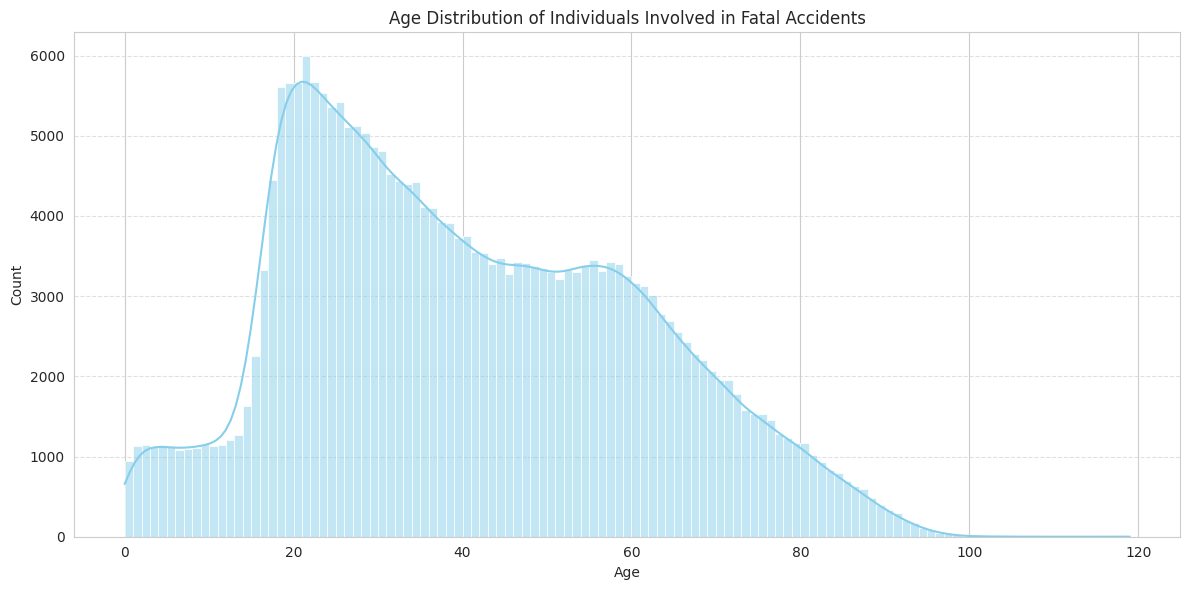

Number of people with age above 120: 0


In [93]:
persons = merged_fars['person']

#plot age distribution
plt.figure(figsize=(12, 6))
sns.histplot(persons['AGE'].dropna(), bins=range(0, 100, 1), kde=True, color='skyblue')
plt.title('Age Distribution of Individuals Involved in Fatal Accidents')
plt.xlabel('Age')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print("Number of people with age above 120:", persons[persons['AGE'] > 120].shape[0])

Instead of relying on arbitrary age bins, the following steps were taken to create meaningful age features:

* **Optimal Cluster Determination:** The **Gaussian Mixture Model (GMM)** is applied to the non-missing `AGE` data, and the optimal number of clusters is determined using the **Bayesian Information Criterion (BIC)** score.
* **Age Group Features:** For the optimal number of clusters ($N$), $N$ binary features are created (e.g., `AGE_GROUP_0_to_12`), indicating the demographic cluster a crash is associated with.


### 3.2. Merging Age Group Features into joined Dataset


--- Calculating Derived Columns: TOTAL_HARM, INTOXICATION TARGETS, & AGE GROUPS ---

  > Performing GMM Age Clustering...
    - Optimal Age Groups: 7 (BIC: 2214005)

  > GMM Age Group Summary:



  > Intoxication Target Distribution (Accident Level):
    - ALC_USE:
      0 (No ):  86,947 ( 82.8%)
      1 (Yes):  18,113 ( 17.2%)
    - DRUG_USE:
      0 (No ):  50,981 ( 48.5%)
      1 (Yes):  54,079 ( 51.5%)
    - DRUG_&_ALC:
      0 (No ):  91,998 ( 87.6%)
      1 (Yes):  13,062 ( 12.4%)
    - DRUG_OR_ALC:
      0 (No ):  45,930 ( 43.7%)
      1 (Yes):  59,130 ( 56.3%)

Successfully added 'TOTAL_HARM', 4 Intoxication Targets (ALC_USE, DRUG_USE, DRUG_&_ALC, DRUG_OR_ALC)
 for drivers only, and 7 Age Groups.


ST_CASE  YEAR  TOTAL_HARM  ALC_USE  DRUG_USE  DRUG_&_ALC  DRUG_OR_ALC  \
0    10001  2018           4        0         1           0            1   
1    10002  2018           8        0         0           0            0   
2    10003  2018           6        0         1           0            1   
3    10004  2018           4        0         1           0            1   
4    10005  2018           6        0         0           0            0   

   AGE_GROUP_0_to_12  AGE_GROUP_13_to_27  AGE_GROUP_28_to_39  \
0                  0                   0                   0   
1                  0                   2                   0   
2                  0                   0                   2   
3                  0                   1                   0   
4                  0                   0                   1   

   AGE_GROUP_40_to_50  AGE_GROUP_51_to_60  AGE_GROUP_61_to_73  \
0                   0                   1                   0   
1                   0                   0                   0   
2                   0                   0                   0   
3                   0                   1                   0   
4                   1                   0                   0   

   AGE_GROUP_74_to_119  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0

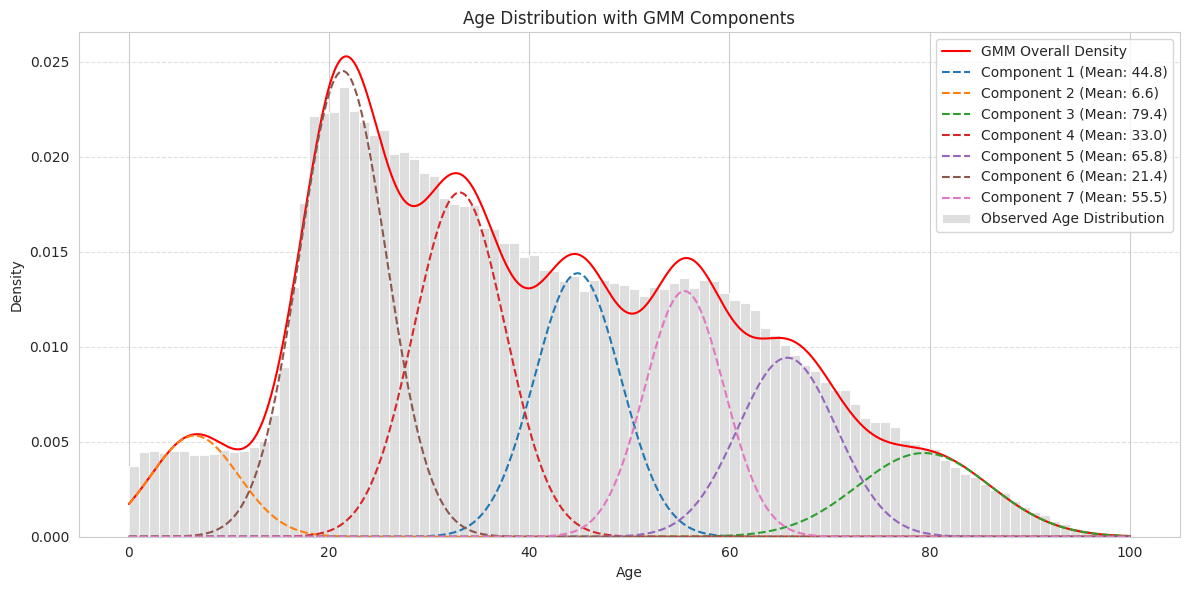

In [ ]:
# 2. Calculate New Columns (Vectorized Approach)
# We apply this logic only if we have the necessary datasets
if all(k in merged_fars for k in ['accident', 'person', 'drugs']):
    print("\n--- Calculating Derived Columns: TOTAL_HARM, INTOXICATION TARGETS, & AGE GROUPS ---\n")
    
    joined_data = merged_fars['accident'].copy()
    per_df = merged_fars['person'].copy()
    drg_df = merged_fars['drugs'].copy()
    
    # Define keys for joining
    join_keys = ['ST_CASE', 'YEAR']
    
    # ==============================================================================
    # 1. AGE GROUP CLUSTERING (GMM)
    # ==============================================================================
    print("  > Performing GMM Age Clustering...")
    
    # Ensure AGE is numeric
    per_df['AGE'] = pd.to_numeric(per_df['AGE'], errors='coerce')
    
    # Extract non-null ages for fitting
    age_non_null = per_df['AGE'].dropna().values.reshape(-1, 1)
    
    # Find optimal clusters (BIC)
    bic_max_components = 7 # Max number of clusters to try
    best_bic = np.inf
    best_n = 2
    best_gmm = None
    
    for n in range(2, bic_max_components + 1):
        gmm_temp = GaussianMixture(n_components=n, random_state=42)
        gmm_temp.fit(age_non_null)
        bic = gmm_temp.bic(age_non_null)
        if bic < best_bic:
            best_bic = bic
            best_n = n
            best_gmm = gmm_temp
            
    print(f"    - Optimal Age Groups: {best_n} (BIC: {best_bic:.0f})")
    
    # Predict clusters for all persons (handling NaNs)
    # We only predict for rows where AGE is not null
    valid_age_mask = per_df['AGE'].notna()
    per_df.loc[valid_age_mask, 'AGE_CLUSTER_LABEL'] = best_gmm.predict(per_df.loc[valid_age_mask, 'AGE'].values.reshape(-1, 1))
    
    # Sort clusters by mean age to make them intuitive (0=Youngest, N=Oldest)
    cluster_means = per_df.groupby('AGE_CLUSTER_LABEL')['AGE'].mean().sort_values()
    remap_dict = {old_label: new_label for new_label, old_label in enumerate(cluster_means.index)}
    per_df['AGE_GROUP_SORTED'] = per_df['AGE_CLUSTER_LABEL'].map(remap_dict)
    
    # Create Binary Columns for each Group
    age_group_cols = []
    gmm_summary_data = []
    
    # Get GMM parameters for summary (mapped to sorted indices)
    # Note: best_gmm.means_ are not sorted by value, so we need to map them 
    # carefully if we want exact model params.
    # However, for the report, the empirical min/max/mean from the data assigned 
    # to that cluster is often more descriptive.
    
    for i in range(best_n):
        # Determine bounds for naming
        subset = per_df[per_df['AGE_GROUP_SORTED'] == i]
        
        if not subset.empty:
            min_age = int(subset['AGE'].min())
            max_age = int(subset['AGE'].max())
            mean_age = subset['AGE'].mean()
            std_age = subset['AGE'].std()
            count = len(subset)
            prop = count / len(per_df) * 100
            
            col_name = f"AGE_GROUP_{min_age}_to_{max_age}"
            
            gmm_summary_data.append({
                'Group': i,
                'Age Range': f"{min_age}-{max_age}",
                'Mean Age': mean_age,
                'Std Dev': std_age,
                'Count': count,
                'Proportion (%)': prop
            })
        else:
            col_name = f"AGE_GROUP_{i}_EMPTY"
            gmm_summary_data.append({
                'Group': i,
                'Age Range': "Empty",
                'Mean Age': np.nan,
                'Std Dev': np.nan,
                'Count': 0,
                'Proportion (%)': 0.0
            })
            
        # Create binary flag: 1 if person belongs to this group, 0 otherwise
        per_df[col_name] = (per_df['AGE_GROUP_SORTED'] == i).astype(int)
        age_group_cols.append(col_name)

    # Display Summary DataFrame
    gmm_summary_df = pd.DataFrame(gmm_summary_data)
    print("\n  > GMM Age Group Summary:")
    display(gmm_summary_df.style.format({
        'Mean Age': '{:.1f}',
        'Std Dev': '{:.2f}',
        'Count': '{:,}',
        'Proportion (%)': '{:.1f}%'
    }))

    # Aggregate Age Groups per Accident (Sum of people in that age group per crash)
    age_agg = per_df.groupby(join_keys)[age_group_cols].sum().reset_index()


    # ==============================================================================
    # 2. TOTAL_HARM CALCULATION
    # ==============================================================================
    # Logic: Sum of INJ_SEV <= 4. If INJ_SEV == 5 (Unknown Inj), add 1.
    
    per_df['INJ_SEV'] = pd.to_numeric(per_df['INJ_SEV'], errors='coerce').fillna(0)
    
    per_df['calc_harm'] = 0
    mask_sev = per_df['INJ_SEV'] <= 4
    mask_unk = per_df['INJ_SEV'] == 5
    
    per_df.loc[mask_sev, 'calc_harm'] = per_df.loc[mask_sev, 'INJ_SEV']
    per_df.loc[mask_unk, 'calc_harm'] = 1
    
    harm_series = per_df.groupby(join_keys)['calc_harm'].sum().rename('TOTAL_HARM')
    
    # ==============================================================================
    # 3. INTOXICATION TARGETS CALCULATION (drivers only)
    # ==============================================================================
    # Targets: ALC_USE, DRUG_USE, DRUG_&_ALC, DRUG_OR_ALC
    
    # Identify Drivers
    drivers = per_df[per_df['PER_TYP'] == 1].copy()
    
    # --- A. Alcohol (ALC_USE) ---
    # Logic: Driver with ALC_RES > 0.08 (recorded as > 80 in FARS)
    drivers['ALC_RES'] = pd.to_numeric(drivers['ALC_RES'], errors='coerce').fillna(0)
    mask_drunk = (drivers['ALC_RES'] > 80) & (drivers['ALC_RES'] < 995)
    # 0.080% is the legal limit in all states, some states have additional punishments
    # for certain higher values. Special values are assumed to be none
    
    alc_cases = drivers.loc[mask_drunk, join_keys].drop_duplicates()
    alc_cases['ALC_USE'] = 1
    
    # --- B. Drugs (DRUG_USE) ---
    # Logic: Driver with positive drug test result
    excluded_results = [None, 'Test Not Given', 'None Detected/Below Threshold']
    positive_drugs = drg_df[
        drg_df['DRUGRESNAME'].notna() & 
        (~drg_df['DRUGRESNAME'].isin(excluded_results))
    ].copy()
    
    drugged_drivers = pd.merge(
        drivers[join_keys + ['PER_NO']], 
        positive_drugs, 
        on=join_keys + ['PER_NO'], 
        how='inner'
    )
    drug_cases = drugged_drivers[join_keys].drop_duplicates()
    drug_cases['DRUG_USE'] = 1
    
    # --- C. Merge Targets ---
    # We merge these into a temporary targets dataframe
    targets_df = pd.merge(alc_cases, drug_cases, on=join_keys, how='outer')
    targets_df['ALC_USE'] = targets_df['ALC_USE'].fillna(0).astype(int)
    targets_df['DRUG_USE'] = targets_df['DRUG_USE'].fillna(0).astype(int)
    
    # --- D. Calculate Combinations ---
    targets_df['DRUG_&_ALC'] = (targets_df['ALC_USE'] & targets_df['DRUG_USE']).astype(int)
    targets_df['DRUG_OR_ALC'] = (targets_df['ALC_USE'] | targets_df['DRUG_USE']).astype(int)
    
    # ==============================================================================
    # 4. MERGE EVERYTHING BACK TO ACCIDENT DATA
    # ==============================================================================
    joined_data = pd.merge(joined_data, harm_series, on=join_keys, how='left')
    joined_data = pd.merge(joined_data, targets_df, on=join_keys, how='left') # Merge Targets
    joined_data = pd.merge(joined_data, age_agg, on=join_keys, how='left') # Merge Age Groups
    
    # Fill Target NaNs with 0 (implies no intoxication found)
    target_cols = ['ALC_USE', 'DRUG_USE', 'DRUG_&_ALC', 'DRUG_OR_ALC']
    joined_data[target_cols] = joined_data[target_cols].fillna(0).astype(int)
    
    # Fill Age Group NaNs with 0 (implies no persons of that age in that crash)
    joined_data[age_group_cols] = joined_data[age_group_cols].fillna(0).astype(int)

    # Print Distribution of Targets
    print("\n  > Intoxication Target Distribution (Accident Level):")
    for col in target_cols:
        counts = joined_data[col].value_counts().sort_index()
        total = len(joined_data)
        print(f"    - {col}:")
        for val, count in counts.items():
            pct = (count / total) * 100
            label = "Yes" if val == 1 else "No "
            print(f"      {val} ({label}): {count:>7,} ({pct:>5.1f}%)")
    
    # Save the updated accident file
    file_path = INTERIM_DIR / "FARS_merged.csv"
    joined_data.to_csv(file_path, index=False)
    
    print(f"\nSuccessfully added 'TOTAL_HARM', {len(target_cols)} Intoxication Targets ({', '.join(target_cols)})\n for drivers only, and {len(age_group_cols)} Age Groups.")

    # Display columns to verify
    cols_to_show = ['ST_CASE', 'YEAR', 'TOTAL_HARM'] + target_cols + age_group_cols
    display(joined_data[cols_to_show].head())
    
    def plot_age_distribution_with_gmm(age_data, gmm_model):
        """
        Plots the age distribution with GMM components overlaid.
        """
        plt.figure(figsize=(12, 6))
        
        # Plot histogram of ages
        sns.histplot(age_data, bins=range(0, 100, 1), kde=False, color='lightgray', stat='density', label='Observed Age Distribution')
        
        # Generate age range for GMM plotting
        x = np.linspace(0, 100, 1000).reshape(-1, 1)
        
        # Calculate GMM PDF
        logprob = gmm_model.score_samples(x)
        pdf = np.exp(logprob)
        
        # Plot GMM overall density
        plt.plot(x, pdf, '-r', label='GMM Overall Density')
        
        # Plot individual GMM components
        for i in range(gmm_model.n_components):
            mean = gmm_model.means_[i][0]
            variance = gmm_model.covariances_[i][0][0]
            weight = gmm_model.weights_[i]
            component_pdf = weight * norm.pdf(x, mean, np.sqrt(variance))
            plt.plot(x, component_pdf, '--', label=f'Component {i+1} (Mean: {mean:.1f})')
        
        plt.title('Age Distribution with GMM Components')
        plt.xlabel('Age')
        plt.ylabel('Density')
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

    # Plot the age distribution with GMM components
    plot_age_distribution_with_gmm(per_df['AGE'].dropna(), best_gmm)

In [99]:
# --- Result Access ---
# You now have:
# display(merged_fars['accident'].head(2))
# display(merged_fars['person'].head(2))
# merged_fars['drugs']

## 4. Geographic Coverage

In [26]:
# State distribution
state_counts = joined_data['STATENAME'].value_counts().head(15)
print("Top 15 States by fatal accident Count:")
print("=" * 40)
for state, count in state_counts.items():
    pct = (count / len(joined_data)) * 100
    print(f"{state:15s} {count:>10,}  ({pct:5.2f}%)")

Top 15 States by fatal accident Count:
California          10,639  (10.13%)
Texas               10,481  ( 9.98%)
Florida              9,052  ( 8.62%)
Georgia              4,277  ( 4.07%)
North Carolina       4,128  ( 3.93%)
Tennessee            3,233  ( 3.08%)
Pennsylvania         3,226  ( 3.07%)
Ohio                 3,185  ( 3.03%)
Illinois             3,032  ( 2.89%)
Arizona              3,021  ( 2.88%)
South Carolina       2,872  ( 2.73%)
Michigan             2,830  ( 2.69%)
New York             2,822  ( 2.69%)
Alabama              2,625  ( 2.50%)
Missouri             2,572  ( 2.45%)


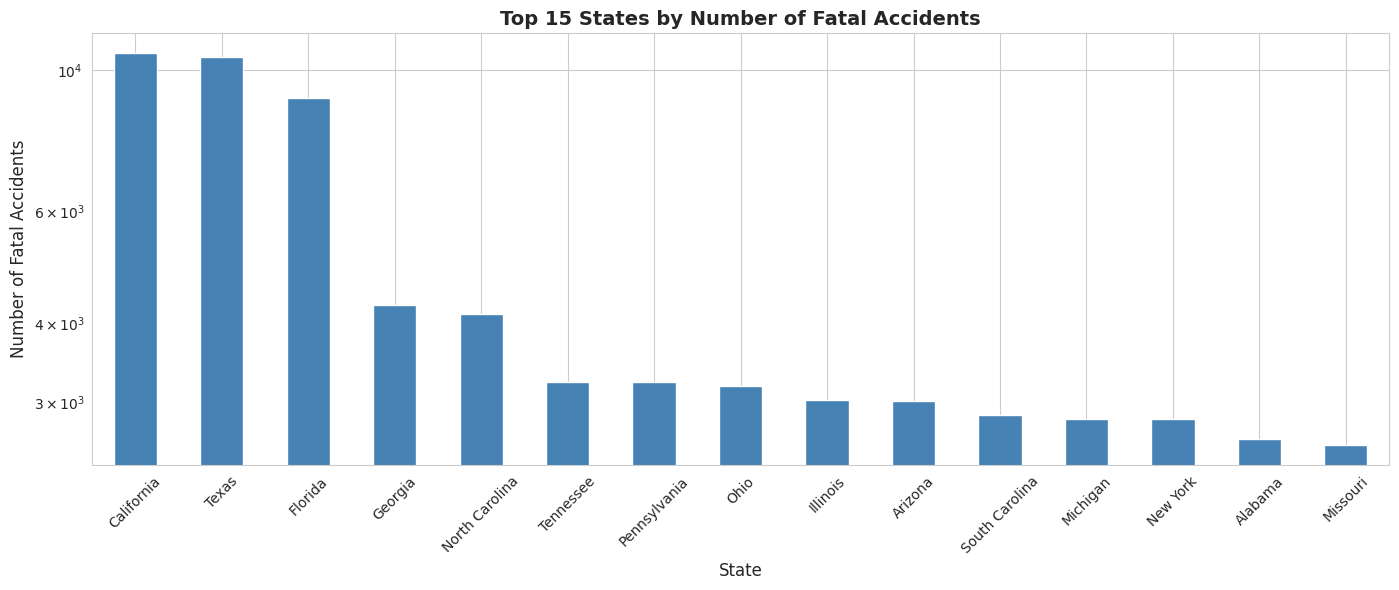

In [28]:
# Visualize state distribution
fig, ax = plt.subplots(figsize=(14, 6))
state_counts.plot(kind='bar', ax=ax, color='steelblue')
ax.set_title('Top 15 States by Number of Fatal Accidents', fontsize=14, fontweight='bold')
ax.set_xlabel('State', fontsize=12)
ax.set_ylabel('Number of Fatal Accidents', fontsize=12)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{float(x/1000)}K'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.yscale('log')
plt.show()

## 5. Temporal Patterns

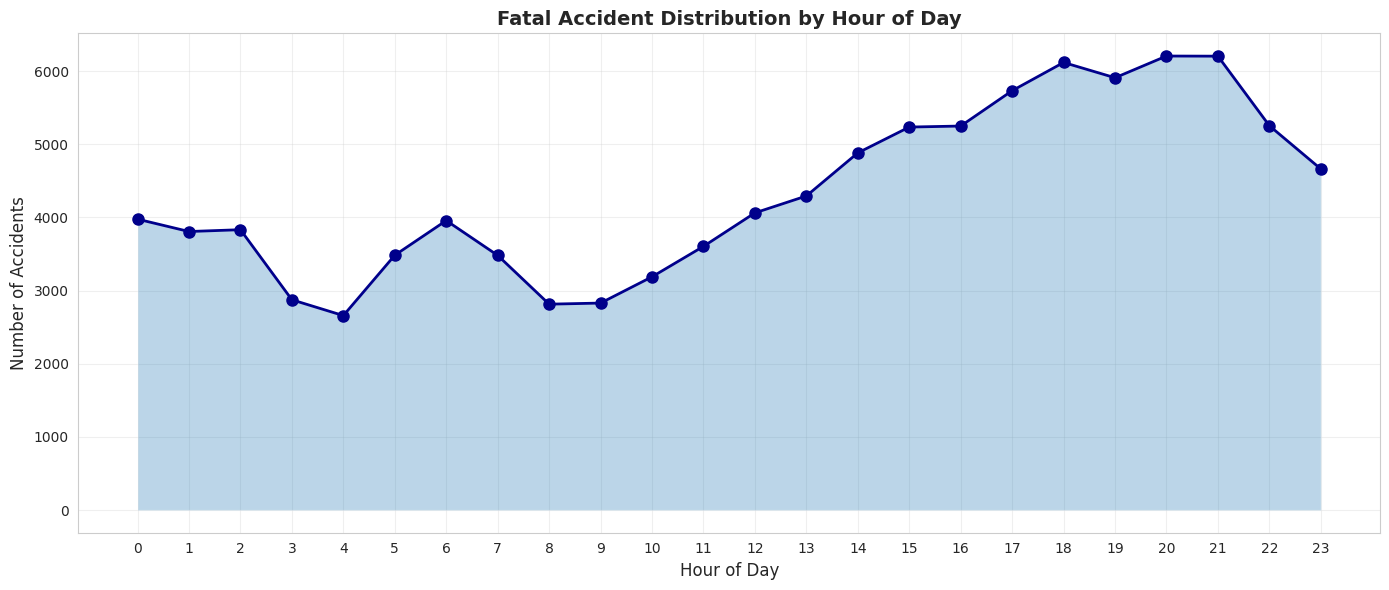

In [ ]:
# Accidents by hour of day overall
hour_counts = joined_data['HOUR'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(hour_counts.index, hour_counts.values, marker='o', linewidth=2, markersize=8, color='darkblue')
ax.fill_between(hour_counts.index, hour_counts.values, alpha=0.3)
ax.set_title('Fatal Accident Distribution by Hour of Day', fontsize=14, fontweight='bold')
ax.set_xlabel('Hour of Day', fontsize=12)
ax.set_ylabel('Number of Accidents', fontsize=12)
ax.grid(True, alpha=0.3)
ax.set_xticks(range(0, 24))
plt.tight_layout()
plt.show()

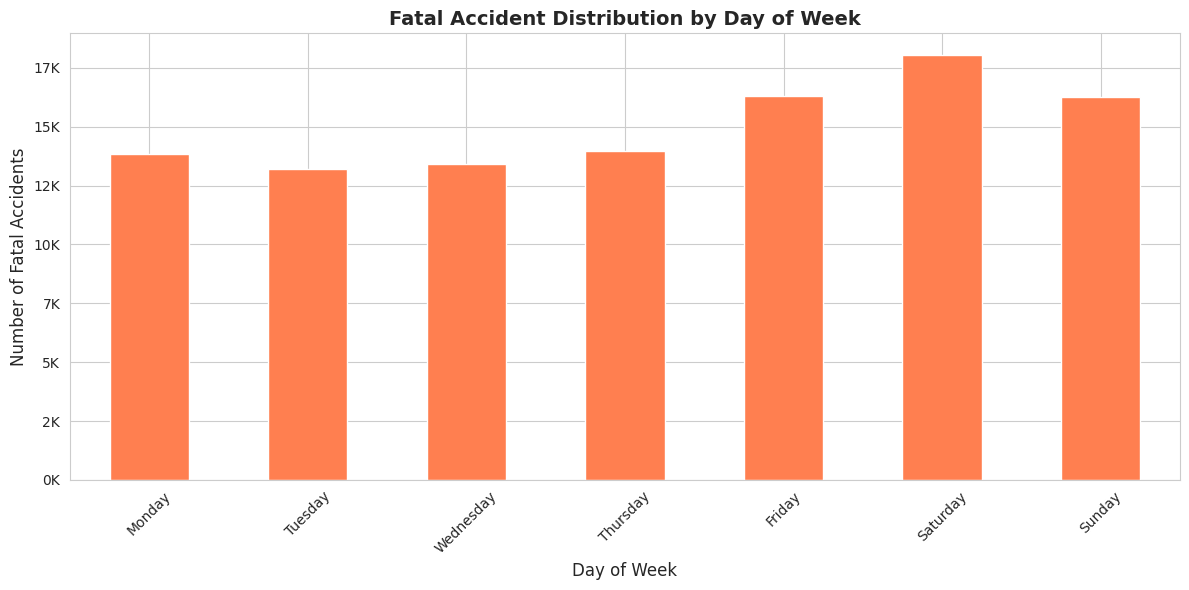

In [30]:
# Accidents by day of week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = joined_data['DAY_WEEKNAME'].value_counts().reindex(day_order)

fig, ax = plt.subplots(figsize=(12, 6))
day_counts.plot(kind='bar', ax=ax, color='coral')
ax.set_title('Fatal Accident Distribution by Day of Week', fontsize=14, fontweight='bold')
ax.set_xlabel('Day of Week', fontsize=12)
ax.set_ylabel('Number of Fatal Accidents', fontsize=12)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{int(x/1000)}K'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Observation:** The weekend has a higher number of fatal accidents compared to working days, let's dive into the hourly distribution on weekends to see why

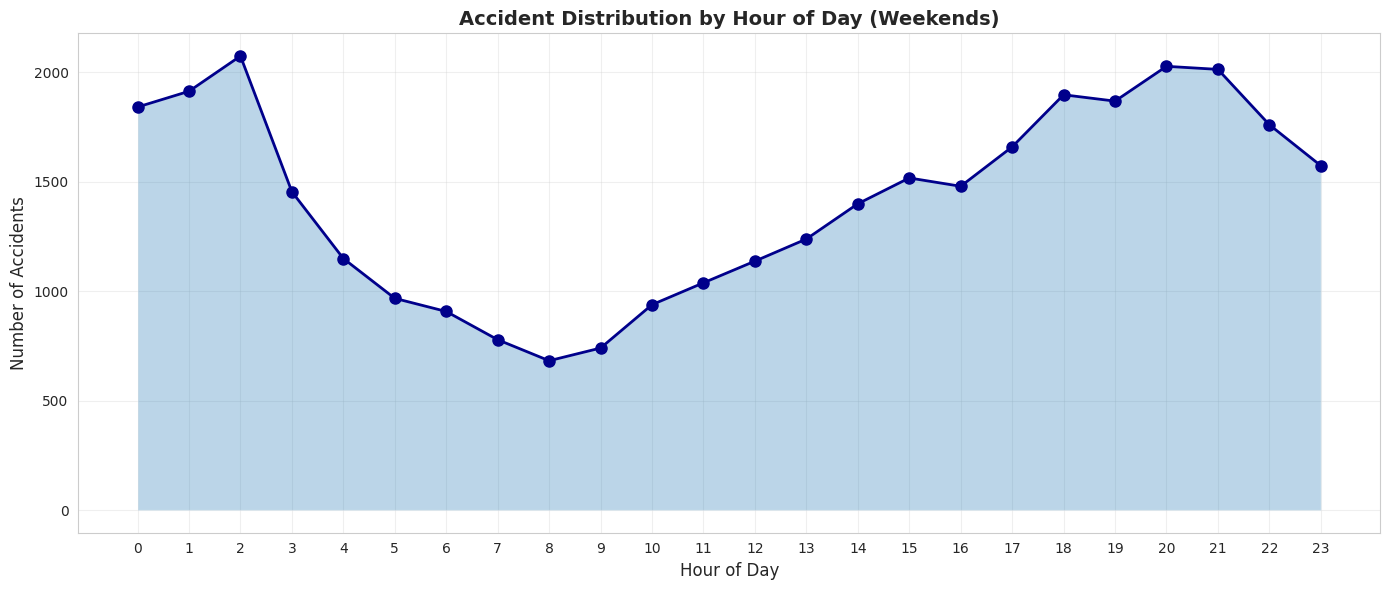


Top 10 Peak Hours for Accidents:

At 02h: 2,074 accidents (3.04x minimum)
At 20h: 2,027 accidents (2.97x minimum)
At 21h: 2,013 accidents (2.95x minimum)
At 01h: 1,913 accidents (2.80x minimum)
At 18h: 1,897 accidents (2.78x minimum)
At 19h: 1,868 accidents (2.74x minimum)
At 00h: 1,841 accidents (2.70x minimum)
At 22h: 1,760 accidents (2.58x minimum)
At 17h: 1,659 accidents (2.43x minimum)
At 23h: 1,573 accidents (2.31x minimum)

Minimum Accidents in a Single Hour (weekends): 682 accidents


In [31]:
# Accidents by hour of day on weekends
hour_counts = joined_data[joined_data['DAY_WEEKNAME'].isin(['Saturday', 'Sunday'])]['HOUR'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(hour_counts.index, hour_counts.values, marker='o', linewidth=2, markersize=8, color='darkblue')
ax.fill_between(hour_counts.index, hour_counts.values, alpha=0.3)
ax.set_title('Accident Distribution by Hour of Day (Weekends)', fontsize=14, fontweight='bold')
ax.set_xlabel('Hour of Day', fontsize=12)
ax.set_ylabel('Number of Accidents', fontsize=12)
ax.grid(True, alpha=0.3)
ax.set_xticks(range(0, 24))
plt.tight_layout()
plt.show()

# Identify the peak hours for accidents

min_accidents = hour_counts.min()
peak_hours = hour_counts.sort_values(ascending=False).head(10)

print("\nTop 10 Peak Hours for Accidents:\n")
for hour, count in peak_hours.items():
    print(f"At {int(hour):02d}h: {count:,} accidents ({count/min_accidents:.2f}x minimum)")  

print(f"\nMinimum Accidents in a Single Hour (weekends): {min_accidents:,} accidents")

**Observation:** The rush hour patterns are less pronounced on weekends compared to weekdays. While there are still peaks in accident counts during late morning and early afternoon hours, the overall distribution is more uniform throughout the day. This suggests that weekend traffic is less influenced by traditional work commute times, leading to a more even spread of accidents across different hours.

## 6. Severity Distribution

In [40]:
# Impairment %

impairment_counts = joined_data['INTOXICATED_DRIVER_INVOLVED'].value_counts().sort_index()

print("Impairment %:")
print("=" * 50)
print("Impairment | Count    | Percentage")
print("-" * 50)
for sev, count in impairment_counts.items():
    pct = (count / len(joined_data)) * 100
    print(f"  {sev:<8} | {count:<8,} | {pct:>6.2f}%")

print("\nNote: Severity levels 4+, sum of all casualties in each fatal accident (1 = Possible injury, 2 = Suspected minor injury, 3 = Suspected serious injury, 4 = fatality)")


Impairment %:
Impairment | Count    | Percentage
--------------------------------------------------
  0        | 45,930   |  43.72%
  1        | 59,130   |  56.28%

Note: Severity levels 4+, sum of all casualties in each fatal accident (1 = Possible injury, 2 = Suspected minor injury, 3 = Suspected serious injury, 4 = fatality)


In [45]:
# Severity distribution
severity_counts = joined_data['TOTAL_HARM'].value_counts().sort_index()

print("Accident Severity Distribution:")
print("=" * 50)
print("Level  | Count    | Percentage")
print("-" * 50)
for sev, count in severity_counts.items():
    pct = (count / len(joined_data)) * 100
    print(f"  {sev:<4} | {count:>8,} | {pct:>6.2f}%")

print("\nNote: Severity levels 4+, sum of all casualties in each fatal accident (1 = Possible injury, 2 = Suspected minor injury, 3 = Suspected serious injury, 4 = fatality)")

Accident Severity Distribution:
Level  | Count    | Percentage
--------------------------------------------------
  4    |   60,920 |  57.99%
  5    |    5,968 |   5.68%
  6    |    9,355 |   8.90%
  7    |    8,968 |   8.54%
  8    |    5,788 |   5.51%
  9    |    2,642 |   2.51%
  10   |    3,404 |   3.24%
  11   |    1,833 |   1.74%
  12   |    1,562 |   1.49%
  13   |    1,157 |   1.10%
  14   |      869 |   0.83%
  15   |      526 |   0.50%
  16   |      540 |   0.51%
  17   |      333 |   0.32%
  18   |      259 |   0.25%
  19   |      246 |   0.23%
  20   |      156 |   0.15%
  21   |      118 |   0.11%
  22   |       98 |   0.09%
  23   |       62 |   0.06%
  24   |       42 |   0.04%
  25   |       28 |   0.03%
  26   |       28 |   0.03%
  27   |       17 |   0.02%
  28   |       17 |   0.02%
  29   |       18 |   0.02%
  30   |       20 |   0.02%
  31   |       15 |   0.01%
  32   |        8 |   0.01%
  33   |        6 |   0.01%
  34   |        8 |   0.01%
  35   |        6 

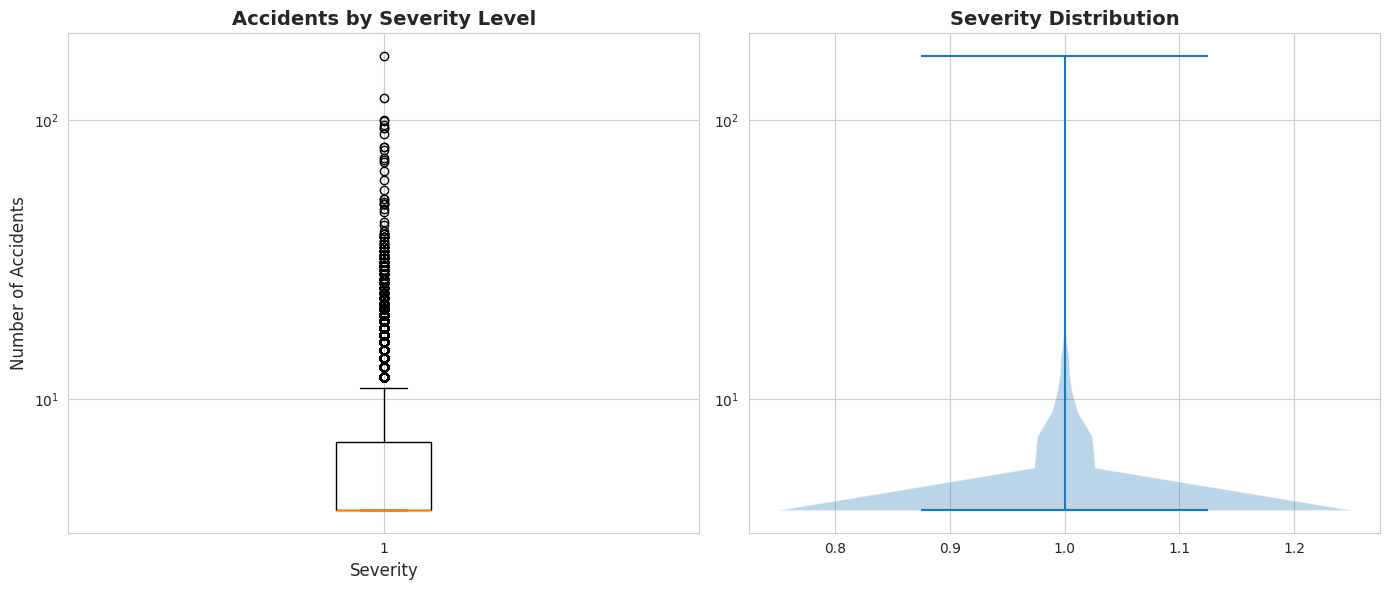

In [46]:
# Visualize severity distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Box plot
ax1.boxplot(joined_data['TOTAL_HARM'])
ax1.set_title('Accidents by Severity Level', fontsize=14, fontweight='bold')
ax1.semilogy()
ax1.set_xlabel('Severity', fontsize=12)
ax1.set_ylabel('Number of Accidents', fontsize=12)

# Violin plot
ax2.violinplot(joined_data['TOTAL_HARM'].astype(float), showmeans=False, showmedians=True)
ax2.set_title('Severity Distribution', fontsize=14, fontweight='bold')
ax2.semilogy()

plt.tight_layout()
plt.show()

## 7. Weather Conditions

In [47]:
# Top weather conditions
weather_counts = joined_data['WEATHERNAME'].value_counts().head(15)

print("Top 15 Weather Conditions:")
print("=" * 60)
for i, (weather, count) in enumerate(weather_counts.items(), 1):
    pct = (count / len(joined_data)) * 100
    print(f"{i:2d}. {weather:35s} {count:>8,}  ({pct:5.2f}%)")

Top 15 Weather Conditions:
 1. Clear                                 73,133  (69.61%)
 2. Cloudy                                14,668  (13.96%)
 3. Rain                                   8,016  ( 7.63%)
 4. Fog, Smog, Smoke                       1,115  ( 1.06%)
 5. Snow                                     945  ( 0.90%)
 6. Sleet or Hail                            157  ( 0.15%)
 7. Severe Crosswinds                        148  ( 0.14%)
 8. Other                                    105  ( 0.10%)
 9. Blowing Snow                              93  ( 0.09%)
10. Freezing Rain or Drizzle                  78  ( 0.07%)
11. Blowing Sand, Soil, Dirt                  28  ( 0.03%)


## 8. Key Findings Summary

In [50]:
print("="*80)
print("KEY FINDINGS - FARS DATASET (2023)")
print("="*80)

print("\n📊 DATASET SIZE:")
print(f"   • Total records: {len(joined_data):,} accidents")
print(f"   • Features: {len(joined_data.columns)}")
print(f"   • Memory usage: {joined_data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\n📍 GEOGRAPHIC COVERAGE:")
print(f"   • States: {joined_data['STATENAME'].nunique()}")
print(f"   • Top state: {joined_data['STATENAME'].value_counts().index[0]} ({joined_data['STATENAME'].value_counts().iloc[0]:,} accidents)")

print("\n🌤️ WEATHER CONDITIONS:")
print(f"   • Most common: {joined_data['WEATHERNAME'].value_counts().index[0]}")

print("\n⚠️ DATA QUALITY:")
print(f"   • Columns with missing data: {len(missing)} / {len(joined_data.columns)}")
print(f"   • Overall completeness: {(1 - joined_data.isnull().sum().sum() / (len(joined_data) * len(joined_data.columns))) * 100:.2f}%")

print("\n" + "="*80)

KEY FINDINGS - FARS DATASET (2023)

📊 DATASET SIZE:
   • Total records: 105,060 accidents
   • Features: 42
   • Memory usage: 111.13 MB

📍 GEOGRAPHIC COVERAGE:
   • States: 51
   • Top state: California (10,639 accidents)

🌤️ WEATHER CONDITIONS:
   • Most common: Clear

⚠️ DATA QUALITY:
   • Columns with missing data: 17 / 42
   • Overall completeness: 97.12%



## 9. Save preprocessed Dataset (checkpoint)

Lets save the dataset with modified data types and new features for quick testing in subsequent notebooks

In [ ]:
output_full_path = Config.FARS_CLEANED_DIR / "fars.csv"
joined_data.to_csv(output_full_path, index=False)

print("\nDataset saved with the following details:")
print(f"✓ Cleaned dataset saved to: {output_full_path}")


Dataset saved with the following details:
✓ Cleaned dataset saved to: c:\Users\aarthi\Documents\Uni\Y1\FDS\Project\US_accidents_project\data\processed\fars\fars.csv


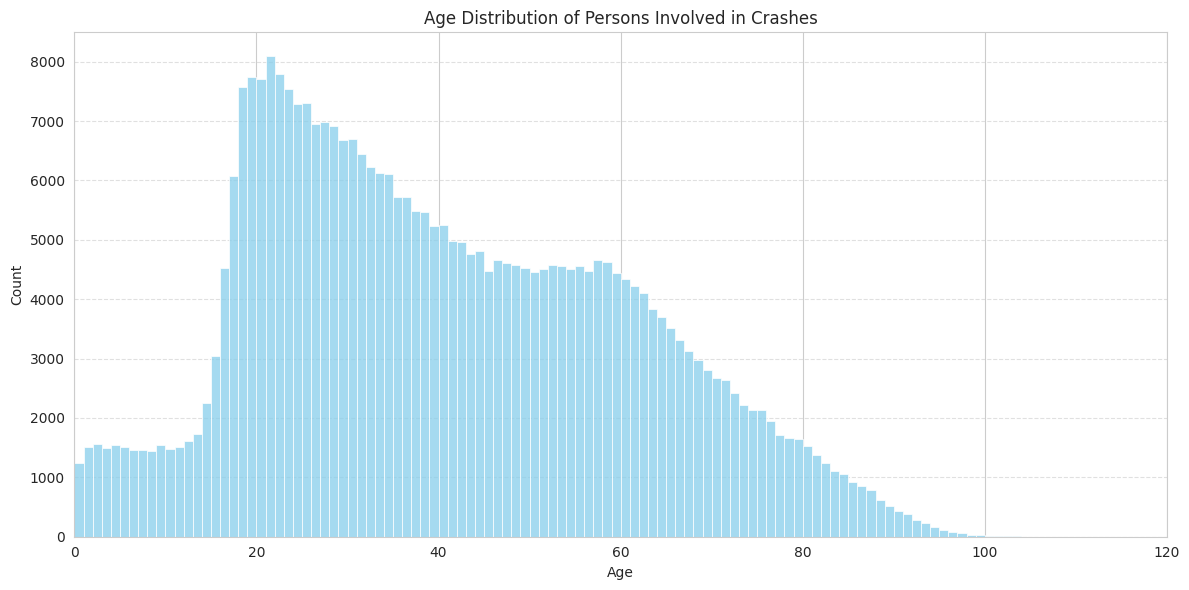

In [ ]:
# Age distribution in 'person' dataset

plt.figure(figsize=(12, 6))
sns.histplot(person_df['AGE'].dropna(), bins=range(0, 121, 1), kde=False, color='skyblue')
plt.title('Age Distribution of Persons Involved in Crashes')
plt.xlabel('Age')
plt.ylabel('Count')
plt.xlim(0, 120)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

**Observation:** This distribution resembles a mixture of Gaussian distributions, indicating diverse subgroups within the data.

In [27]:
drug_categories = {
        'DRUGRES' : [],
        'DRUGSPEC' : []
        }
for col in drug_categories.keys():
    drug_categories[col] = clean_data['drugs'][col].unique().tolist()

print("\n--- Unique Drug Categories ---")
for col, categories in drug_categories.items():
    print(f"\n{col}:")
    for cat in categories:
        print(f" - {cat}")


--- Unique Drug Categories ---

DRUGRES:
 - Negative
 - Stimulants
 - Depressants
 - Cannabinoids
 - Unknown
 - Narcotics
 - Hallucinogens
 - PCP/Dissoc
 - Inhalants/Steroids
 - Unmapped
 - Non-Psychoactive

DRUGSPEC:
 - Whole Blood
 - <NA>
 - Urine
 - Vitreous
 - Liver
 - Blood Plasma / Serum
 - Other Specimen
 - Blood Clot
 - Oral Fluids


In [28]:
# other categories in person dataset
person_categories = {
        'PER_TYP' : [],
        'SEAT_POS' : [],
        'LOCATION' : [],
        'INJ_SEV' : []
        }
for col in person_categories.keys():
    person_categories[col] = clean_data['person'][col].unique().tolist()
print("\n--- Unique Person Categories ---")
for col, categories in person_categories.items():
    print(f"\n{col}:")
    for cat in categories:
        print(f" - {cat}")


--- Unique Person Categories ---

PER_TYP:
 - Driver
 - Passenger
 - Pedestrian
 - Occupant (Not In-Transport)
 - Bicyclist
 - Unknown/Other
 - In/On Building
 - Non-Motor Device
 - Other Cyclist/Conveyance

SEAT_POS:
 - Front Seat, Left Side
 - Front Seat, Right Side
 - Not a Motor Vehicle Occupant
 - Second Seat, Left Side
 - Second Seat, Right Side
 - <NA>
 - Second Seat, Middle
 - Sleeper Section of Cab (Truck)
 - Front Seat, Middle
 - Other Passenger in enclosed passenger or cargo area
 - Third Seat, Right Side
 - Riding on Exterior of Vehicle
 - Third Seat, Left Side
 - Third Seat, Middle
 - Other Passenger in unenclosed passenger or cargo area
 - Second Seat, Unknown
 - Third Seat, Unknown
 - Fourth Seat, Left Side
 - Fourth Seat, Right Side
 - Second Seat, Other
 - Trailing Unit
 - Third Seat, Other
 - Other Passenger in passenger or cargo area, unknown whether or not enclosed
 - Fourth Seat, Middle
 - Front Seat, Unknown
 - Front Seat, Other
 - Fourth Seat, Other
 - Appended 


### 3.2. Handling Missing Data and Feature Engineering

---

#### Missing Data Handling Strategy

The strategy for handling missing values is layered, prioritizing **predictive imputation** for critical features and **simple mode/mean imputation** for other variables, ensuring minimal loss of information and compatibility with scikit-learn models.

* **Smart Imputation (Predictive Modeling):**
    * **Light Condition (`LGT_COND`):** Missing `LGT_COND` values are imputed using a **Random Forest Classifier**. The model uses known categorical variables like `STATE`, `HOUR`, `MONTH`, and periodic time features (`DAYOFWEEK_COS`, `DAYOFYEAR_SIN`) to predict the most probable light condition (e.g., *Daylight* vs. *Dark - Not Lighted*). This preserves complex relationships between time, location, and light.
* **Probabilistic Imputation (Clustering):**
    * **Age (`AGE`):** Missing age values are imputed using the fitted **Gaussian Mixture Model (GMM)**, which has already determined the optimal age clusters (e.g., young, middle-aged, elderly). This **probabilistic imputation** ensures the synthetic ages adhere to the observed multimodal distribution of drivers, which is critical for accurate demographic representation.
* **Simple Imputation (Mode):**
    * **Categorical Features:** The remaining categorical features in the `accident` and `person` tables (e.g., `WEATHER`, `RUR_URB`, `SEX`) are imputed using the **most frequent value (mode)** via the `SimpleImputer`.
* **Coercion and Default Filling:**
    * All numeric `NaN` values created during the merge (where a crash had no corresponding person or drug records) are filled with **zero (0)**.

---

#### Feature Engineering

Feature engineering focuses on extracting non-redundant insights from the crash data, particularly by generating new metrics from the `person` and `drugs` datasets for crash-level aggregation.

##### 1. Harmonic Time Features

To capture seasonality and time-of-day cycles without linearizing circular data, **sine and cosine transformations** were applied to `HOUR`, `MONTH`, `DAYOFWEEK`, and `DAYOFYEAR`. This results in features like $\text{HOUR\_SIN}$ and $\text{HOUR\_COS}$, which are vital predictors of accident risk. 

[Image of sine and cosine transformation on a circle]


##### 2. Impairment Targets and Flags (ALC/DRUG)

Three final integer target flags are created at the crash level (`ST_CASE`):

* **`CRASH_ALC_FLAG`**: A flag indicating whether any person in the crash had a positive alcohol result (`ALC_RES` > 0). (Aggregated using `max` from the person-level `ALC_USE` flag).
* **`DRUG_USE`**: A flag indicating whether any person in the crash had a positive drug test result. (Aggregated using `max` from the drug-level data).
* **`ALC_&_DRUG_USE`**: The ultimate target, indicating **co-occurrence** (both alcohol and drugs were present in the crash).

##### 3. Automatic Age Grouping (GMM Clustering)

Instead of relying on arbitrary age bins, the following steps were taken to create meaningful age features:

* **Optimal Cluster Determination:** The **Gaussian Mixture Model (GMM)** is applied to the non-missing `AGE` data, and the optimal number of clusters is determined using the **Bayesian Information Criterion (BIC)** score.
* **Age Group Features:** For the optimal number of clusters ($N$), $N$ binary features are created (e.g., `AGE_GROUP_0_to_12`), indicating the demographic cluster a crash is associated with.

##### 4. Nuanced Harm Metrics (Replacing Redundant `MAX_INJ_SEV`)

Recognizing that the `MAX_INJ_SEV` is always 4 in this FARS dataset, it is removed and replaced by three features that combine injury severity (Fatal/Serious) with vulnerable road user type or position:

* **`NUM_FATAL_PED_CYC`**: A count of fatalities among vulnerable non-occupants (**Pedestrians** or **Bicyclists**). (Aggregated using `sum`).
* **`NUM_SERIOUS_PASSENGER`**: A count of seriously injured persons (`Severity 3`) who were **Passengers** (non-drivers). (Aggregated using `sum`).
* **`FATAL_DRIVER_FLAG`**: A binary flag indicating whether the **driver** of the vehicle was fatally injured. (Aggregated using `max`).

In [6]:
# Filter the specific FutureWarning related to "Downcasting behavior in `replace`"
warnings.filterwarnings(
    'ignore', 
    category=FutureWarning, 
    message='Downcasting behavior in `replace` is deprecated'
)

def plot_age_distribution_with_gmm(age_data, gmm_model, age_groups):
    """
    Plots the age distribution histogram and overlays the density function 
    fitted by the Gaussian Mixture Model.
    """
    plt.figure(figsize=(12, 6))
    
    # 1. Plot Histogram
    sns.histplot(age_data.dropna(), bins=range(0, 121, 1), kde=False, color='skyblue', stat='density', label='Observed Age Density')
    
    # 2. Plot GMM Density (PDF)
    x = np.linspace(0, 120, 300)
    
    # Calculate the PDF for the GMM by summing the PDFs of individual components
    gmm_pdf = np.zeros_like(x)
    for weight, mean, covariance in zip(gmm_model.weights_, gmm_model.means_, gmm_model.covariances_):
        gmm_pdf += weight * norm.pdf(x, mean[0], np.sqrt(covariance[0]))
    
    plt.plot(x, gmm_pdf, color='#d62728', linewidth=3, label='GMM Fitted Density')
    
    # 3. Add Age Group Boundaries
    unique_means = [gmm_model.means_[i][0] for i in range(gmm_model.n_components)]
    sorted_means = sorted(unique_means)
    
    # Draw vertical lines for the mean of each cluster
    for mean in sorted_means:
        plt.axvline(x=mean, color='gray', linestyle=':', alpha=0.7)
    
    plt.title('Age Distribution of Persons Involved in Crashes with GMM Fit', fontsize=16)
    plt.xlabel('Age', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.xlim(0, 120)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


def process_and_create_target(data_dict, bic_max_components=7):
    """
    1. Extracts Dataframes.
    2. Fixes Types and ensures periodic features are numeric.
    3. IMPUTES 'LGT_COND' using Time/Location (via RandomForest).
    4. Standard Imputes remaining columns.
    5. AUTOMATICALLY determines optimal Age Groups using BIC Score (GMM)
       and uses GMM for probabilistic age imputation.
    6. Aggregates and creates clean integer targets for ALC, DRUG, and ALC_DRUG combined, 
       including person distribution features.
    """
    
    # 1. Extract Dataframes
    print("Extracting datasets from dictionary...")

    acc = data_dict['accident'].copy()
    pers = data_dict['person'].copy()
    drg = data_dict['drugs'].copy()

    # ==============================================================================
    # 0. TYPE FIX
    # ==============================================================================
    def fix_sklearn_types(df):
        for col in df.columns:
            # Check for types that cause issues with sklearn (nullable dtypes, and string)
            if df[col].dtype.name in ['string', 'Int64', 'Float64', 'boolean']:
                
                # Use .astype(object) and then explicitly replace pd.NA 
                # This ensures the column is a generic object array, which handles np.nan correctly.
                df[col] = df[col].astype(object).replace({pd.NA: np.nan})
                
                # Alternatively, for columns that are already object/category, 
                # we just need the replacement step, but the .astype(object) handles it robustly.

        # Use infer_objects to ensure Pandas re-checks the dtypes after object conversion
        return df.infer_objects(copy=False)
    
    acc = fix_sklearn_types(acc)
    pers = fix_sklearn_types(pers)
    drg = fix_sklearn_types(drg)
    
    # --- CRITICAL FIX: Ensure periodic features are numeric ---
    periodic_cols = [
        'HOUR_SIN', 'HOUR_COS', 'MONTH_SIN', 'MONTH_COS', 
        'DAYOFWEEK_SIN', 'DAYOFWEEK_COS', 'DAYOFYEAR_SIN', 'DAYOFYEAR_COS'
    ]
    
    for col in periodic_cols:
        if col in acc.columns:
            acc[col] = pd.to_numeric(acc[col], errors='coerce').astype(np.float64)
            
    print("  > Verified periodic features are float type.")
        
    # ==============================================================================
    # 2. ACCIDENT DATA & SMART IMPUTATION
    # ==============================================================================
    print("Processing Accident Data...")
    if 'WRK_ZONE' in acc.columns: 
        acc.drop(columns=['WRK_ZONE'], inplace=True, errors='ignore')

    # --- SMART IMPUTATION FOR LGT_COND ---
    if 'LGT_COND' in acc.columns and acc['LGT_COND'].isnull().sum() > 0:
        print("  > Smart Imputing 'LGT_COND' based on Time & Location...")
        
        candidates = ['STATE', 'HOUR', 'MONTH', 'DAYOFWEEK_COS', 'DAYOFYEAR_SIN']
        predictors = [c for c in candidates if c in acc.columns]
        
        if 'HOUR' in predictors:
            train_mask = acc['LGT_COND'].notnull() & acc[predictors].notnull().all(axis=1)
            predict_mask = acc['LGT_COND'].isnull() & acc[predictors].notnull().all(axis=1)

            if train_mask.sum() > 10 and predict_mask.sum() > 0:
                X_train = acc.loc[train_mask, predictors]
                y_train = acc.loc[train_mask, 'LGT_COND'].astype(str) 
                
                rf = RandomForestClassifier(min_samples_leaf=5, max_features='sqrt', n_estimators=50, max_depth=10, n_jobs=-1, random_state=42)
                rf.fit(X_train, y_train)
                
                X_miss = acc.loc[predict_mask, predictors]
                predicted_light = rf.predict(X_miss)
                acc.loc[predict_mask, 'LGT_COND'] = predicted_light
                print(f"    -> Imputed {len(predicted_light)} missing LGT_COND values.")

    # --- GENERIC IMPUTATION FOR THE REST ---
    acc_cat_cols = ['STATE', 'HARM_EV', 'MAN_COLL', 'RELJCT2', 'RUR_URB', 
                    'TYP_INT', 'REL_ROAD', 'LGT_COND', 'WEATHER', 'ROUTE', 'FUNC_SYS']
    existing_cols = [c for c in acc_cat_cols if c in acc.columns]
    
    cat_imputer = SimpleImputer(strategy='most_frequent')
    acc[existing_cols] = cat_imputer.fit_transform(acc[existing_cols])

    # ==============================================================================
    # 3. PERSON DATA: INJURY FIX, GMM AGE CLUSTERING, AND FEATURE ENGINEERING
    # ==============================================================================
    print("Processing Person Data...")

    # --- INJURY FIX: Convert text codes to numeric severity (for MAX_INJ_SEV) ---
    if 'INJ_SEV' in pers.columns:
        # FARS Severity Mapping: O=0, C=1, B=2, A=3, K=4 (Higher is worse)
        severity_mapping = {
            'No Apparent Injury (O)': 0,
            'Possible Injury (C)': 1,
            'Suspected Minor Injury (B)': 2,
            'Suspected Serious Injury (A)': 3,
            'Fatal Injury (K)': 4
        }
        # Apply the mapping to INJ_SEV. Unmapped values (like NA, Unknown, Died Prior) remain as NaN/original text
        pers['INJ_SEV'] = pers['INJ_SEV'].replace(severity_mapping)

    cols_to_numeric = ['AGE', 'INJ_SEV', 'ALC_RES']
    for col in cols_to_numeric:
        if col in pers.columns:
            # Now only INJ_SEV descriptions/codes outside the 0-4 range will be coerced to NaN
            pers[col] = pd.to_numeric(pers[col], errors='coerce')
            
    # --- SEX IMPUTATION ---
    pers['SEX'] = pers['SEX'].fillna(pers['SEX'].mode()[0])
    
    # --- FEATURE ENGINEERING: Categorical Distributions ---
    
    # Initialize feature columns to 0 
    pers['IS_FATAL'] = 0
    pers['IS_SERIOUS'] = 0
    pers['IS_NON_OCCUPANT'] = 0
    pers['IS_REAR_SEAT'] = 0
    
    # 1. Injury Severity: Create flags for severe injuries
    if 'INJ_SEV' in pers.columns:
        # Now based on the numeric FARS codes: K=4, A=3
        pers['IS_FATAL'] = np.where(pers['INJ_SEV'] == 4, 1, 0)
        pers['IS_SERIOUS'] = np.where(pers['INJ_SEV'] == 3, 1, 0)
        
    # 2. Location: Simplify to general categories (Pedestrian/Non-Occupant)
    if 'LOCATION' in pers.columns: # Assuming column name is LOCATION
        non_occupant_keywords = ['Shoulder/Roadside', 'Sidewalk', 'Median/Crossing Island', 'Bicycle Lane', 'Shared-Use Path']
        pers['IS_NON_OCCUPANT'] = pers['LOCATION'].astype(str).str.contains('|'.join(non_occupant_keywords), case=False).astype(int)

    # 3. Seat Position: Simplify to high-risk positions
    if 'SEAT_POS' in pers.columns: # Assuming column name is SEAT_POS
        rear_keywords = ['Second Seat', 'Third Seat', 'Fourth Seat']
        pers['IS_REAR_SEAT'] = pers['SEAT_POS'].astype(str).str.contains('|'.join(rear_keywords), case=False).astype(int)

    # --- BIC SELECTION LOGIC (Age Clustering) ---
    generated_age_cols = [] 
    
    print(f"  > optimizing GMM components (Range: 2-{bic_max_components})...")

    age_non_null = pers['AGE'].dropna().values.reshape(-1, 1)
    
    best_bic = np.inf
    best_n = 2
    best_gmm = None
    
    for n in range(2, bic_max_components + 1):
        gmm_temp = GaussianMixture(n_components=n, random_state=42)
        gmm_temp.fit(age_non_null)
        bic = gmm_temp.bic(age_non_null)
        
        if bic < best_bic:
            best_bic = bic
            best_n = n
            best_gmm = gmm_temp
    
    print(f"  > Optimal Age Groups Found: {best_n} (BIC Score: {best_bic:.0f})")

    # --- PROBABILISTIC AGE IMPUTATION ---
    age_nan_mask = pers['AGE'].isnull()
    num_missing = age_nan_mask.sum()
    
    if num_missing > 0:
        imputed_ages, _ = best_gmm.sample(num_missing)
        imputed_ages = np.clip(imputed_ages, 0, 120).astype(int)
        
        pers.loc[age_nan_mask, 'AGE'] = imputed_ages.flatten()
        print(f"  > Imputed {num_missing} missing AGE values using GMM probability.")

    # --- AGE CLUSTER LABELING ---
    pers['AGE_CLUSTER_LABEL'] = best_gmm.predict(pers[['AGE']].values)
    cluster_means = pers.groupby('AGE_CLUSTER_LABEL')['AGE'].mean().sort_values()
    remap_dict = {old_label: new_label for new_label, old_label in enumerate(cluster_means.index)}
    pers['AGE_GROUP_SORTED'] = pers['AGE_CLUSTER_LABEL'].map(remap_dict)
    
    # --- DETERMINE EXACT BOUNDS ---
    print("\n--- Auto-Detected Age Groups ---")
    age_groups_list = []
    
    for i in range(best_n):
        subset = pers[pers['AGE_GROUP_SORTED'] == i]
        
        if not subset.empty:
            min_age = int(subset['AGE'].min())
            max_age = int(subset['AGE'].max())
            mean_age = subset['AGE'].mean()
            
            col_name = f"AGE_GROUP_{min_age}_to_{max_age}"
            print(f"  > Group {i}: {min_age} - {max_age} years old (Mean: {mean_age:.1f})")
            age_groups_list.append((min_age, max_age))
        else:
            col_name = f"AGE_GROUP_{i}_EMPTY"
        
        pers[col_name] = (pers['AGE_GROUP_SORTED'] == i).astype(int)
        generated_age_cols.append(col_name)
    
    if not generated_age_cols:
        generated_age_cols = ['AGE_GROUP_UNKNOWN']
        pers['AGE_GROUP_UNKNOWN'] = 0

    # --- PLOT GMM RESULTS ---
    plot_age_distribution_with_gmm(pers['AGE'], best_gmm, age_groups_list) 

    # --- ALCOHOL FLAG (CRASH LEVEL) ---
    if 'ALC_RES' in pers.columns:
        pers['ALC_USE'] = np.where(
            (pers['ALC_RES'].notnull()) & (pers['ALC_RES'] > 0) & (pers['ALC_RES'] < 95), 
            1, 0
        )
    else:
        pers['ALC_USE'] = 0

    # --- AGGREGATE PERSON DATA (FIXED GROUPING) ---
    
    group_cols = ['ST_CASE']
    if 'YEAR' in pers.columns:
        group_cols.append('YEAR')
    
    agg_dict = {
        'ST_CASE': 'count', 
        'INJ_SEV': 'max', # This column is now numeric (0-4) and will yield a valid max value
        'SEX': lambda x: (x == 1).sum(), 
        'ALC_USE': 'max', 
        
        **{col: 'sum' for col in ['IS_FATAL', 'IS_SERIOUS', 'IS_NON_OCCUPANT', 'IS_REAR_SEAT'] if col in pers.columns},
    }
    for col_name in generated_age_cols:
        agg_dict[col_name] = 'sum'

    rename_mapping = {
        'ST_CASE': 'NUM_PERSONS',
        'INJ_SEV': 'MAX_INJ_SEV', # MAX_INJ_SEV is now the max FARS code (0-4)
        'SEX': 'NUM_MALES',
        'IS_FATAL': 'NUM_FATAL',         
        'IS_SERIOUS': 'NUM_SERIOUS',
        'IS_NON_OCCUPANT': 'NUM_NON_OCCUPANTS',
        'IS_REAR_SEAT': 'NUM_REAR_SEAT'
    }
    
    final_rename = {k: v for k, v in rename_mapping.items() if k in agg_dict}

    person_agg = pers.groupby(group_cols).agg(agg_dict).rename(columns=final_rename).reset_index()


    # ==============================================================================
    # 4. DRUGS DATA (FIXED GROUPING)
    # ==============================================================================
    print("\nProcessing Drugs Data...")
    
    drug_group_cols = ['ST_CASE']
    if 'YEAR' in drg.columns:
        drug_group_cols.append('YEAR')
            
    if 'DRUGRES' in drg.columns:
        positive_drug_results = [
            'Stimulants', 'Depressants', 'Cannabinoids', 'Narcotics', 
            'Hallucinogens', 'PCP/Dissoc', 'Inhalants/Steroids', 'Non-Psychoactive'
        ]

        drg_positive = drg[drg['DRUGRES'].isin(positive_drug_results)].copy()
        
        if drg_positive.empty:
            print("  > Warning: No positive drug test records found after filtering.")
            drugs_agg = pd.DataFrame(columns=['ST_CASE', 'DRUG_USE'])
            if 'YEAR' in acc.columns:
                drugs_agg['YEAR'] = acc['YEAR'].unique()[0] 
            drugs_agg['DRUG_USE'] = 0
            
        else:
            drg_positive['DRUG_PRESENT'] = 1
            drugs_agg = drg_positive.groupby(drug_group_cols)['DRUG_PRESENT'].max().reset_index()
            drugs_agg.rename(columns={'DRUG_PRESENT': 'DRUG_USE'}, inplace=True)
            print(f"  > Processed {len(drugs_agg)} crashes with confirmed drug presence.")
    else:
        print("  > Warning: 'DRUGRES' column not found. Setting all DRUG_USE to 0.")
        drugs_agg = pd.DataFrame(columns=['ST_CASE', 'DRUG_USE'])
        if 'YEAR' in acc.columns:
            drugs_agg['YEAR'] = acc['YEAR'].unique()[0]
    
    # ==============================================================================
    # 5. FINAL MERGE & TARGET CREATION
    # ==============================================================================
    print("Merging and creating target...")
    
    merge_cols = ['ST_CASE']
    if 'YEAR' in acc.columns:
        merge_cols.append('YEAR')
        
    final_df = pd.merge(acc, person_agg, on=merge_cols, how='left')
    final_df = pd.merge(final_df, drugs_agg, on=merge_cols, how='left')

    # Fill NaNs from the merge
    # NOTE: MAX_INJ_SEV must be filled with a default value (e.g., 0 for no injury)
    fill_dict = {'NUM_PERSONS': 0, 'ALC_USE': 0, 'DRUG_USE': 0, 'MAX_INJ_SEV': 0}
    
    new_features = ['NUM_FATAL', 'NUM_SERIOUS', 'NUM_NON_OCCUPANTS', 'NUM_REAR_SEAT']
    for col in new_features:
        if col in final_df.columns:
            fill_dict[col] = 0
            
    for col_name in generated_age_cols:
        fill_dict[col_name] = 0
        
    final_df = final_df.fillna(fill_dict)

    # --- CREATE ALL TARGETS ---
    final_df['ALC_&_DRUG_USE'] = (
        (final_df['ALC_USE'] == 1) & (final_df['DRUG_USE'] == 1)
    ).astype('int8')

    # --- CAST INDIVIDUAL FLAGS TO CLEAN INTEGER TYPE (int8) ---
    flag_cols = ['ALC_USE', 'DRUG_USE', 'ALC_&_DRUG_USE', 'MAX_INJ_SEV']
    for col in flag_cols:
        if col in final_df.columns:
            # Cast MAX_INJ_SEV to integer now that it's filled
            final_df[col] = final_df[col].astype('int8')

    # ==========================================================================
    # 6. FINAL COLUMN REORDERING
    # ==========================================================================
    TARGET_COLS = ['ALC_USE', 'DRUG_USE', 'ALC_&_DRUG_USE']
    
    feature_cols = [col for col in final_df.columns if col not in TARGET_COLS]
    
    final_col_order = feature_cols + TARGET_COLS
    
    final_df = final_df[final_col_order]
    
    # ==========================================================================
    
    print(f"Final Dataframe Shape: {final_df.shape}")
    print("\n--- Target Distribution ---")
    
    for col in TARGET_COLS:
        counts = final_df[col].value_counts()
        percentages = final_df[col].value_counts(normalize=True) * 100
        print(f"\n{col} Distribution:")
        
        value_0_count = counts.get(0, 0)
        value_1_count = counts.get(1, 0)
        value_0_percent = percentages.get(0, 0.0)
        value_1_percent = percentages.get(1, 0.0)
            
        print(f"  Value 0: {value_0_count:.0f} ({value_0_percent:.2f}%)")
        print(f"  Value 1: {value_1_count:.0f} ({value_1_percent:.2f}%)")
    
    return final_df

Extracting datasets from dictionary...
  > Verified periodic features are float type.
Processing Accident Data...
  > Smart Imputing 'LGT_COND' based on Time & Location...
Processing Person Data...
  > optimizing GMM components (Range: 2-7)...
  > Optimal Age Groups Found: 7 (BIC Score: 3026303)
  > Imputed 8992 missing AGE values using GMM probability.

--- Auto-Detected Age Groups ---
  > Group 0: 0 - 12 years old (Mean: 6.1)
  > Group 1: 13 - 21 years old (Mean: 18.1)
  > Group 2: 22 - 30 years old (Mean: 25.9)
  > Group 3: 31 - 41 years old (Mean: 35.8)
  > Group 4: 42 - 54 years old (Mean: 47.9)
  > Group 5: 55 - 69 years old (Mean: 61.3)
  > Group 6: 70 - 119 years old (Mean: 77.9)


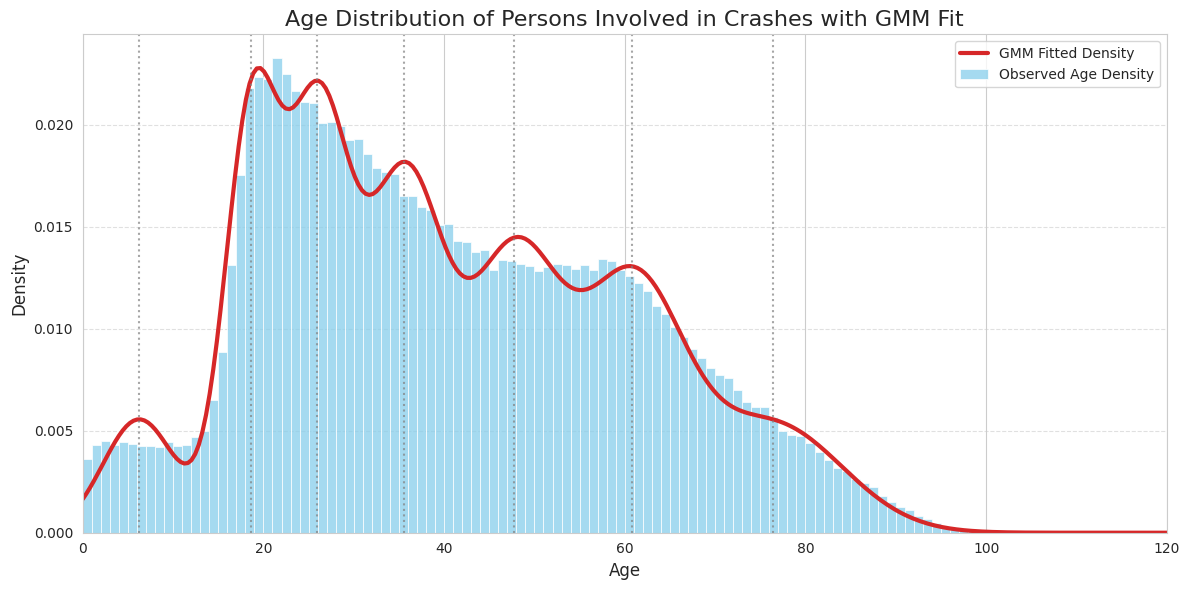


Processing Drugs Data...
  > Processed 43774 crashes with confirmed drug presence.
Merging and creating target...
Final Dataframe Shape: (144482, 47)

--- Target Distribution ---

ALC_USE Distribution:
  Value 0: 135458 (93.75%)
  Value 1: 9024 (6.25%)

DRUG_USE Distribution:
  Value 0: 100708 (69.70%)
  Value 1: 43774 (30.30%)

ALC_&_DRUG_USE Distribution:
  Value 0: 139664 (96.67%)
  Value 1: 4818 (3.33%)


In [7]:
df_final = process_and_create_target(clean_data, bic_max_components=7)

In [45]:
print("\n--- Final Cleaned Data Sample ---")
print(f"Shape: {df_final.shape}")
display(df_final.head(2))

print("\n--- Categorical Columns ---")
cat_col = {}
for col in df_final.columns.tolist():
    dtype = df_final[col].dtype.name
    if dtype in ['object', 'category', 'string']:
        unique_cat = df_final[col].unique()
        if len(unique_cat) < 100: # Some might be categorical but have too many unique values, like RAIL
            cat_col[col] = unique_cat
            print(f"Column: {col} | Type: {dtype} | Unique Values: {len(unique_cat)}")


--- Final Cleaned Data Sample ---
Shape: (144482, 47)


ST_CASE    STATE  PERMVIT  PERNOTMVIT  VE_TOTAL  VE_FORMS  PVH_INVL  \
0    10001  Alabama        1           0         2         1         1   
1    10002  Alabama        2           0         1         1         0   

                HARM_EV                                       MAN_COLL  \
0  Parked Motor Vehicle  Not Collision With Motor Vehicle In-Transport   
1                 Fence  Not Collision With Motor Vehicle In-Transport   

                                  RELJCT2 RUR_URB              TYP_INT  \
0                            Non-Junction   Rural  Not an Intersection   
1  Other location within Interchange Area   Urban  Not an Intersection   

      REL_ROAD SCH_BUS     RAIL            LGT_COND WEATHER  FATALS  YEAR  \
0  On Shoulder      No  0000000                Dawn   Clear       1  2018   
1    On Median      No  0000000  Dark - Not Lighted    Rain       2  2018   

        ROUTE    FUNC_SYS      CRASH_DATETIME  HOUR_SIN  HOUR_COS  MONTH_SIN  \
0  Interstate  Interstate 2018-01-05 06:00:00      1.00      0.00       0.50   
1  Interstate  Interstate 2018-01-08 00:48:00      0.00      1.00       0.50   

   MONTH_COS  DAYOFWEEK_SIN  DAYOFWEEK_COS  DAYOFYEAR_SIN  DAYOFYEAR_COS  \
0       0.87          -0.43          -0.90           0.09           1.00   
1       0.87           0.00           1.00           0.14           0.99   

   NUM_PERSONS  MAX_INJ_SEV  NUM_MALES  NUM_FATAL  NUM_SERIOUS  \
0            1            4          0          1            0   
1            2            4          0          2            0   

   NUM_NON_OCCUPANTS  NUM_REAR_SEAT  AGE_GROUP_0_to_12  AGE_GROUP_13_to_21  \
0                  0              0                  0                   0   
1                  0              0                  0                   0   

   AGE_GROUP_22_to_30  AGE_GROUP_31_to_41  AGE_GROUP_42_to_54  \
0                   0                   0                   0   
1                   2                   0                   0   

   AGE_GROUP_55_to_69  AGE_GROUP_70_to_119  ALC_USE  DRUG_USE  ALC_&_DRUG_USE  
0                   1                    0        0         0               0  
1                   0                    0        0         0               0


--- Categorical Columns ---
Column: STATE | Type: object | Unique Values: 51
Column: HARM_EV | Type: object | Unique Values: 55
Column: MAN_COLL | Type: object | Unique Values: 10
Column: RELJCT2 | Type: object | Unique Values: 15
Column: RUR_URB | Type: object | Unique Values: 4
Column: TYP_INT | Type: object | Unique Values: 9
Column: REL_ROAD | Type: object | Unique Values: 11
Column: SCH_BUS | Type: object | Unique Values: 2
Column: LGT_COND | Type: object | Unique Values: 7
Column: WEATHER | Type: object | Unique Values: 11
Column: ROUTE | Type: object | Unique Values: 5
Column: FUNC_SYS | Type: object | Unique Values: 7


In [46]:
for col, categories in cat_col.items():
    print(f"\n{col} Categories:")
    for cat in categories:
        print(f" - {cat}")


STATE Categories:
 - Alabama
 - Alaska
 - Arizona
 - Arkansas
 - California
 - Colorado
 - Connecticut
 - Delaware
 - District of Columbia
 - Florida
 - Georgia
 - Hawaii
 - Idaho
 - Illinois
 - Indiana
 - Iowa
 - Kansas
 - Kentucky
 - Louisiana
 - Maine
 - Maryland
 - Massachusetts
 - Michigan
 - Minnesota
 - Mississippi
 - Missouri
 - Montana
 - Nebraska
 - Nevada
 - New Hampshire
 - New Jersey
 - New Mexico
 - New York
 - North Carolina
 - North Dakota
 - Ohio
 - Oklahoma
 - Oregon
 - Pennsylvania
 - Rhode Island
 - South Carolina
 - South Dakota
 - Tennessee
 - Texas
 - Utah
 - Vermont
 - Virginia
 - Washington
 - West Virginia
 - Wisconsin
 - Wyoming

HARM_EV Categories:
 - Parked Motor Vehicle
 - Fence
 - Guardrail Face
 - Motor Vehicle In-Transport
 - Pedestrian
 - Traffic Sign Support
 - Rollover/Overturn
 - Tree (Standing Only)
 - Culvert
 - Ditch
 - Other Object (not fixed)
 - Boulder
 - Embankment
 - Ground
 - Building
 - Other Fixed Object
 - Bridge Rail (Includes parapet)

**Observations:** We still have considerable ammount of features with high cardinality. We will need to address this on the data processing pipeline.

## 4. EDA for merged FARS dataset

### 4.1. Age Group Distribution Analysis


--- Age Group Proportions (Sorted) ---


Display_Label  Count  Proportion_perc
0          0_12  19883             0.06
1         13_21  50057             0.14
2         22_30  65836             0.19
3         31_41  64415             0.18
4         42_54  61450             0.17
5         55_68  57383             0.16
6        69_119  36749             0.10

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


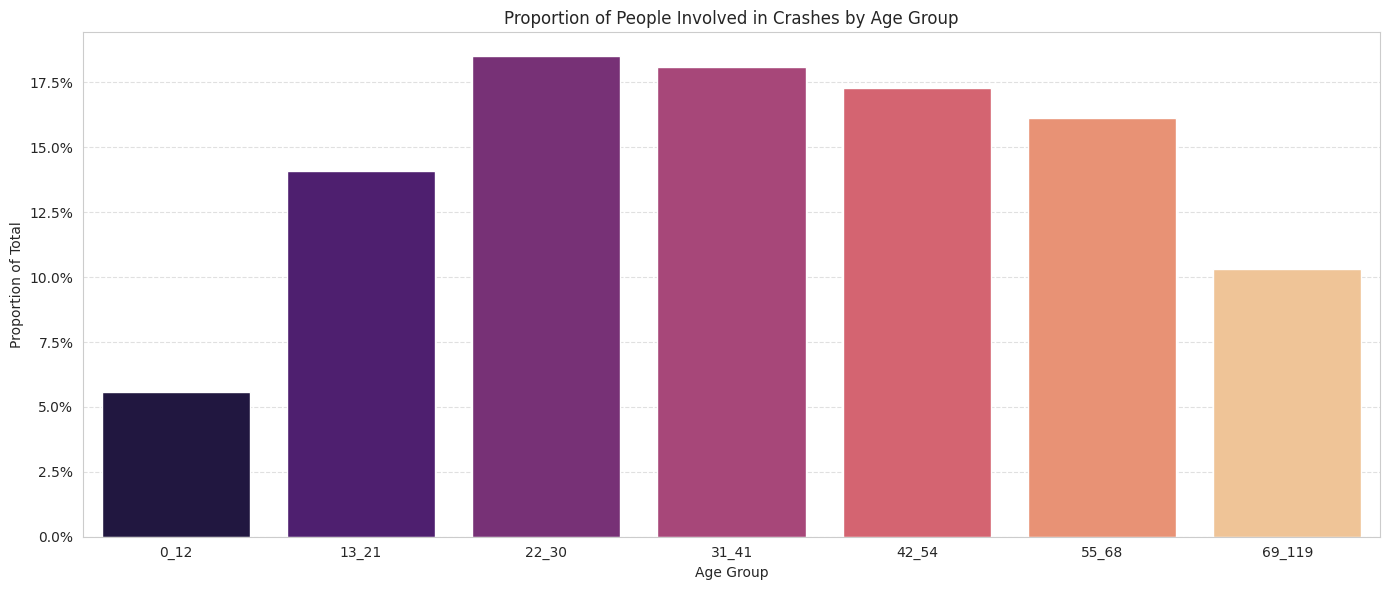

In [ ]:
# 1. Identify Age Group Columns
age_group_cols = [col for col in df_final.columns if col.startswith('AGE_GROUP_')]

# 2. Create the Summary Dataframe
age_group_summary = df_final[age_group_cols].sum().reset_index()
age_group_summary.columns = ['Age_Group', 'Count']

# --- NEW STEP: Calculate Proportion ---
total_people = age_group_summary['Count'].sum()
age_group_summary['Proportion_perc'] = age_group_summary['Count'] / total_people
# --------------------------------------

# 3. Create a Sorting Column and the Display Label safely
def extract_start_age(s):
    # Extracts the first age (x) for sorting
    try:
        return int(s.split('_')[2])
    except (IndexError, ValueError):
        return 999

def extract_display_label(s):
    # Transforms 'AGE_GROUP_0_to_12' into '0_12'
    parts = s.split('_')
    if len(parts) >= 5 and parts[3] == 'to':
        return f"{parts[2]}_{parts[4]}"
    return s.replace('AGE_GROUP_', '').replace('_', ' ') # Fallback for unknown/empty groups

age_group_summary['Sort_Key'] = age_group_summary['Age_Group'].apply(extract_start_age)
age_group_summary['Display_Label'] = age_group_summary['Age_Group'].apply(extract_display_label)
age_group_summary = age_group_summary.sort_values('Sort_Key').reset_index(drop=True)

print("\n--- Age Group Proportions (Sorted) ---")
display(age_group_summary[['Display_Label', 'Count', 'Proportion_perc']])

# 4. Plot
plt.figure(figsize=(14, 6))

ax = sns.barplot(
    data=age_group_summary, 
    x='Display_Label', 
    y='Proportion_perc',
    palette='magma', 
    hue='Display_Label', 
    legend=False
)

plt.title('Proportion of People Involved in Crashes by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Proportion of Total')

# --- FORMATTING ---
# Convert Y-axis decimals (0.1) to percentages (10%)
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


### 4.2. Time Series Analysis of Crashes

Saving figures to: EDA_reports/Time_series_analysis/
Unique values in ALC_&_DRUG_USE: [0 1]

Visualization 1: Global Trend ---
This plot shows the weekly and 4-week moving average of the combined impairment rate.
Look for long-term growth or decline and seasonal spikes (e.g., holidays).
--------------------------------------------------


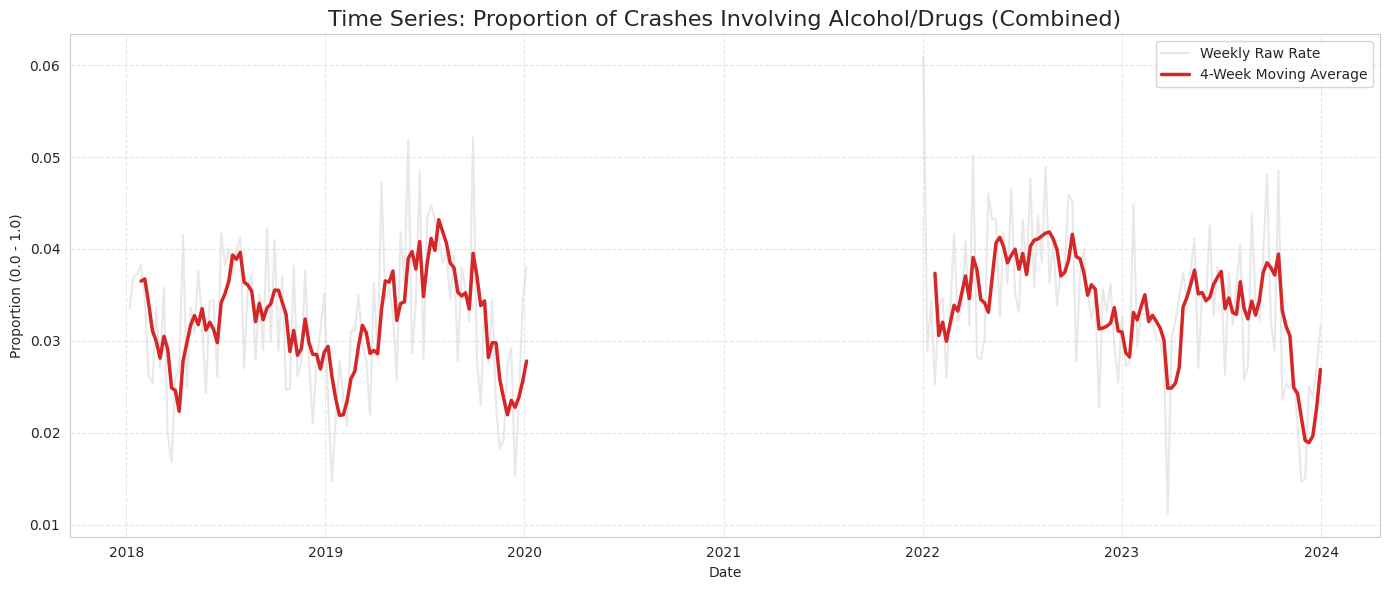


Calculating monthly trends for all impairment flags...

Visualization 2: Overall Impairment Rates (Total Dataset) ---
Co-occurrence Rate (ALC and DRUG): 3.33% of crashes
Alcohol Use Rate: 6.25% of crashes (Gross, includes Co-occurrence)
Drug Use Rate: 30.30% of crashes (Gross, includes Co-occurrence)
--------------------------------------------------
This chart compares the overall frequency trends of alcohol and drug involvement.
Key points to observe: 1) The relative proportion of the ALC_USE vs. DRUG_USE lines. 2) Whether the gross Drug trend is growing faster than the gross Alcohol trend.
--------------------------------------------------


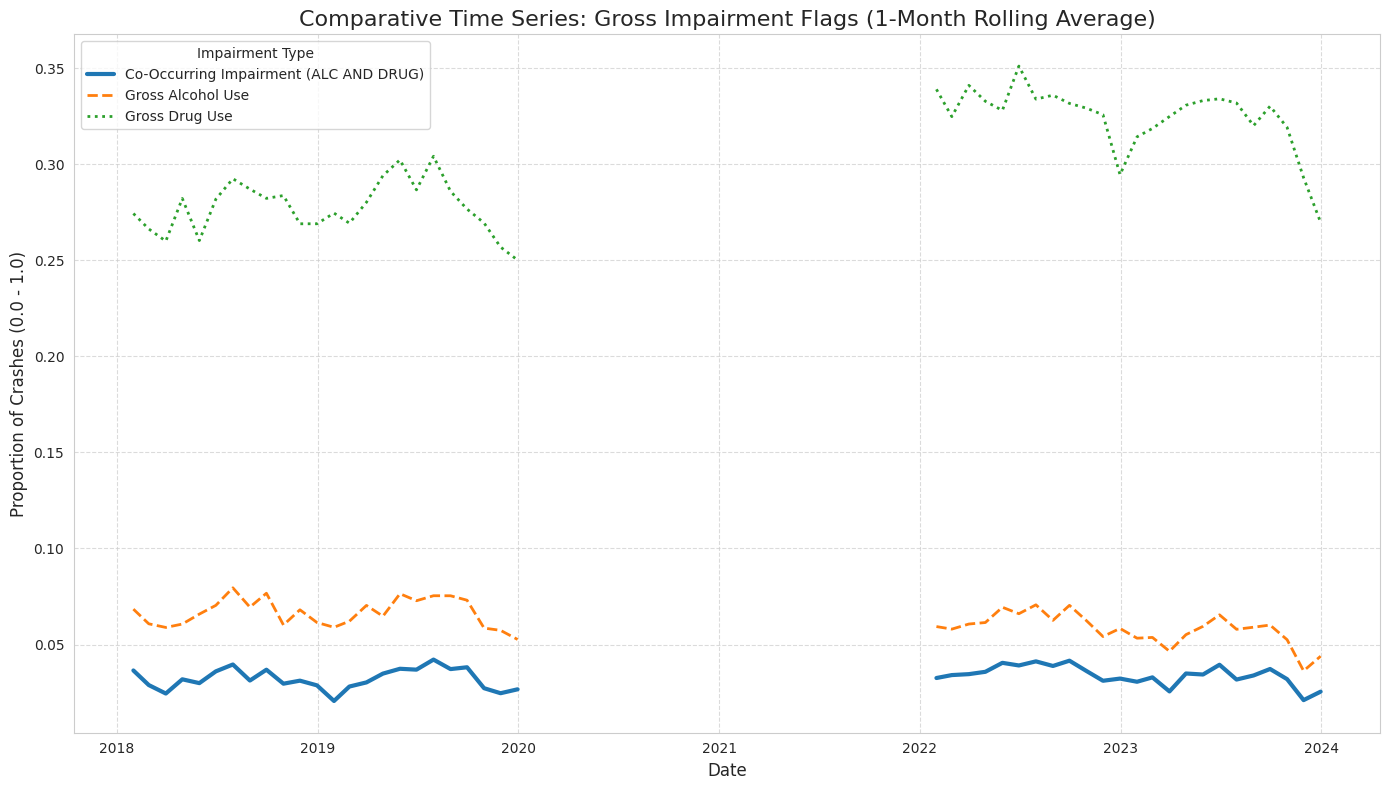


Visualization 3: Comparative Spatio-Temporal Heatmaps ---
These three heatmaps compare the spatial (State) and temporal (Month) distribution of mutually exclusive impairment types.
The primary axis (State) is sorted by the overall severity of Alcohol Only crashes for consistent comparison across all three plots.
Key observations: Look for differences in geographical hotspots (which states have high rates for ALC vs DRUG) and temporal patterns (seasonal peaks) across the three categories.
--------------------------------------------------------------------------


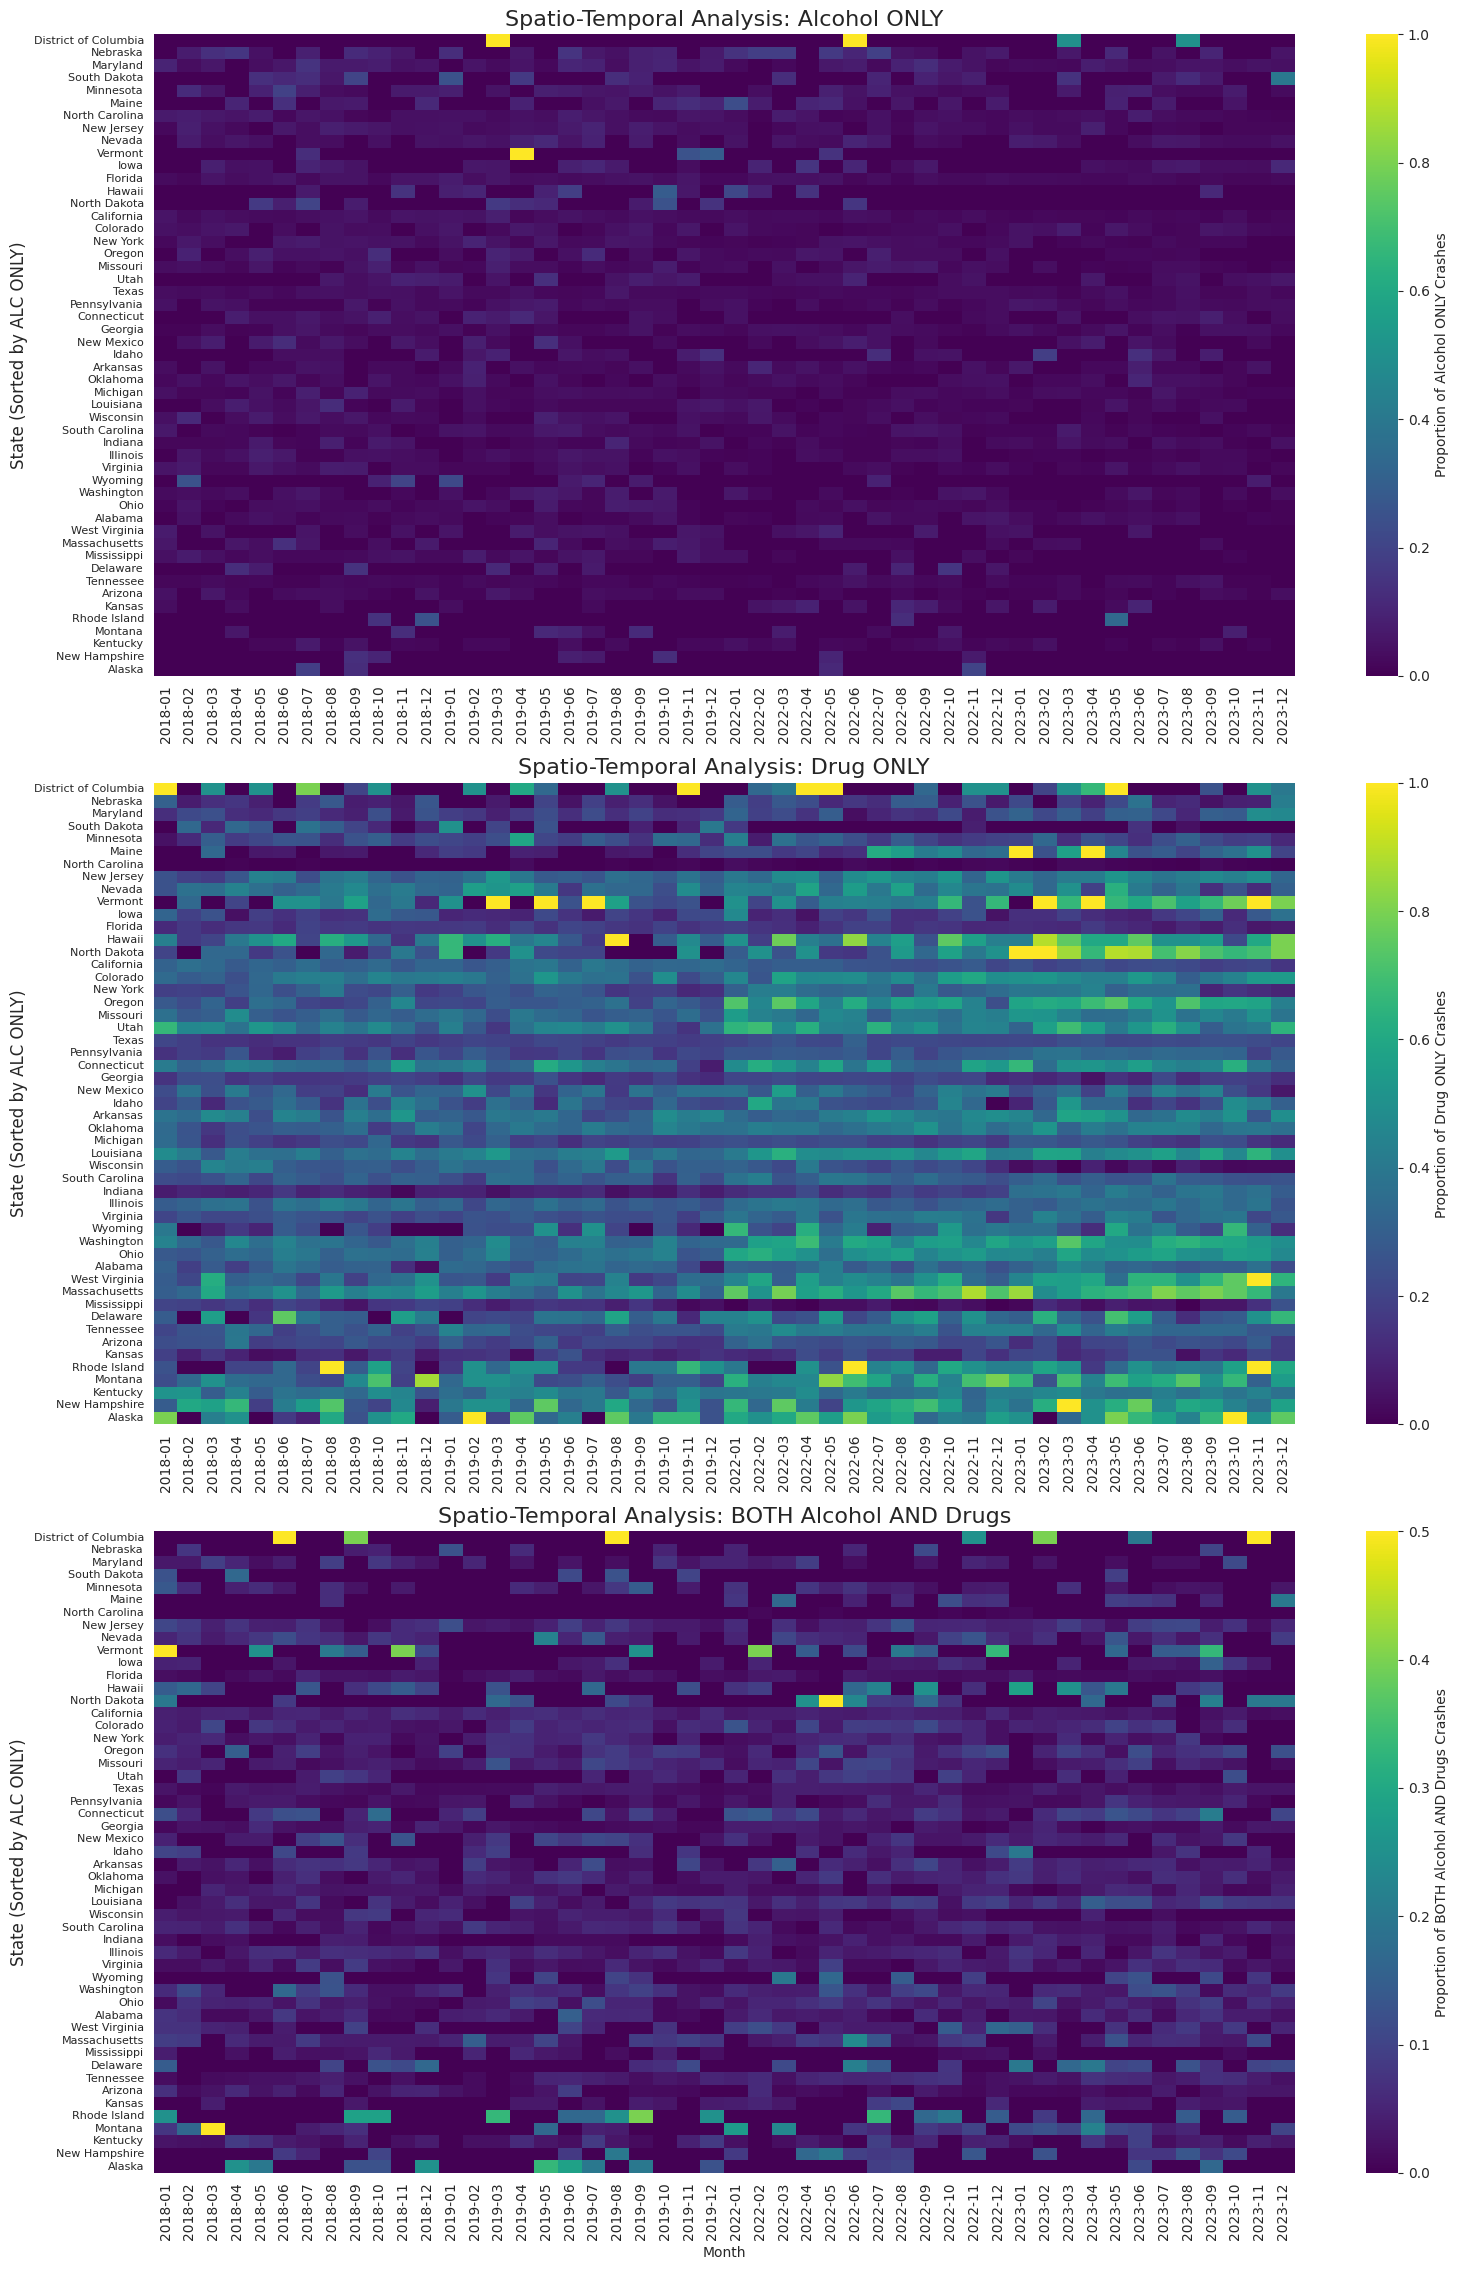


Visualization 4: Rural vs. Urban Comparison ---
Overall Average Rate (Rural): 3.06%
Overall Average Rate (Urban): 3.52%
This plot compares the temporal trend of combined impairment between rural and urban areas.
Check for which area has a consistently higher rate and if one trend line shows more volatility than the other.
------------------------------------------------------------------


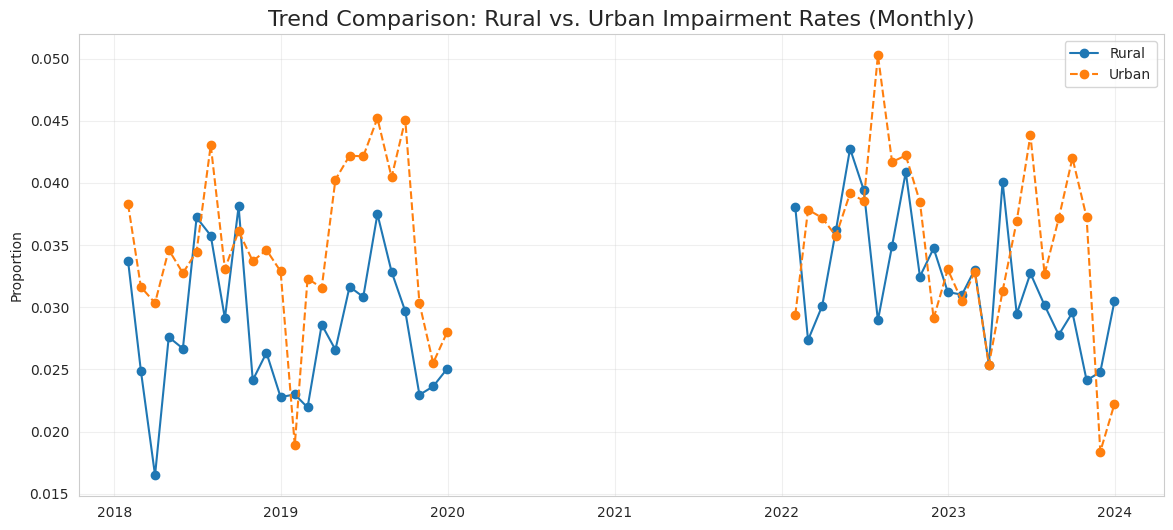

In [ ]:
# Define the output directory and ensure it exists
OUTPUT_DIR = 'EDA_reports/Time_series_analysis'
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Saving figures to: {OUTPUT_DIR}/")

# ==============================================================================
# 0. DIAGNOSTIC CHECK & PREPARATION
# ==============================================================================
# Assuming df_final is available from previous steps

# If this prints only [1] or [1.0], your data is filtered incorrectly.
print("Unique values in ALC_&_DRUG_USE:", df_final['ALC_&_DRUG_USE'].unique())

df_final['CRASH_DATETIME'] = pd.to_datetime(df_final['CRASH_DATETIME'])
df_final = df_final.sort_values('CRASH_DATETIME')
df_ts = df_final.set_index('CRASH_DATETIME').copy()

# Define the flags
FLAG_COLUMNS = ['ALC_USE', 'DRUG_USE', 'ALC_&_DRUG_USE']
ROLLING_WINDOW = 1 # num of months for rolling average

# Calculate mutually exclusive flags once in df_ts
df_ts['ALC_ONLY'] = ((df_ts['ALC_USE'] == 1) & (df_ts['DRUG_USE'] == 0)).astype(int)
df_ts['DRUG_ONLY'] = ((df_ts['DRUG_USE'] == 1) & (df_ts['ALC_USE'] == 0)).astype(int)
df_ts['BOTH_ALC_DRUG'] = df_ts['ALC_&_DRUG_USE']


# ==============================================================================
# VISUALIZATION 1: The Global Trend
# ==============================================================================
def plot_global_trend(df_ts):
    print("\nVisualization 1: Global Trend ---")
    print("This plot shows the weekly and 4-week moving average of the combined impairment rate.")
    print("Look for long-term growth or decline and seasonal spikes (e.g., holidays).")
    print("--------------------------------------------------")

    plt.figure(figsize=(14, 6))

    weekly_trend = df_ts['ALC_&_DRUG_USE'].resample('W').mean()
    rolling_trend = weekly_trend.rolling(window=4).mean()

    plt.plot(weekly_trend.index, weekly_trend, color='lightgray', alpha=0.5, label='Weekly Raw Rate')
    plt.plot(rolling_trend.index, rolling_trend, color='#d62728', linewidth=2.5, label='4-Week Moving Average')

    plt.title('Time Series: Proportion of Crashes Involving Alcohol/Drugs (Combined)', fontsize=16)
    plt.ylabel('Proportion (0.0 - 1.0)')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, '01_Global_Impairment_Trend.png'))
    plt.show()

# ==============================================================================
# VISUALIZATION 2: Comparison of Gross Impairment Flags Over Time
# ==============================================================================
def plot_gross_flag_comparison(df_ts, FLAG_COLUMNS, ROLLING_WINDOW):
    plt.figure(figsize=(14, 8))
    print("\nCalculating monthly trends for all impairment flags...")

    monthly_trends = {}
    overall_means = {} 

    for col in FLAG_COLUMNS:
        monthly_rate = df_ts[col].resample('ME').mean()
        monthly_trends[col] = monthly_rate.rolling(window=ROLLING_WINDOW, center=True).mean()
        overall_means[col] = df_ts[col].mean()

    print("\nVisualization 2: Overall Impairment Rates (Total Dataset) ---")
    print(f"Co-occurrence Rate (ALC and DRUG): {overall_means['ALC_&_DRUG_USE']:.2%} of crashes")
    print(f"Alcohol Use Rate: {overall_means['ALC_USE']:.2%} of crashes (Gross, includes Co-occurrence)")
    print(f"Drug Use Rate: {overall_means['DRUG_USE']:.2%} of crashes (Gross, includes Co-occurrence)")
    print("--------------------------------------------------")
    print("This chart compares the overall frequency trends of alcohol and drug involvement.")
    print("Key points to observe: 1) The relative proportion of the ALC_USE vs. DRUG_USE lines. 2) Whether the gross Drug trend is growing faster than the gross Alcohol trend.")
    print("--------------------------------------------------")

    plt.plot(monthly_trends['ALC_&_DRUG_USE'].index, monthly_trends['ALC_&_DRUG_USE'], 
             label='Co-Occurring Impairment (ALC AND DRUG)', linewidth=3, color='#1f77b4')

    plt.plot(monthly_trends['ALC_USE'].index, monthly_trends['ALC_USE'], 
             label='Gross Alcohol Use', linewidth=2, linestyle='--', color='#ff7f0e')

    plt.plot(monthly_trends['DRUG_USE'].index, monthly_trends['DRUG_USE'], 
             label='Gross Drug Use', linewidth=2, linestyle=':', color='#2ca02c')

    plt.title(f'Comparative Time Series: Gross Impairment Flags ({ROLLING_WINDOW}-Month Rolling Average)', fontsize=16)
    plt.ylabel('Proportion of Crashes (0.0 - 1.0)', fontsize=12)
    plt.xlabel('Date', fontsize=12)
    plt.legend(title='Impairment Type')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, '02_Gross_Flag_Comparison_Trend.png'))
    plt.show()


# ==============================================================================
# VISUALIZATION 3: Mutually Exclusive Spatio-Temporal Heatmaps
# ==============================================================================
def plot_comparative_heatmaps(df_ts):
    FLAG_MAP = {
        'ALC_ONLY': {'title': 'Alcohol ONLY'},
        'DRUG_ONLY': {'title': 'Drug ONLY'},
        'BOTH_ALC_DRUG': {'title': 'BOTH Alcohol AND Drugs'}
    }

    print("\nVisualization 3: Comparative Spatio-Temporal Heatmaps ---")
    print("These three heatmaps compare the spatial (State) and temporal (Month) distribution of mutually exclusive impairment types.")
    print("The primary axis (State) is sorted by the overall severity of Alcohol Only crashes for consistent comparison across all three plots.")
    print("Key observations: Look for differences in geographical hotspots (which states have high rates for ALC vs DRUG) and temporal patterns (seasonal peaks) across the three categories.")
    print("--------------------------------------------------------------------------")

    # Increase total figure height significantly for better y-label readability
    fig = plt.figure(figsize=(16, 24)) 

    # --- Determine consistent state sorting based on Alcohol ONLY severity ---
    base_heatmap_data = df_ts.groupby(['STATE', pd.Grouper(freq='ME')])['ALC_ONLY'].mean().unstack().fillna(0)
    sorted_states = base_heatmap_data.mean(axis=1).sort_values(ascending=False).index

    # --- Plot all three categories ---
    for i, (col, details) in enumerate(FLAG_MAP.items()):
        
        heatmap_data = df_ts.groupby(['STATE', pd.Grouper(freq='ME')])[col].mean().unstack().fillna(0)
        heatmap_data = heatmap_data.loc[sorted_states]

        ax = fig.add_subplot(3, 1, i + 1)
        
        sns.heatmap(
            heatmap_data, 
            cmap='viridis', 
            cbar_kws={'label': f'Proportion of {details["title"]} Crashes'},
            xticklabels=heatmap_data.columns.strftime('%Y-%m'),
            yticklabels=(heatmap_data.index), # Show all y-labels
            ax=ax
        )
        
        ax.set_title(f'Spatio-Temporal Analysis: {details["title"]}', fontsize=16)
        ax.set_xlabel('Month' if i == 2 else '')
        ax.set_ylabel('State (Sorted by ALC ONLY)', fontsize=12)
        ax.tick_params(axis='y', labelsize=8) # Explicitly set y-label font size

    plt.tight_layout(rect=(0, 0.03, 1, 0.98)) # Adjust layout to fit large figure
    plt.savefig(os.path.join(OUTPUT_DIR, '03_SpatioTemporal_Heatmaps_Comparative.png'))
    plt.show()

# ==============================================================================
# VISUALIZATION 4: Comparative Time Series (Rural vs Urban)
# ==============================================================================
def plot_rural_urban_comparison(df_ts):
    print("\nVisualization 4: Rural vs. Urban Comparison ---")
    rural_mean = df_ts[df_ts['RUR_URB'] == 'Rural']['ALC_&_DRUG_USE'].mean()
    urban_mean = df_ts[df_ts['RUR_URB'] == 'Urban']['ALC_&_DRUG_USE'].mean()

    print(f"Overall Average Rate (Rural): {rural_mean:.2%}")
    print(f"Overall Average Rate (Urban): {urban_mean:.2%}")
    print("This plot compares the temporal trend of combined impairment between rural and urban areas.")
    print("Check for which area has a consistently higher rate and if one trend line shows more volatility than the other.")
    print("------------------------------------------------------------------")

    plt.figure(figsize=(14, 6))

    rural = df_ts[df_ts['RUR_URB'] == 'Rural']['ALC_&_DRUG_USE'].resample('ME').mean()
    urban = df_ts[df_ts['RUR_URB'] == 'Urban']['ALC_&_DRUG_USE'].resample('ME').mean()

    plt.plot(rural.index, rural, label='Rural', marker='o')
    plt.plot(urban.index, urban, label='Urban', marker='o', linestyle='--')

    plt.title('Trend Comparison: Rural vs. Urban Impairment Rates (Monthly)', fontsize=16)
    plt.ylabel('Proportion')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(OUTPUT_DIR, '04_Rural_Urban_Comparison_Trend.png'))
    plt.show()

# --- EXECUTE ALL PLOTS ---
if 'df_final' in locals():
    plot_global_trend(df_ts)
    plot_gross_flag_comparison(df_ts, FLAG_COLUMNS, ROLLING_WINDOW)
    plot_comparative_heatmaps(df_ts)
    plot_rural_urban_comparison(df_ts)
else:
    print("Error: 'df_final' not found. Please ensure the data processing step was run successfully.")

### 4.3. Geographic Coverage

In [252]:
# State distribution in final dataframe
state_counts = df_final['STATE'].value_counts(normalize=True) * 100
print("\n--- State Distribution in Final Data (%) ---")
for state, perc in state_counts.items():
    print(f"State {state}: {perc:.2f}%")


--- State Distribution in Final Data (%) ---
State California: 10.28%
State Texas: 10.00%
State Florida: 8.56%
State Georgia: 4.12%
State North Carolina: 3.90%
State Tennessee: 3.08%
State Ohio: 3.02%
State Pennsylvania: 2.99%
State Arizona: 2.92%
State Illinois: 2.89%
State New York: 2.72%
State South Carolina: 2.69%
State Michigan: 2.69%
State Alabama: 2.45%
State Missouri: 2.45%
State Virginia: 2.32%
State Indiana: 2.27%
State Louisiana: 2.08%
State Kentucky: 1.93%
State Colorado: 1.73%
State Mississippi: 1.72%
State Oklahoma: 1.71%
State Washington: 1.69%
State New Jersey: 1.57%
State Wisconsin: 1.48%
State Maryland: 1.45%
State Arkansas: 1.43%
State Oregon: 1.38%
State New Mexico: 1.07%
State Minnesota: 1.02%
State Kansas: 1.00%
State Massachusetts: 0.97%
State Nevada: 0.91%
State Iowa: 0.86%
State Connecticut: 0.78%
State Utah: 0.70%
State West Virginia: 0.69%
State Idaho: 0.59%
State Nebraska: 0.58%
State Montana: 0.49%
State Maine: 0.39%
State Delaware: 0.34%
State New Hampshi

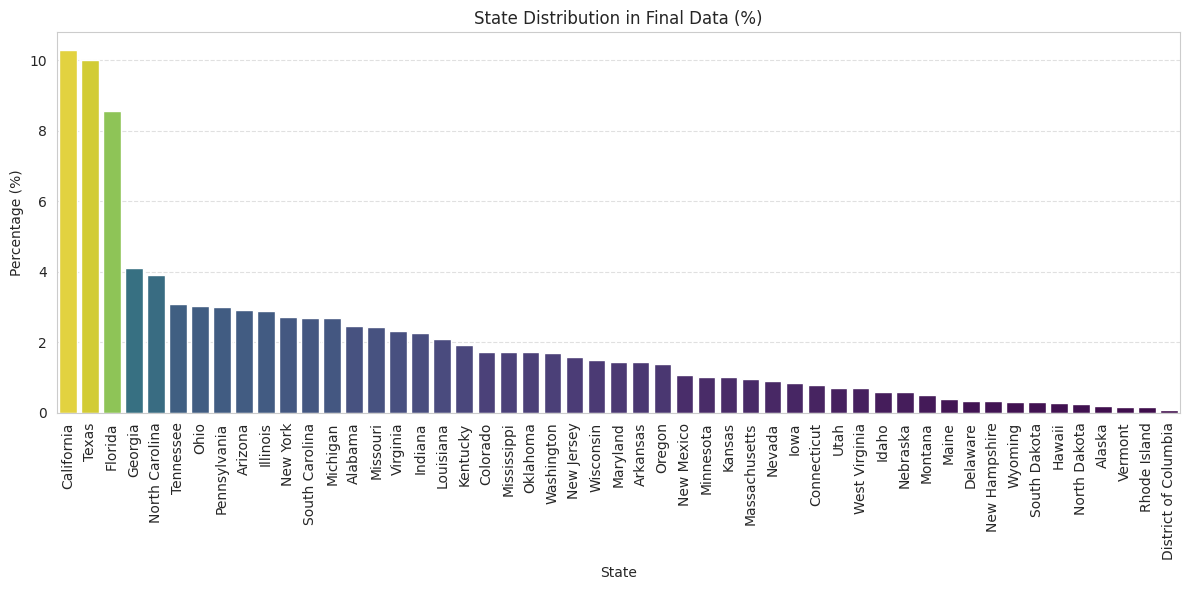

In [253]:
# Visualize state distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=state_counts.index, y=state_counts.values, palette='viridis', hue=state_counts.values, legend=False)
plt.title('State Distribution in Final Data (%)')
plt.xlabel('State')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### 4.4. Other Temporal Patterns

This includes day of week, month of year, time of day analysis

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


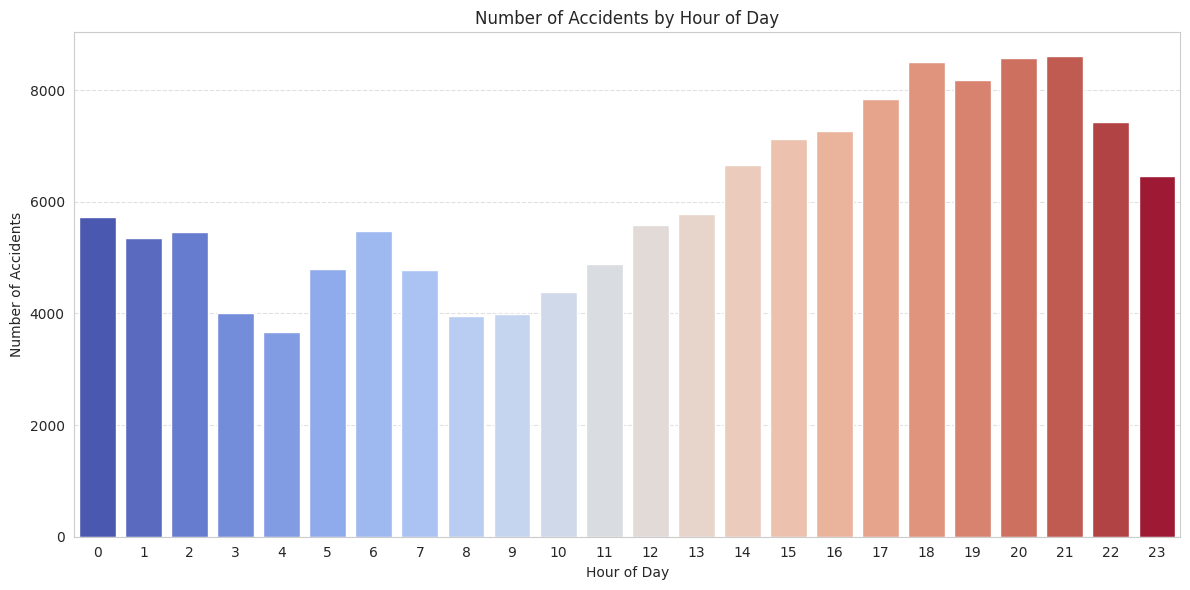

In [254]:
# Plot Accidents by hour of day
hour_counts = df_final['CRASH_DATETIME'].dt.hour.astype(int).value_counts().sort_index()

plt.figure(figsize=(12, 6))
plot_data = hour_counts.reset_index()
plot_data.columns = ['Hour', 'Count']
sns.barplot(
    x=plot_data['Hour'], 
    y=plot_data['Count'], 
    palette='coolwarm',
    hue=plot_data['Hour'],
    legend=False # Hide the redundant legend
)

plt.title('Number of Accidents by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Accidents')
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


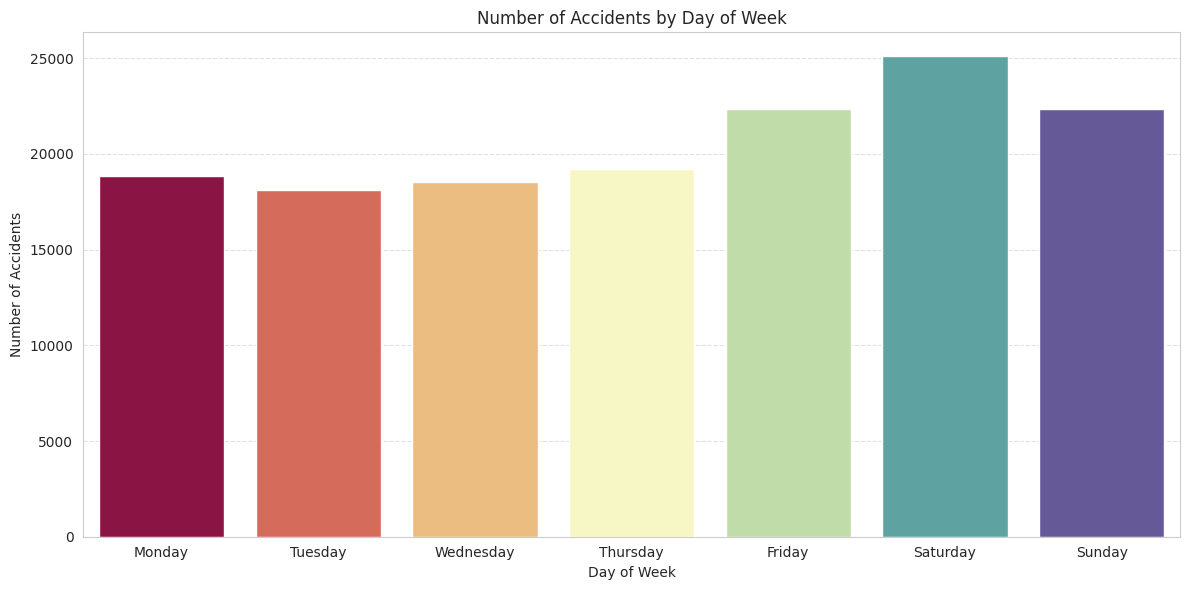

In [255]:
# Accidents by day of week
dayofweek_counts = df_final['CRASH_DATETIME'].dt.dayofweek.astype(int).value_counts().sort_index()
plt.figure(figsize=(12, 6))
plot_data = dayofweek_counts.reset_index()
plot_data.columns = ['DayOfWeek', 'Count']
sns.barplot(
    x=plot_data['DayOfWeek'], 
    y=plot_data['Count'], 
    palette='Spectral',
    hue=plot_data['DayOfWeek'],
    legend=False # Hide the redundant legend
)
plt.title('Number of Accidents by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Accidents')
plt.xticks(range(0, 7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

**Observation:** The weekend has a higher number of fatal accidents compared to working days, let's dive into the hourly distribution on weekends to see why

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


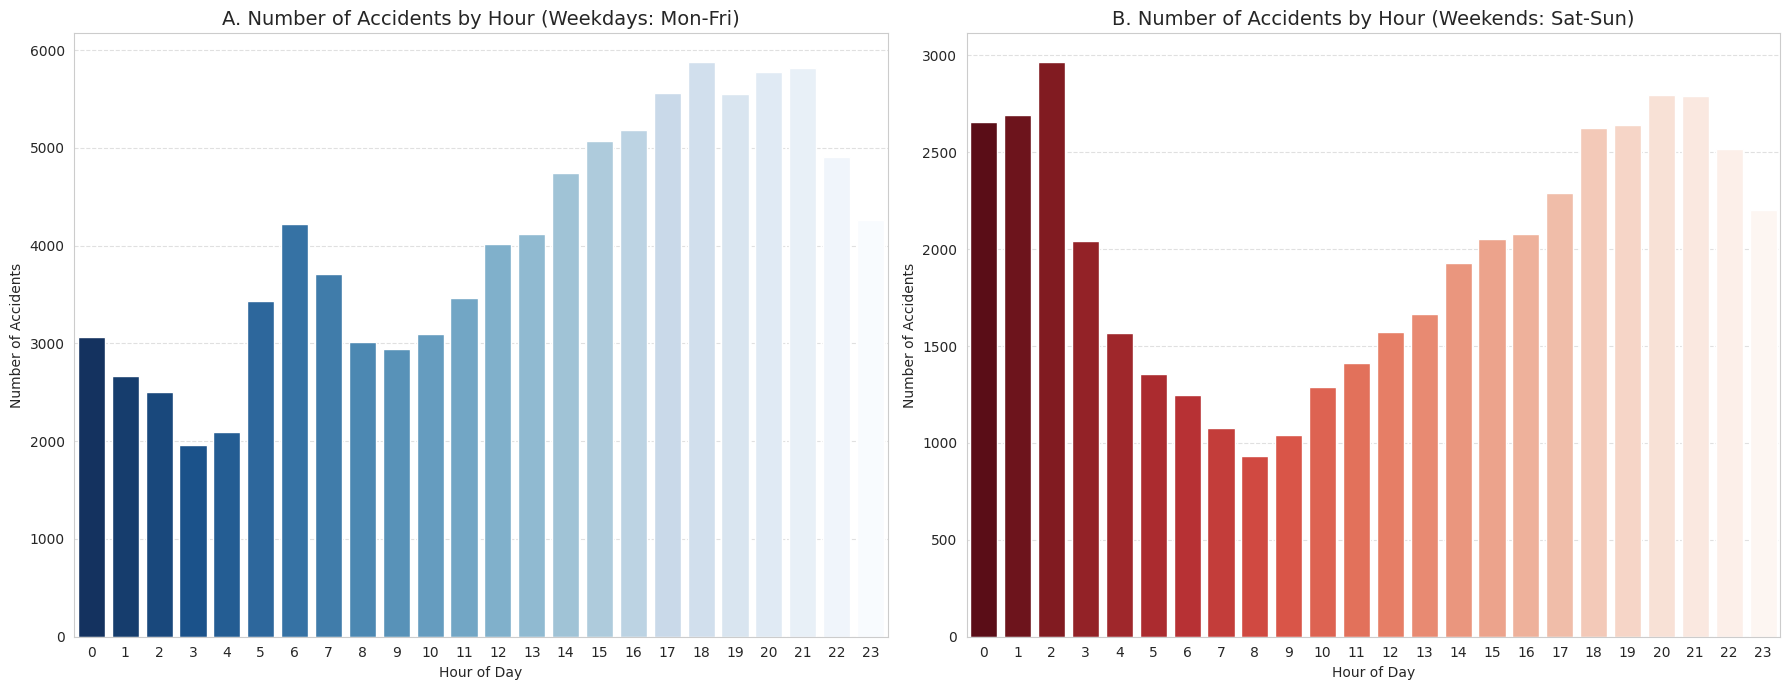

In [256]:
# Define masks for filtering
weekend_mask = df_final['CRASH_DATETIME'].dt.dayofweek.isin([5, 6])  # Saturday=5, Sunday=6
weekday_mask = ~weekend_mask  # All other days (0=Monday to 4=Friday)

# Calculate hour counts for both groups (Series indexed by hour)
weekend_hour_counts = df_final.loc[weekend_mask, 'CRASH_DATETIME'].dt.hour.value_counts().sort_index()
weekday_hour_counts = df_final.loc[weekday_mask, 'CRASH_DATETIME'].dt.hour.value_counts().sort_index()

# Reindex to ensure all hours 0-23 are present (fill missing with 0)
hours = list(range(24))
weekday_series = weekday_hour_counts.reindex(hours, fill_value=0)
weekend_series = weekend_hour_counts.reindex(hours, fill_value=0)

# Build separate DataFrames and concatenate (avoids concatenating Index objects)
weekday_df = pd.DataFrame({
    'Hour': hours,
    'Count': weekday_series.values,
    'DayType': ['Weekday'] * len(hours)
})

weekend_df = pd.DataFrame({
    'Hour': hours,
    'Count': weekend_series.values,
    'DayType': ['Weekend'] * len(hours)
})

plot_data_combined = pd.concat([weekday_df, weekend_df], ignore_index=True)

# Ensure the Hour column is numeric for plotting
plot_data_combined['Hour'] = plot_data_combined['Hour'].astype(int)

# ==============================================================================
# 2. COMPARATIVE VISUALIZATION (Side-by-Side)
# ==============================================================================

# Increase figure size for two subplots
plt.figure(figsize=(18, 7))

# --- PLOT 1: WEEKDAY ---
ax1 = plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st plot
sns.barplot(
    data=plot_data_combined[plot_data_combined['DayType'] == 'Weekday'],
    x='Hour',
    y='Count',
    palette='Blues_r',  # Different palette for distinction
    hue='Hour',
    legend=False,
    ax=ax1
)
ax1.set_title('A. Number of Accidents by Hour (Weekdays: Mon-Fri)', fontsize=14)
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Number of Accidents')
ax1.set_xticks(range(0, 24))
ax1.grid(axis='y', linestyle='--', alpha=0.6)


# --- PLOT 2: WEEKEND ---
ax2 = plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd plot
sns.barplot(
    data=plot_data_combined[plot_data_combined['DayType'] == 'Weekend'],
    x='Hour',
    y='Count',
    palette='Reds_r',  # Different palette for distinction
    hue='Hour',
    legend=False,
    ax=ax2
)
ax2.set_title('B. Number of Accidents by Hour (Weekends: Sat-Sun)', fontsize=14)
ax2.set_xlabel('Hour of Day')
ax2.set_ylabel('Number of Accidents')
ax2.set_xticks(range(0, 24))
ax2.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

**Observation:** The rush hour patterns are less pronounced on weekends compared to weekdays. While there are still peaks in accident counts during late morning and early afternoon hours, the overall distribution is more uniform throughout the day. This suggests that weekend traffic is less influenced by traditional work commute times, leading to a more even spread of accidents across different hours.

### 4.5. Distribution of Crashe severity Metrics

#### 4.5.1. Distribution of Severe (Non-Fatal) Injuries NUM_SERIOUS

Since the crash itself is fatal, the next most critical category is **Serious Injuries (Severity A or 3)**. Studying the distribution of `NUM_SERIOUS` reveals how many other lives were critically impacted beyond the single fatality required to classify the crash.

You can categorize crashes by the number of seriously injured persons:

  * **Zero Serious Injuries:** $N_{\text{Serious}}=0$
  * **One Serious Injury:** $N_{\text{Serious}}=1$
  * **Multiple Serious Injuries:** $N_{\text{Serious}} \ge 2$


--- Distribution of Serious (Non-Fatal) Injuries per Crash ---
0 Serious Injuries: 82.42%
1 Serious Injury: 12.62%
2+ Serious Injuries: 4.96%


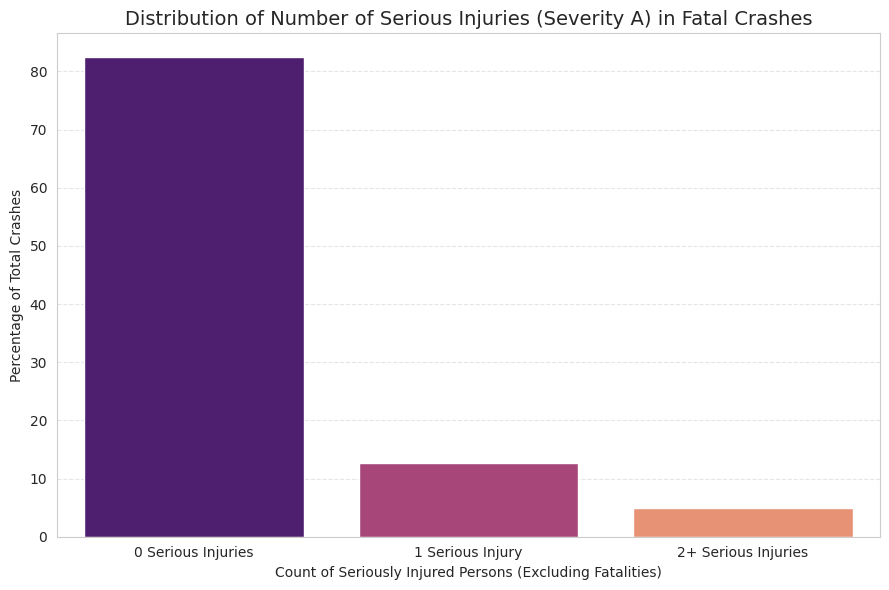

In [50]:
# Create categorical bins for the number of serious injuries
df_final['SERIOUS_INJURY_COUNT_BIN'] = pd.cut(
    df_final['NUM_SERIOUS'],
    bins=[-0.1, 0.9, 1.9, df_final['NUM_SERIOUS'].max() + 1],
    labels=['0 Serious Injuries', '1 Serious Injury', '2+ Serious Injuries'],
    right=False # Bins are inclusive of the left side
)

# Calculate and print the distribution
serious_dist = df_final['SERIOUS_INJURY_COUNT_BIN'].value_counts(normalize=True).sort_index() * 100

print("\n--- Distribution of Serious (Non-Fatal) Injuries per Crash ---")
for category, percent in serious_dist.items():
    print(f"{category}: {percent:.2f}%")

# Plotting the distribution
plt.figure(figsize=(9, 6))
sns.barplot(
    x=serious_dist.index, 
    y=serious_dist.values, 
    palette='magma', 
    hue=serious_dist.index,
    legend=False
)
plt.title('Distribution of Number of Serious Injuries (Severity A) in Fatal Crashes', fontsize=14)
plt.xlabel('Count of Seriously Injured Persons (Excluding Fatalities)')
plt.ylabel('Percentage of Total Crashes')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

#### 4.5.2. Vulnerability-Based Severity FATAL/NON_OCCUPANT

This is a powerful metric that reframes severity not by the injury code, but by the **type of person killed**. A fatality involving a non-occupant (pedestrian or cyclist) is often seen as a greater severity metric due to the increased vulnerability and usually highlights different risk factors (e.g., urban design, distracted driving).

You can calculate the proportion of fatal crashes that involved the death of a non-occupant:

$$\text{Vulnerability Severity Rate} = \frac{\text{Crashes with } \text{NUM\_FATAL} > 0 \text{ AND } \text{NUM\_NON\_OCCUPANTS} > 0}{\text{Total Crashes}}$$


--- Vulnerability Severity: Non-Occupant Fatalities ---
Percentage of Fatal Crashes where a Non-Occupant (Pedestrian/Cyclist) was Killed: 1.69%


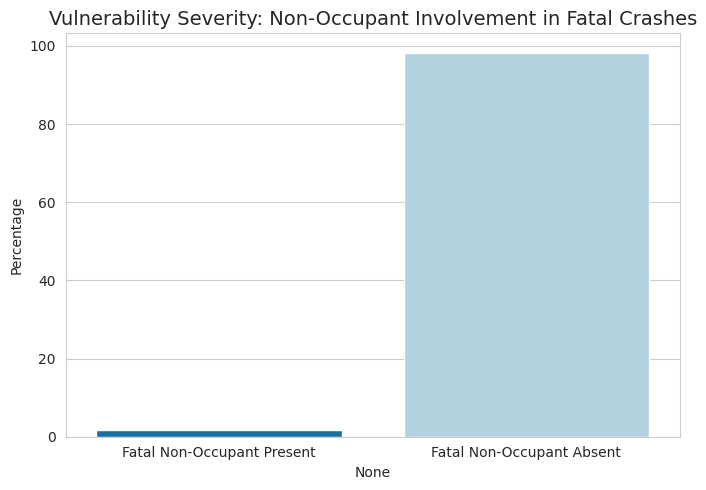

In [52]:
# Calculate the number of crashes where the fatality included a non-occupant
# Note: In a fatal crash dataset, NUM_FATAL >= 1 is always true.
vulnerable_fatal_crashes = df_final[df_final['NUM_NON_OCCUPANTS'] >= 1].shape[0]

total_crashes = df_final.shape[0]

vulnerability_rate = (vulnerable_fatal_crashes / total_crashes) * 100

print("\n--- Vulnerability Severity: Non-Occupant Fatalities ---")
print(f"Percentage of Fatal Crashes where a Non-Occupant (Pedestrian/Cyclist) was Killed: {vulnerability_rate:.2f}%")

# Create a simple binary distribution chart
vulnerability_data = pd.Series([vulnerability_rate, 100 - vulnerability_rate], 
                               index=['Fatal Non-Occupant Present', 'Fatal Non-Occupant Absent'])

plt.figure(figsize=(7, 5))
sns.barplot(
    x=vulnerability_data.index, 
    y=vulnerability_data.values, 
    palette=['#0077b6', '#a9d6e5'],
    hue=vulnerability_data.index,
    legend=False
)
plt.title('Vulnerability Severity: Non-Occupant Involvement in Fatal Crashes', fontsize=14)
plt.ylabel('Percentage')
plt.tight_layout()
plt.show()

#### 4.5.3. Total Harm Index 

You can create a custom **Total Harm Index** for each crash by weighting different injury levels and vulnerability types, giving you a continuous severity score you can analyze further:

$$\text{Harm Index} = (4 \times \text{NUM\_FATAL}) + (3 \times \text{NUM\_SERIOUS}) + (\text{Weight}_{\text{Vulnerable}} \times \text{NUM\_NON\_OCCUPANTS})$$

A simple index using the FARS codes as base weights (where Fatal=4 and Serious=3) is a great starting point.


--- Distribution of Total Harm Index (Combined Severity Score) ---
Index Mean: 5.11
Index Max: 170.00


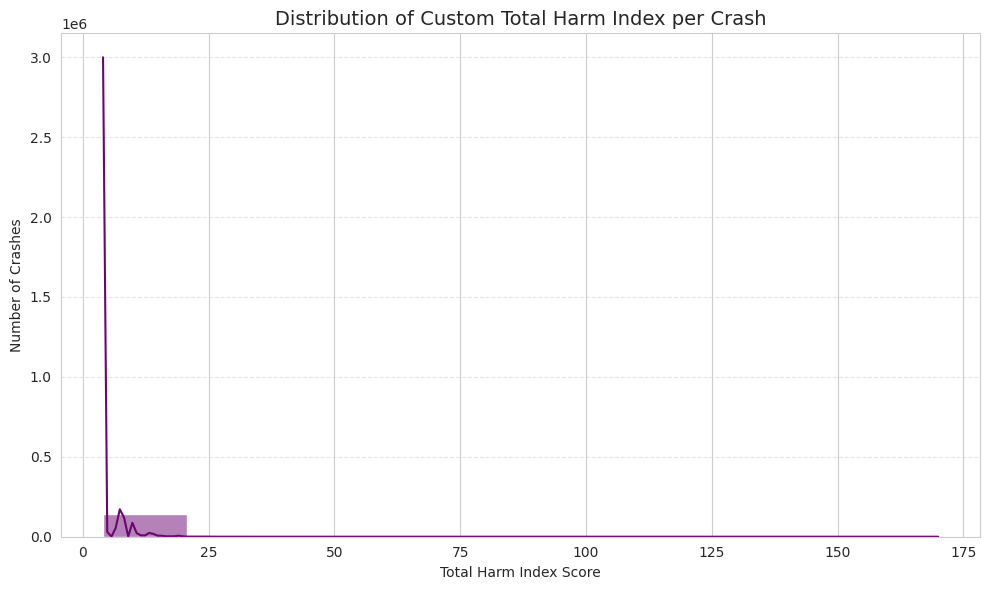

In [53]:
# Assuming NUM_FATAL and NUM_SERIOUS are counts of persons.
# Assign a slight bonus weight (e.g., 0.5) to non-occupants to reflect extra vulnerability.
VULNERABILITY_BONUS = 0.5

df_final['TOTAL_HARM_INDEX'] = (
    (df_final['NUM_FATAL'] * 4) + 
    (df_final['NUM_SERIOUS'] * 3) + 
    (df_final['NUM_NON_OCCUPANTS'] * VULNERABILITY_BONUS)
)

print("\n--- Distribution of Total Harm Index (Combined Severity Score) ---")
print(f"Index Mean: {df_final['TOTAL_HARM_INDEX'].mean():.2f}")
print(f"Index Max: {df_final['TOTAL_HARM_INDEX'].max():.2f}")

# Plot the distribution of the calculated index
plt.figure(figsize=(10, 6))
sns.histplot(df_final['TOTAL_HARM_INDEX'], bins=10, kde=True, color='#6a0572')
plt.title('Distribution of Custom Total Harm Index per Crash', fontsize=14)
plt.xlabel('Total Harm Index Score')
plt.ylabel('Number of Crashes')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### 4.6. Weather Conditions


--- Weather Condition Distribution in Final Data (%) ---
Clear: 76.73% (Count: 110863)
Cloudy: 13.48% (Count: 19482)
Rain: 7.23% (Count: 10443)
Fog, Smog, Smoke: 1.05% (Count: 1514)
Snow: 0.91% (Count: 1319)
Severe Crosswinds: 0.15% (Count: 219)
Sleet or Hail: 0.14% (Count: 197)
Other: 0.10% (Count: 150)
Blowing Snow: 0.10% (Count: 140)
Freezing Rain or Drizzle: 0.08% (Count: 118)
Blowing Sand, Soil, Dirt: 0.03% (Count: 37)


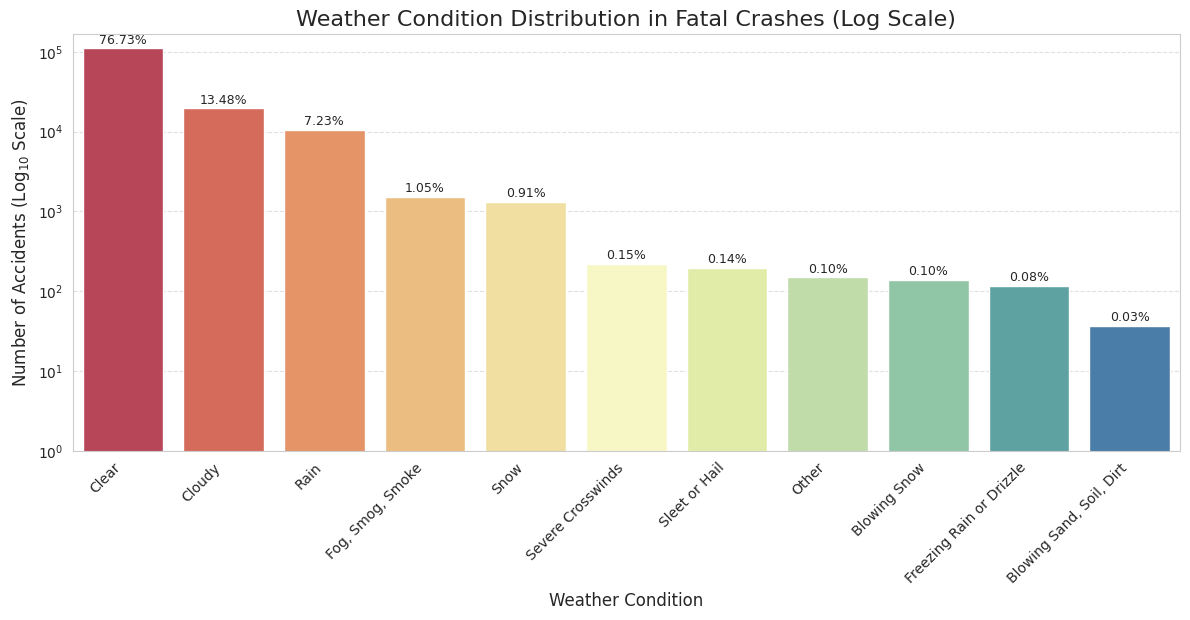

In [58]:
import math # Needed for log scale and annotation placement

# --- Data Preparation ---
# Calculate distribution (Counts) and sorted by value (descending)
weather_counts_raw = df_final['WEATHER'].value_counts().sort_values(ascending=False)
total_crashes = weather_counts_raw.sum()
percentage_map = (weather_counts_raw / total_crashes) * 100

# Create a DataFrame for Seaborn plotting
plot_data = weather_counts_raw.reset_index()
plot_data.columns = ['Condition', 'Count']

print("\n--- Weather Condition Distribution in Final Data (%) ---")
for condition, count in weather_counts_raw.items():
    print(f"{condition}: {percentage_map[condition]:.2f}% (Count: {count})")


# --- Visualization with Log10 Scale and Annotation ---
plt.figure(figsize=(12, 7))

# 1. Create the Bar Plot
ax = sns.barplot(
    x='Condition', 
    y='Count',  # Plotting raw counts for better log visualization
    data=plot_data, 
    palette='Spectral', # Changed palette for better contrast
    hue='Condition',
    legend=False
)

# 2. Apply Log10 Scale to the Y-axis
ax.set_yscale('log')

# 3. Add Percentage Annotations
for i, bar in enumerate(ax.patches):
    # Get the original percentage from the percentage_map
    condition = plot_data.iloc[i]['Condition']
    percent = percentage_map[condition]
    
    # Get the height of the bar for positioning the annotation
    yval = bar.get_height()
    
    # Calculate the position for the annotation on the log scale
    # We use a small offset on the log scale (e.g., *1.2) for placement
    # The actual y-position is complex on a log scale, so we use ax.text
    ax.text(
        bar.get_x() + bar.get_width()/2, 
        yval * 1.05, # Position slightly above the bar
        f'{percent:.2f}%', 
        ha='center', 
        va='bottom',
        fontsize=9
    )

# 4. Final Formatting
ax.set_title('Weather Condition Distribution in Fatal Crashes (Log Scale)', fontsize=16)
ax.set_xlabel('Weather Condition', fontsize=12)
ax.set_ylabel('Number of Accidents (Log$_{10}$ Scale)', fontsize=12)

# Adjust y-limits and ticks for the log scale to show all data clearly
# Max y-limit is usually total_crashes + offset
ax.set_ylim(bottom=1) # Log scale cannot start at 0

plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Adjust layout to fit rotated labels and annotations
plt.tight_layout(rect=(0, 0.1, 1, 1)) 
plt.show()

### 4.7. Light Conditions


--- Light Condition Distribution in Final Data (%) ---
Daylight: 46.51% (Count: 67198)
Dark - Not Lighted: 27.17% (Count: 39258)
Dark - Lighted: 20.99% (Count: 30332)
Dusk: 2.39% (Count: 3457)
Dawn: 1.93% (Count: 2795)
Dark - Unknown Lighting: 0.95% (Count: 1376)
Other: 0.05% (Count: 66)


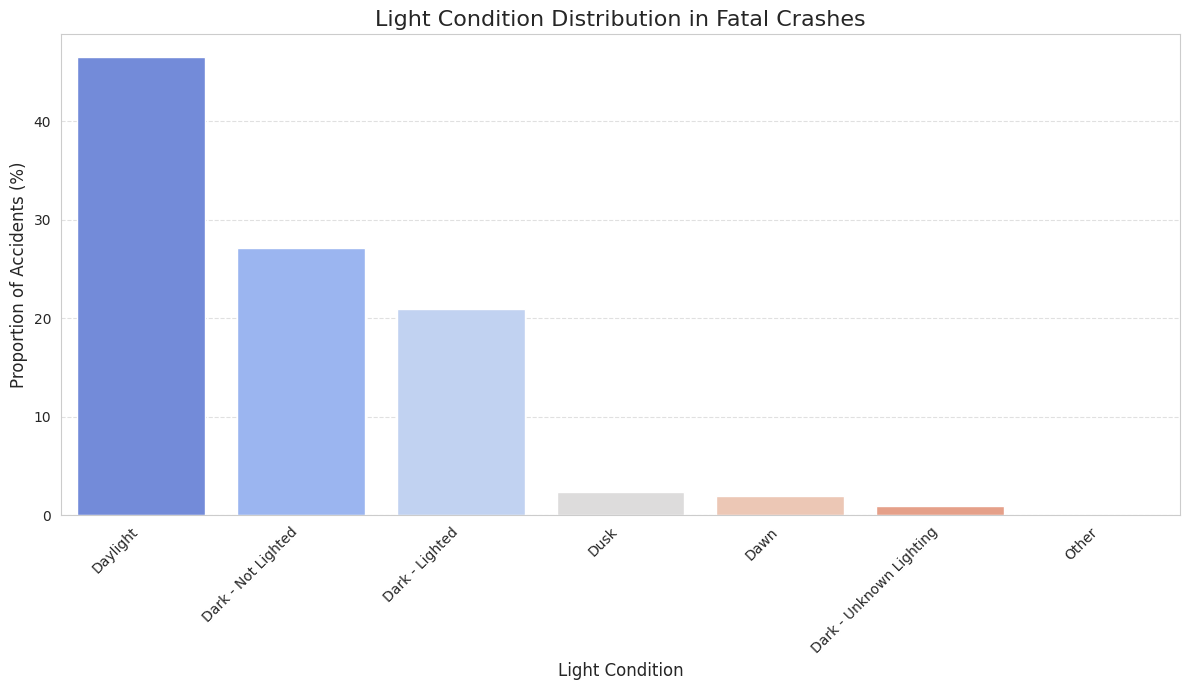

In [63]:
# Light conditions distribution
light_counts = df_final['LGT_COND'].value_counts().sort_values(ascending=False)
total_crashes = light_counts.sum()
light_percentage_map = (light_counts / total_crashes) * 100
print("\n--- Light Condition Distribution in Final Data (%) ---")
for condition, count in light_counts.items():
    print(f"{condition}: {light_percentage_map[condition]:.2f}% (Count: {count})")
# plotting
plt.figure(figsize=(12, 7))
ax = sns.barplot(
    x=light_percentage_map.index, 
    y=light_percentage_map.values, 
    palette='coolwarm',
    hue=light_percentage_map.index,
    legend=False
)
ax.set_title('Light Condition Distribution in Fatal Crashes', fontsize=16)
ax.set_xlabel('Light Condition', fontsize=12)
ax.set_ylabel('Proportion of Accidents (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### 4.8. EDA Summary and Key Findings

In [69]:
def generate_eda_summary(df_final):
    """Generates a comprehensive summary of key EDA findings using the final column names and plain text formatting."""
    
    # --- 1. OVERALL IMPAIRMENT RATES ---
    total_crashes = df_final.shape[0]
    alc_rate = df_final['ALC_USE'].mean() * 100
    drug_rate = df_final['DRUG_USE'].mean() * 100
    co_occurrence_rate = df_final['ALC_&_DRUG_USE'].mean() * 100
    
    # --- 2. TEMPORAL ANALYSIS ---
    hour_counts = df_final['CRASH_DATETIME'].dt.hour.value_counts()
    peak_hour = hour_counts.idxmax()
    peak_hour_count = hour_counts.max()
    
    # Calculate difference between Urban/Rural
    rural_mask = df_final['RUR_URB'] == 'Rural'
    urban_mask = df_final['RUR_URB'] == 'Urban'
    rural_impairment_rate = df_final[rural_mask]['ALC_USE'].mean() * 100
    urban_impairment_rate = df_final[urban_mask]['ALC_USE'].mean() * 100
    
    # --- 3. HARM AND VULNERABILITY ANALYSIS ---
    ped_cyc_fatal_rate = (df_final['NUM_NON_OCCUPANTS'] >= 1).mean() * 100
    avg_fatalities_per_crash = df_final['NUM_FATAL'].mean()
    high_harm_count = df_final[df_final['NUM_SERIOUS'] >= 2].shape[0]
    high_harm_rate = (high_harm_count / total_crashes) * 100
    
    # --- 4. WEATHER DISTRIBUTION (Top 2) ---
    weather_dist = df_final['WEATHER'].value_counts(normalize=True).mul(100).head(2)
    top_weather = weather_dist.index.tolist()
    
    # --- 5. FORMATTING THE SUMMARY TEXT (Plain Text) ---
    summary_text = f"""
SECTION 4.8. EDA Summary and Key Findings

=======================================================
A. Impairment Prevalence (Targets)

Based on {total_crashes:,} fatal crashes analyzed:
- Gross Alcohol Involvement Rate: {alc_rate:.2f}% of all crashes.
- Gross Drug Involvement Rate: {drug_rate:.2f}% of all crashes.
- Co-Occurrence Rate (ALC AND DRUG): {co_occurrence_rate:.2f}% of all crashes.

=======================================================
B. Temporal Patterns and Geographic Context

- Peak Risk Hour: The highest number of accidents occurs between {peak_hour}:00 and {peak_hour}:59, 
reflecting the common late-night risk period often associated with impaired driving.

- Urban vs. Rural Impairment (Alcohol): Impairment rates are generally consistent but slightly higher 
in Urban areas ({urban_impairment_rate:.2f}%) compared to Rural areas ({rural_impairment_rate:.2f}%), 
highlighting uniform risk across different road types.

- Weather Conditions: The vast majority of fatal crashes occur during optimal conditions: {top_weather[0]} 
({weather_dist.iloc[0]:.1f}%) and {top_weather[1]} ({weather_dist.iloc[1]:.1f}%). This reinforces that 
driver behavior, rather than environmental conditions, is the dominant factor in fatal crashes.

=======================================================
C. Harm and Vulnerability

These metrics provide context beyond the mandatory single fatality per crash:

- Vulnerable Road User Fatalities (Non-Occupant Involvement): {ped_cyc_fatal_rate:.2f}% of all fatal 
crashes involved a Pedestrian or Cyclist (Non-Occupant).

- Average Fatalities per Crash: The average number of people killed per crash is {avg_fatalities_per_crash:.2f} 
(Note: Always >= 1.00).

- High Concurrent Harm (Serious Injuries): {high_harm_rate:.2f}% of crashes resulted in two or more 
seriously injured persons (Severity A), indicating highly catastrophic, multi-person events.

=======================================================
"""
    
    print(summary_text)

# --- Execution ---
generate_eda_summary(df_final)


SECTION 4.8. EDA Summary and Key Findings

A. Impairment Prevalence (Targets)

Based on 144,482 fatal crashes analyzed:
- Gross Alcohol Involvement Rate: 6.25% of all crashes.
- Gross Drug Involvement Rate: 30.30% of all crashes.
- Co-Occurrence Rate (ALC AND DRUG): 3.33% of all crashes.

B. Temporal Patterns and Geographic Context

- Peak Risk Hour: The highest number of accidents occurs between 21:00 and 21:59, 
reflecting the common late-night risk period often associated with impaired driving.

- Urban vs. Rural Impairment (Alcohol): Impairment rates are generally consistent but slightly higher 
in Urban areas (6.41%) compared to Rural areas (5.99%), 
highlighting uniform risk across different road types.

- Weather Conditions: The vast majority of fatal crashes occur during optimal conditions: Clear 
(76.7%) and Cloudy (13.5%). This reinforces that 
driver behavior, rather than environmental conditions, is the dominant factor in fatal crashes.

C. Harm and Vulnerability

These me


---

## 5. Save Preprocessed Dataset with Modified Data Types and New Features

This code saves the final processed DataFrame (`df_final`) to a **Parquet** file. Parquet is highly recommended over CSV for large dataframes as it preserves data types (preventing issues like those we fixed with `INJ_SEV`) and offers excellent compression and read/write performance.



In [14]:
print(df_final.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144482 entries, 0 to 144481
Data columns (total 47 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ST_CASE              144482 non-null  int64  
 1   STATE                144482 non-null  object 
 2   PERMVIT              144482 non-null  int64  
 3   PERNOTMVIT           144482 non-null  int64  
 4   VE_TOTAL             144482 non-null  int64  
 5   VE_FORMS             144482 non-null  int64  
 6   PVH_INVL             144482 non-null  int64  
 7   HARM_EV              144482 non-null  object 
 8   MAN_COLL             144482 non-null  object 
 9   RELJCT2              144482 non-null  object 
 10  RUR_URB              144482 non-null  object 
 11  TYP_INT              144482 non-null  object 
 12  REL_ROAD             144482 non-null  object 
 13  SCH_BUS              144482 non-null  object 
 14  RAIL                 144482 non-null  object 
 15  LGT_COND         

In [24]:
PROCESSED_DIR = Path('data/processed')

def save_preprocessed_dataset(df: pd.DataFrame, PROCESSED_DIR: Path = PROCESSED_DIR):
    """
    Saves the final preprocessed DataFrame (df_final) to a compressed Parquet file,
    which preserves data types and is ideal for fast loading.
    """
    # 1. Define the output file path
    output_filename = 'FARS_preprocessed.parquet'
    output_path = PROCESSED_DIR / output_filename
    rel_out = rel_path(output_path)
    
    # Ensure the directory exists
    os.makedirs(PROCESSED_DIR, exist_ok=True)

    print(f"Attempting to save {df.shape} to {output_filename}!")

    try:
        # Use Parquet with Snappy compression for efficiency
        df.to_parquet(output_path, compression='snappy')
        print(f"\n    - Successfully saved preprocessed data to: {rel_out}")
        print(f"    - File size: {os.path.getsize(output_path) / (1024 * 1024):.2f} MB")
        print("-------------------------------------------------------")
    except Exception as e:
        print(f"❌ ERROR saving data to Parquet: {e}")

save_preprocessed_dataset(df_final)

Attempting to save (144482, 47) to FARS_preprocessed.parquet!

    - Successfully saved preprocessed data to: /FDS_G5_PROJECT/data/processed/FARS_preprocessed.parquet
    - File size: 3.58 MB
-------------------------------------------------------


### 5.1. Load Preprocessed Dataset from Saved Parquet

This section provides a simple function to load the data back quickly, checking if the file exists before attempting to read.

In [4]:
PROCESSED_DIR = Path('data/processed')

def load_preprocessed_dataset(processed_dir: Path = PROCESSED_DIR):
    """
    Loads the final preprocessed DataFrame from the saved Parquet file.
    Returns the DataFrame or None if the file is not found.
    """
    input_filename = 'FARS_preprocessed.parquet'
    input_path = processed_dir / input_filename
    
    print("-------------------------------------------------------")
    print("Load from Saved Dataset")
    
    if input_path.exists():
        try:
            # Read Parquet is extremely fast and preserves dtypes
            df = pd.read_parquet(input_path)
            print("Successfully loaded preprocessed data from disk.")
            print(f"Loaded DataFrame shape: {df.shape}")
            return df
        except Exception as e:
            print(f"❌ ERROR reading Parquet file: {e}")
            return None
    else:
        print(f"⚠️ Preprocessed file not found at: {input_path}")
        print("Please run the full preprocessing step first.")
        return None

if ('df_final' not in globals()) or (df_final is None):
    print("Error: 'df_final' not found in the current environment.")
    print("Proceeding to load the preprocessed dataset from disk...")

    df_final = load_preprocessed_dataset(PROCESSED_DIR)

if df_final is not None: 
    print("'df_final' is loaded in the current environment.")
else:
    print("Failed to load 'df_final'. Please ensure the preprocessing step was completed successfully.")

'df_final' is loaded in the current environment.


In [ ]:
display(df_final.info())

In [29]:
# 1. Identify all categorical columns (object and category dtypes)
# We also include string dtypes, as they often come from object conversion.
categorical_cols = df_final.select_dtypes(include=['object', 'category', 'string']).columns.tolist()

# 2. Calculate cardinality and determine encoding strategy
cardinality_data = []
OHE_THRESHOLD = 10

for col in categorical_cols:
    unique_count = df_final[col].nunique()
    
    if unique_count < OHE_THRESHOLD:
        cardinality = "Low Cardinality"
        rec_strategy = "OHE"
        # Limit value list to avoid excessive output, especially if cardinality is close to 10
        values = df_final[col].unique().tolist()
    else:
        cardinality = "High Cardinality"
        rec_strategy = "WOE"
        values = None # Don't display large lists
        
    cardinality_data.append({
        'Feature': col,
        'Cardinality': unique_count,
        'Encoding_Strategy': rec_strategy,
        'Sample_Values': values
    })

# 3. Create the DataFrame
df_cardinality = pd.DataFrame(cardinality_data)

# Print the structured result
print("\n--- Categorical Feature Cardinality and Encoding Strategy ---")
display(df_cardinality)


--- Categorical Feature Cardinality and Encoding Strategy ---


Feature  Cardinality Encoding_Strategy  \
0            STATE           51               WOE   
1          HARM_EV           55               WOE   
2         MAN_COLL           10               WOE   
3          RELJCT2           15               WOE   
4          RUR_URB            4               OHE   
5          TYP_INT            9               OHE   
6         REL_ROAD           11               WOE   
7          SCH_BUS            2               OHE   
8             RAIL          517               WOE   
9         LGT_COND            7               OHE   
10         WEATHER           11               WOE   
11           ROUTE            5               OHE   
12        FUNC_SYS            7               OHE   
13  CRASH_DATETIME       137702               WOE   

                                        Sample_Values  
0                                                None  
1                                                None  
2                                                None  
3                                                None  
4   [Rural, Urban, Unknown, Trafficway Not in Stat...  
5   [Not an Intersection, Four-Way Intersection, T...  
6                                                None  
7                                           [No, Yes]  
8                                                None  
9   [Dawn, Dark - Not Lighted, Daylight, Dark - Li...  
10                                               None  
11  [Interstate, US/State Hwy, County Rd, Local St...  
12  [Interstate, Principal Arterial, Major Collect...  
13                                               None

## 6. Feature Transformation and Selection Pipeline

This critical phase prepares the final feature set for the predictive models. It employs a rigorous, multi-stage selection process designed to handle high-cardinality categorical data and identify the most causally relevant predictors.

### 6.1. Feature Encoding: Hybrid Strategy

To handle the mix of categorical variables without exploding dimensionality or losing information, we employ a hybrid encoding strategy:

*   **One-Hot Encoding (OHE):** Applied to **low-cardinality** features (e.g., `RUR_URB`). It maps a categorical variable with $K$ categories into $K$ binary columns.
*   **Weight of Evidence (WOE):** Applied to **high-cardinality** features (e.g., `STATE`, `Make`). WOE transforms categories into a continuous measure of risk, defined as the natural log of the ratio of the proportion of non-events (negatives) to events (positives):

$$
WOE_i = \ln \left( \frac{P(\text{Non-Event}|X=i)}{P(\text{Event}|X=i)} \right)
$$

This transformation creates a monotonic relationship with the target log-odds, making it ideal for logistic regression.

### 6.2. L1 Regularization (Lasso)

For initial dimensionality reduction, we utilize **Lasso (Least Absolute Shrinkage and Selection Operator)**. Lasso introduces an $L1$ penalty term to the logistic regression loss function, which shrinks the coefficients of less important features to exactly zero.

The objective function minimized is:

$$
\min_{w} \left( \frac{1}{2n} || y - Xw ||_2^2 + \alpha || w ||_1 \right)
$$

Where:
*   $|| y - Xw ||_2^2$ is the prediction error.
*   $\alpha$ is the regularization strength.
*   $|| w ||_1 = \sum |w_j|$ is the sum of absolute coefficients.

Features with non-zero coefficients ($w_j \neq 0$) are retained for the next stage.

### 6.3. Bayesian Structure Learning (Markov Blanket)

To filter for **causal relevance** rather than just correlation, we employ Bayesian Structure Learning. We learn a Directed Acyclic Graph (DAG) that represents the probabilistic dependencies among variables, using **Hill Climb Search (HC)** with **BIC** score as the scoring metric.

- **HC**: An iterative algorithm that starts with an initial graph and makes local changes (adding, removing, or reversing edges) to maximize the BIC score until no further improvements can be made.

- **BIC Score**: The Bayesian Information Criterion balances model fit and complexity, defined as:
$$
BIC = \ln(n)k - 2\ln(\hat{L})
$$
Where:
*   $n$ is the number of data points.
*   $k$ is the number of parameters in the model.
*   $\hat{L}$ is the maximized value of the likelihood function of the model.

From this graph, we extract the **Markov Blanket** of our target variable $T$. The Markov Blanket $MB(T)$ consists of the target's parents, children, and spouses (parents of children). It satisfies the conditional independence property:

$$
P(T \mid MB(T), X_{\text{others}}) = P(T \mid MB(T))
$$

This means that given the Markov Blanket, the target is statistically independent of all other variables in the dataset. This provides the theoretical minimal set of features required for optimal prediction.

#### 6.3.1. Methodology considerations

- **Data Discretization:** f To simplify structure learning, continuous features (e.g., WOE-transformed variables) are discretized using techniques such as equal-width or equal-frequency binning. This ensures compatibility with algorithms that require categorical inputs.
- **Computational Complexity:** Structure learning can be computationally expensive, particularly when dealing with a large number of features. To address this, dimensionality reduction techniques like Lasso are applied beforehand to reduce the feature space and improve efficiency.
- **Stability of Structure:** The learned DAG may vary across different runs due to factors such as random initialization, edge selection probabilities, or random seeds. While this implementation uses a single run for simplicity, ensemble approaches or averaging across multiple learned structures can be employed in practice to enhance robustness and reliability.
- **Why just Markov Blanket?** The Markov Blanket provides the minimal set of features needed for optimal prediction, balancing model complexity and interpretability.
- **Do we get true causal relations?** Not necessarily. While Bayesian Structure Learning aims to uncover causal relationships, the results depend heavily on the data quality, underlying assumptions, and the specific algorithm used. The Markov Blanket identifies statistically relevant features but does not guarantee causality without further validation, for example through domain knowledge or counterfactual analysis.

Target: ALC_&_DRUG_USE
WOE Features (7): ['STATE', 'HARM_EV', 'MAN_COLL', 'RELJCT2', 'REL_ROAD', 'RAIL', 'WEATHER']
OHE Features (6): ['RUR_URB', 'TYP_INT', 'SCH_BUS', 'LGT_COND', 'ROUTE', 'FUNC_SYS']
Number of features before encoding: 41
Encoding complete:
	 - New feature count: 69

--- Running Lasso (L1) Feature Selection ---
Features before Lasso: 69
Features selected by Lasso: 51

--- Bayesian Structure Learning (Markov Blanket) ---

    - Configuring 250 maximum iterations per target

Processing Target: 'ALC_USE'


  0%|          | 0/250 [00:00<?, ?it/s]


Structure learning for ALC_USE completed in 1m48s.

Target: 'ALC_USE'
  Markov Blanket Size: 5
  Features: ['HOUR_COS', 'STATE', 'YEAR', 'LGT_COND_Dark - Lighted', 'RUR_URB_Rural']
Generating Graph Visualization for ALC_USE...
Graph saved to EDA_reports/Structure_learning/ALC_USE_structure.png


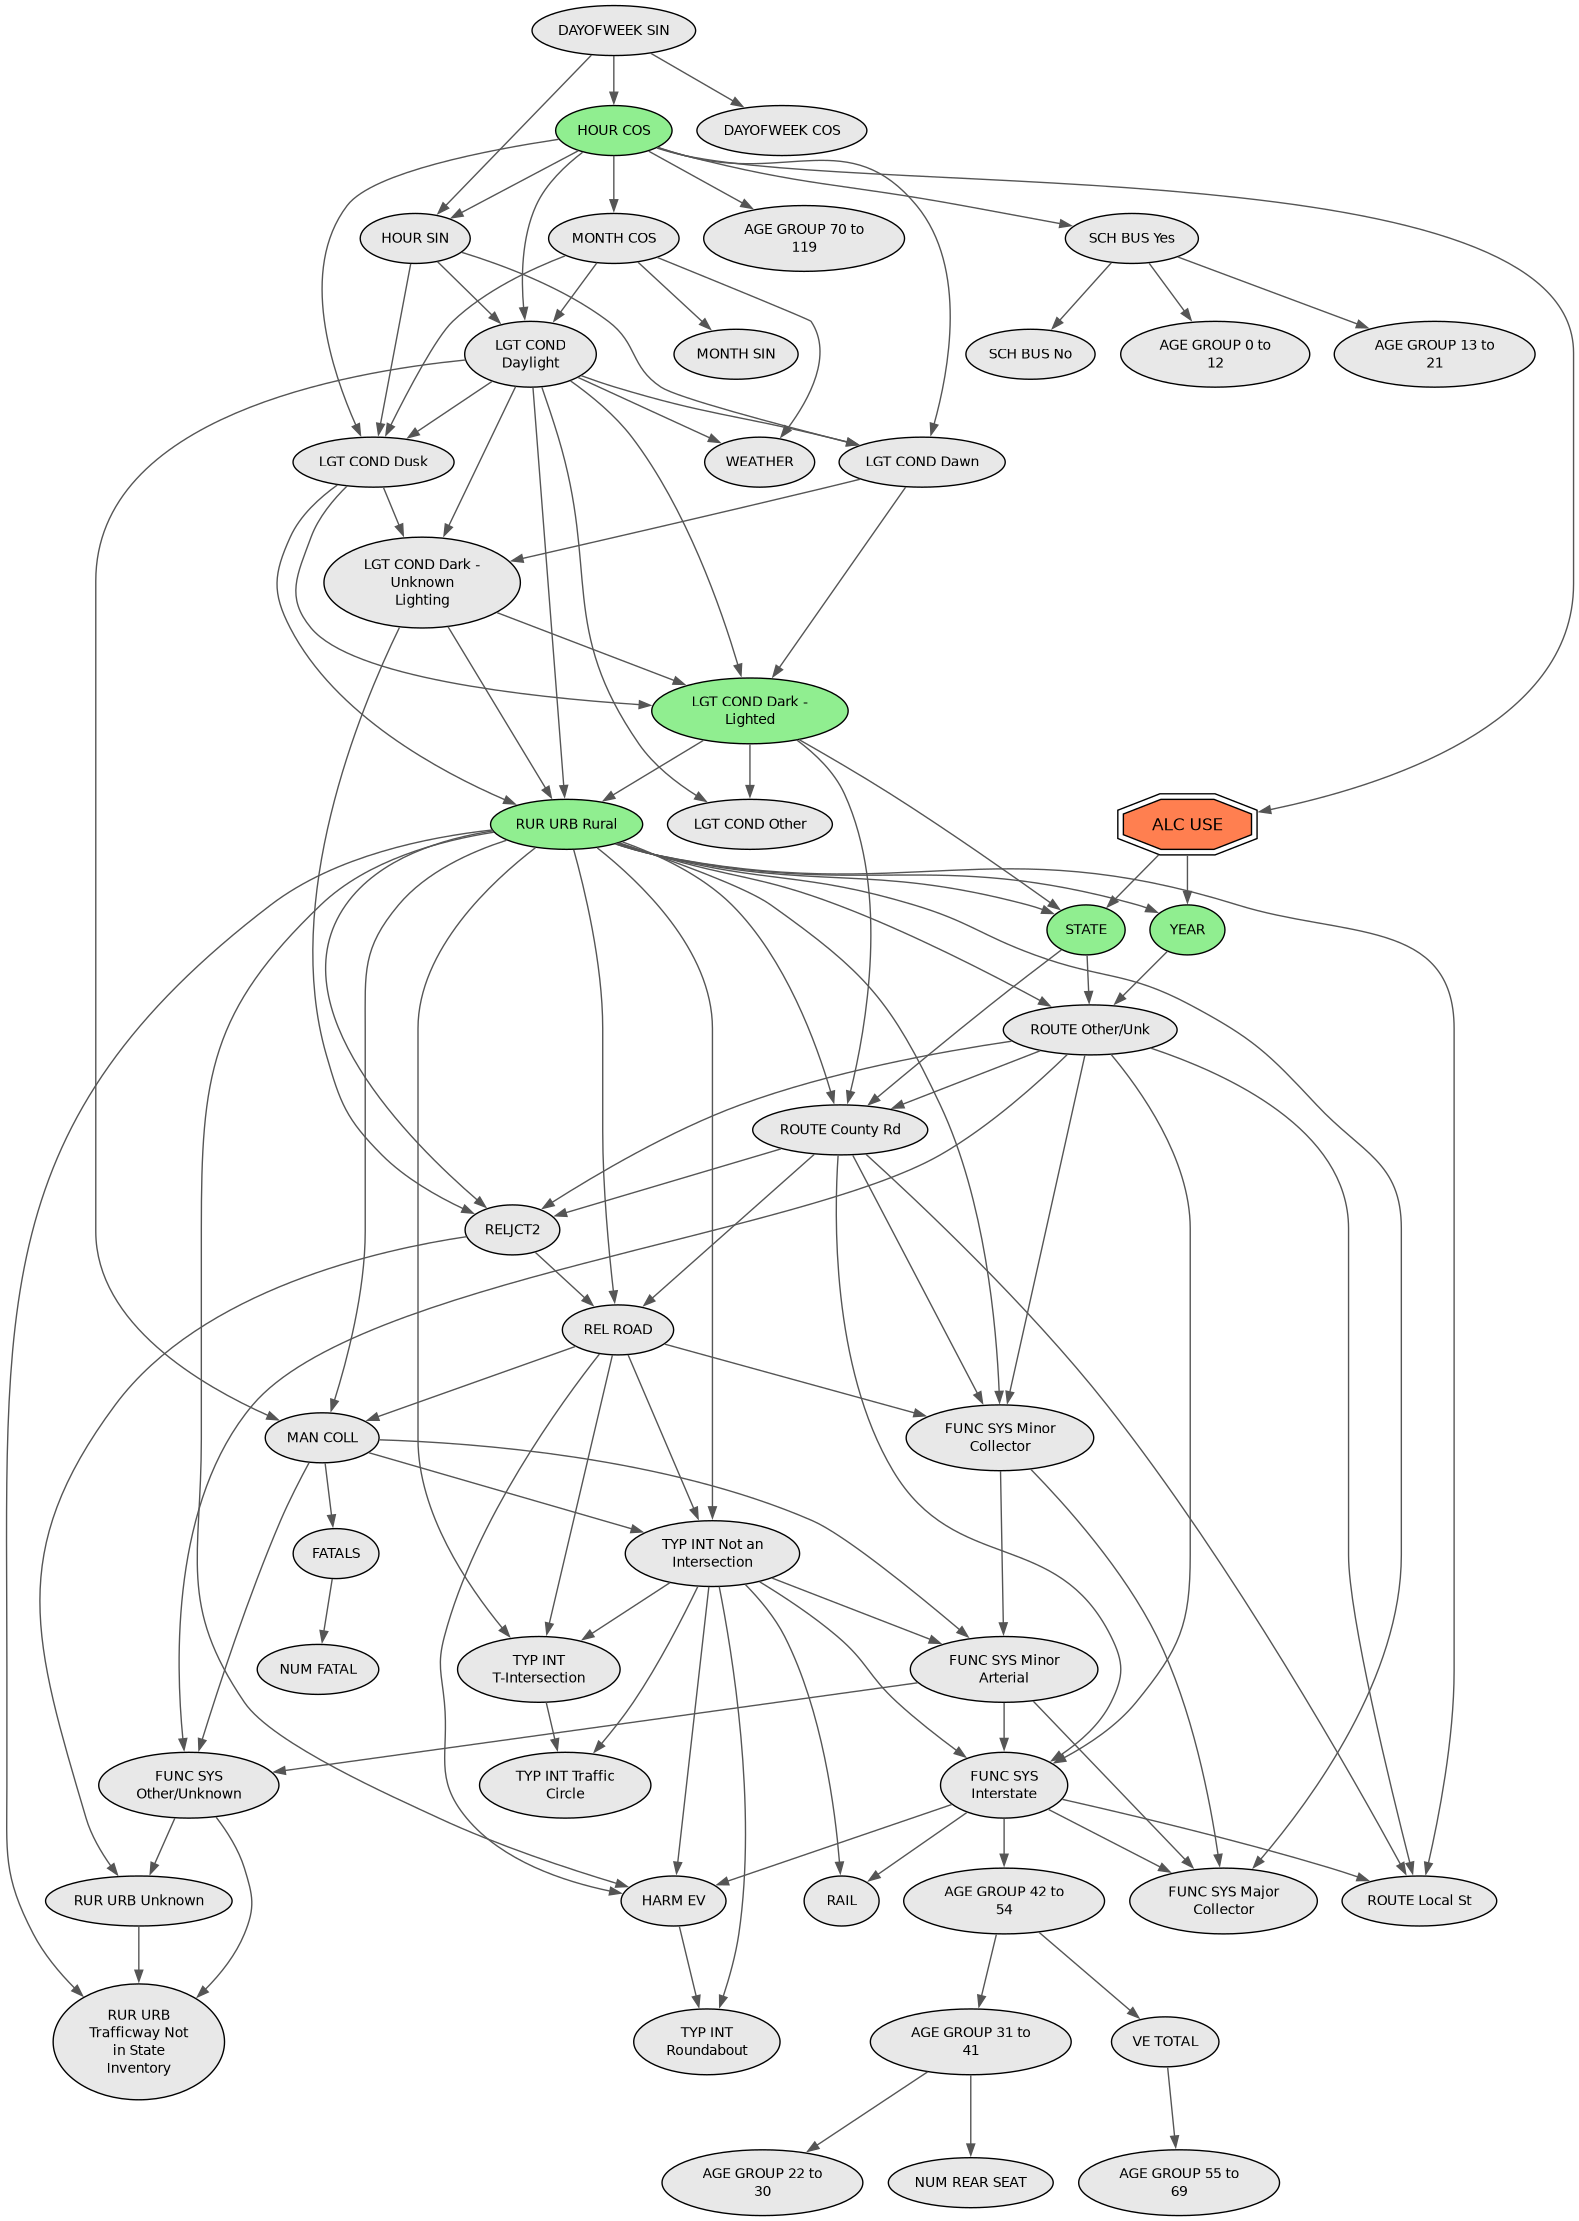


Processing Target: 'DRUG_USE'


  0%|          | 0/250 [00:00<?, ?it/s]


Structure learning for DRUG_USE completed in 1m48s.

Target: 'DRUG_USE'
  Markov Blanket Size: 7
  Features: ['HOUR_COS', 'ROUTE_Other/Unk', 'STATE', 'YEAR', 'LGT_COND_Dark - Lighted', 'ROUTE_Local St', 'RUR_URB_Rural']
Generating Graph Visualization for DRUG_USE...
Graph saved to EDA_reports/Structure_learning/DRUG_USE_structure.png


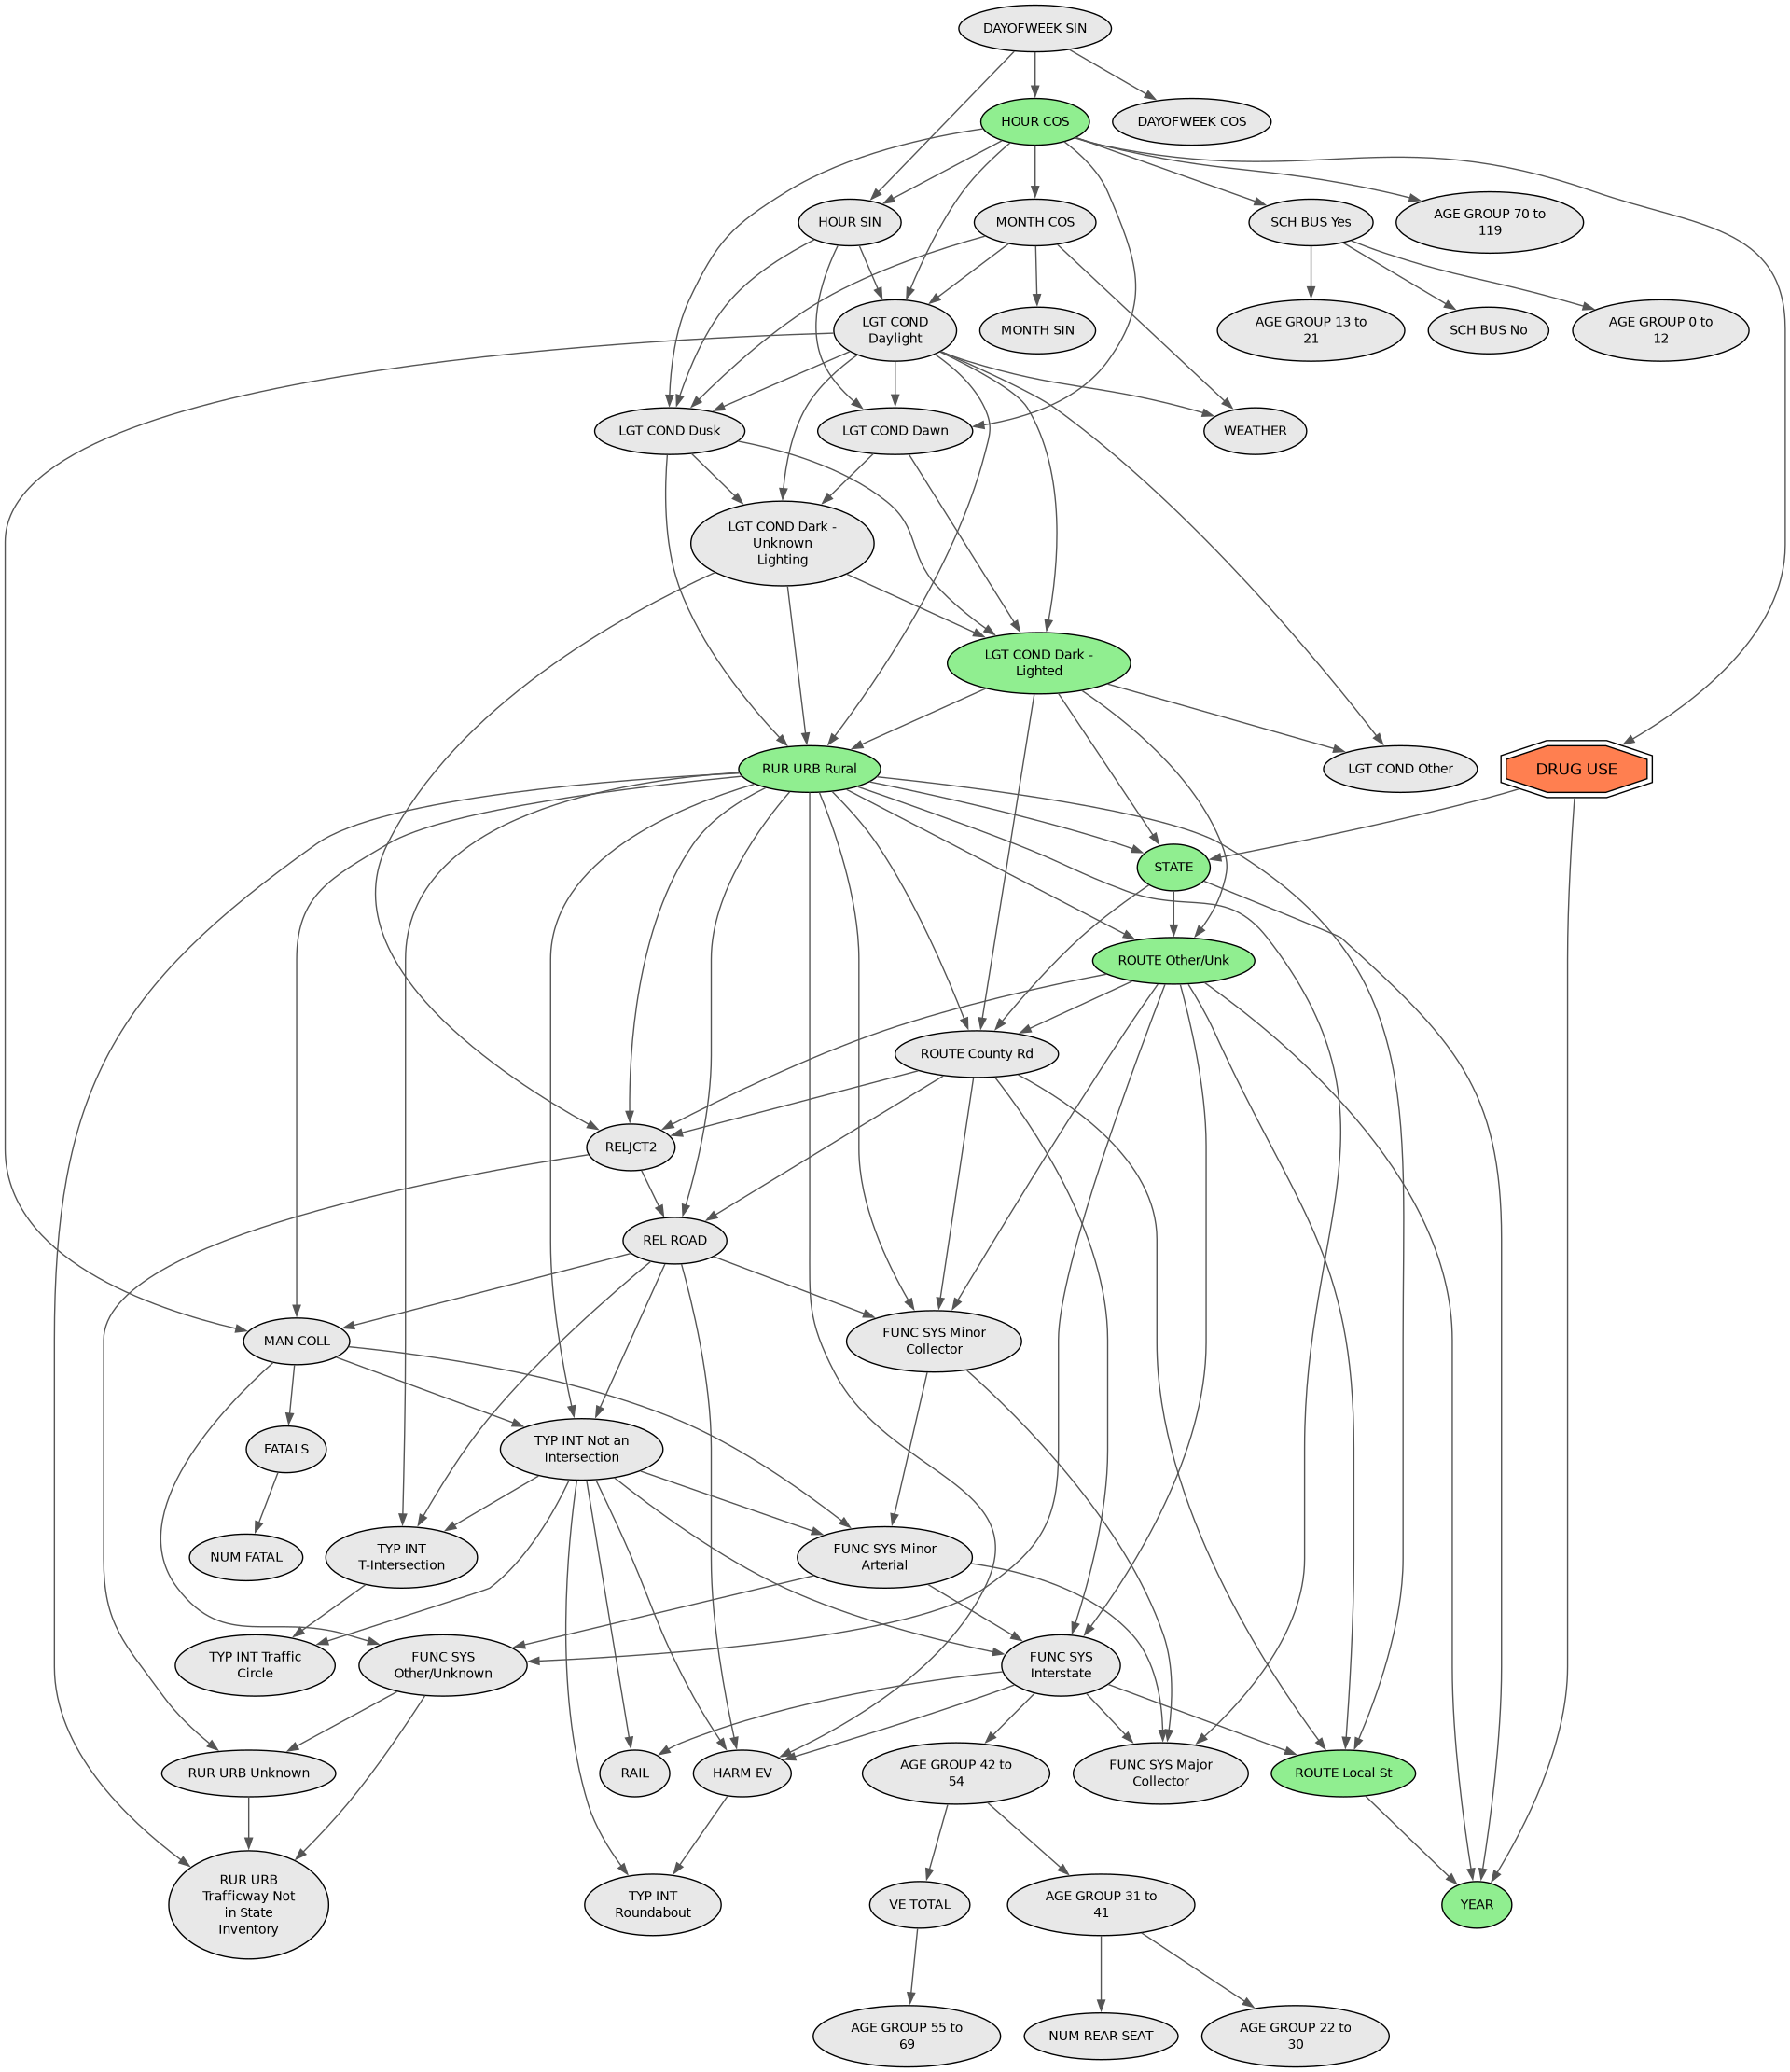


Processing Target: 'ALC_&_DRUG_USE'


  0%|          | 0/250 [00:00<?, ?it/s]


Structure learning for ALC_&_DRUG_USE completed in 1m44s.

Target: 'ALC_&_DRUG_USE'
  Markov Blanket Size: 4
  Features: ['HOUR_COS', 'STATE', 'LGT_COND_Dark - Lighted', 'RUR_URB_Rural']
Generating Graph Visualization for ALC_&_DRUG_USE...
Graph saved to EDA_reports/Structure_learning/ALC_&_DRUG_USE_structure.png


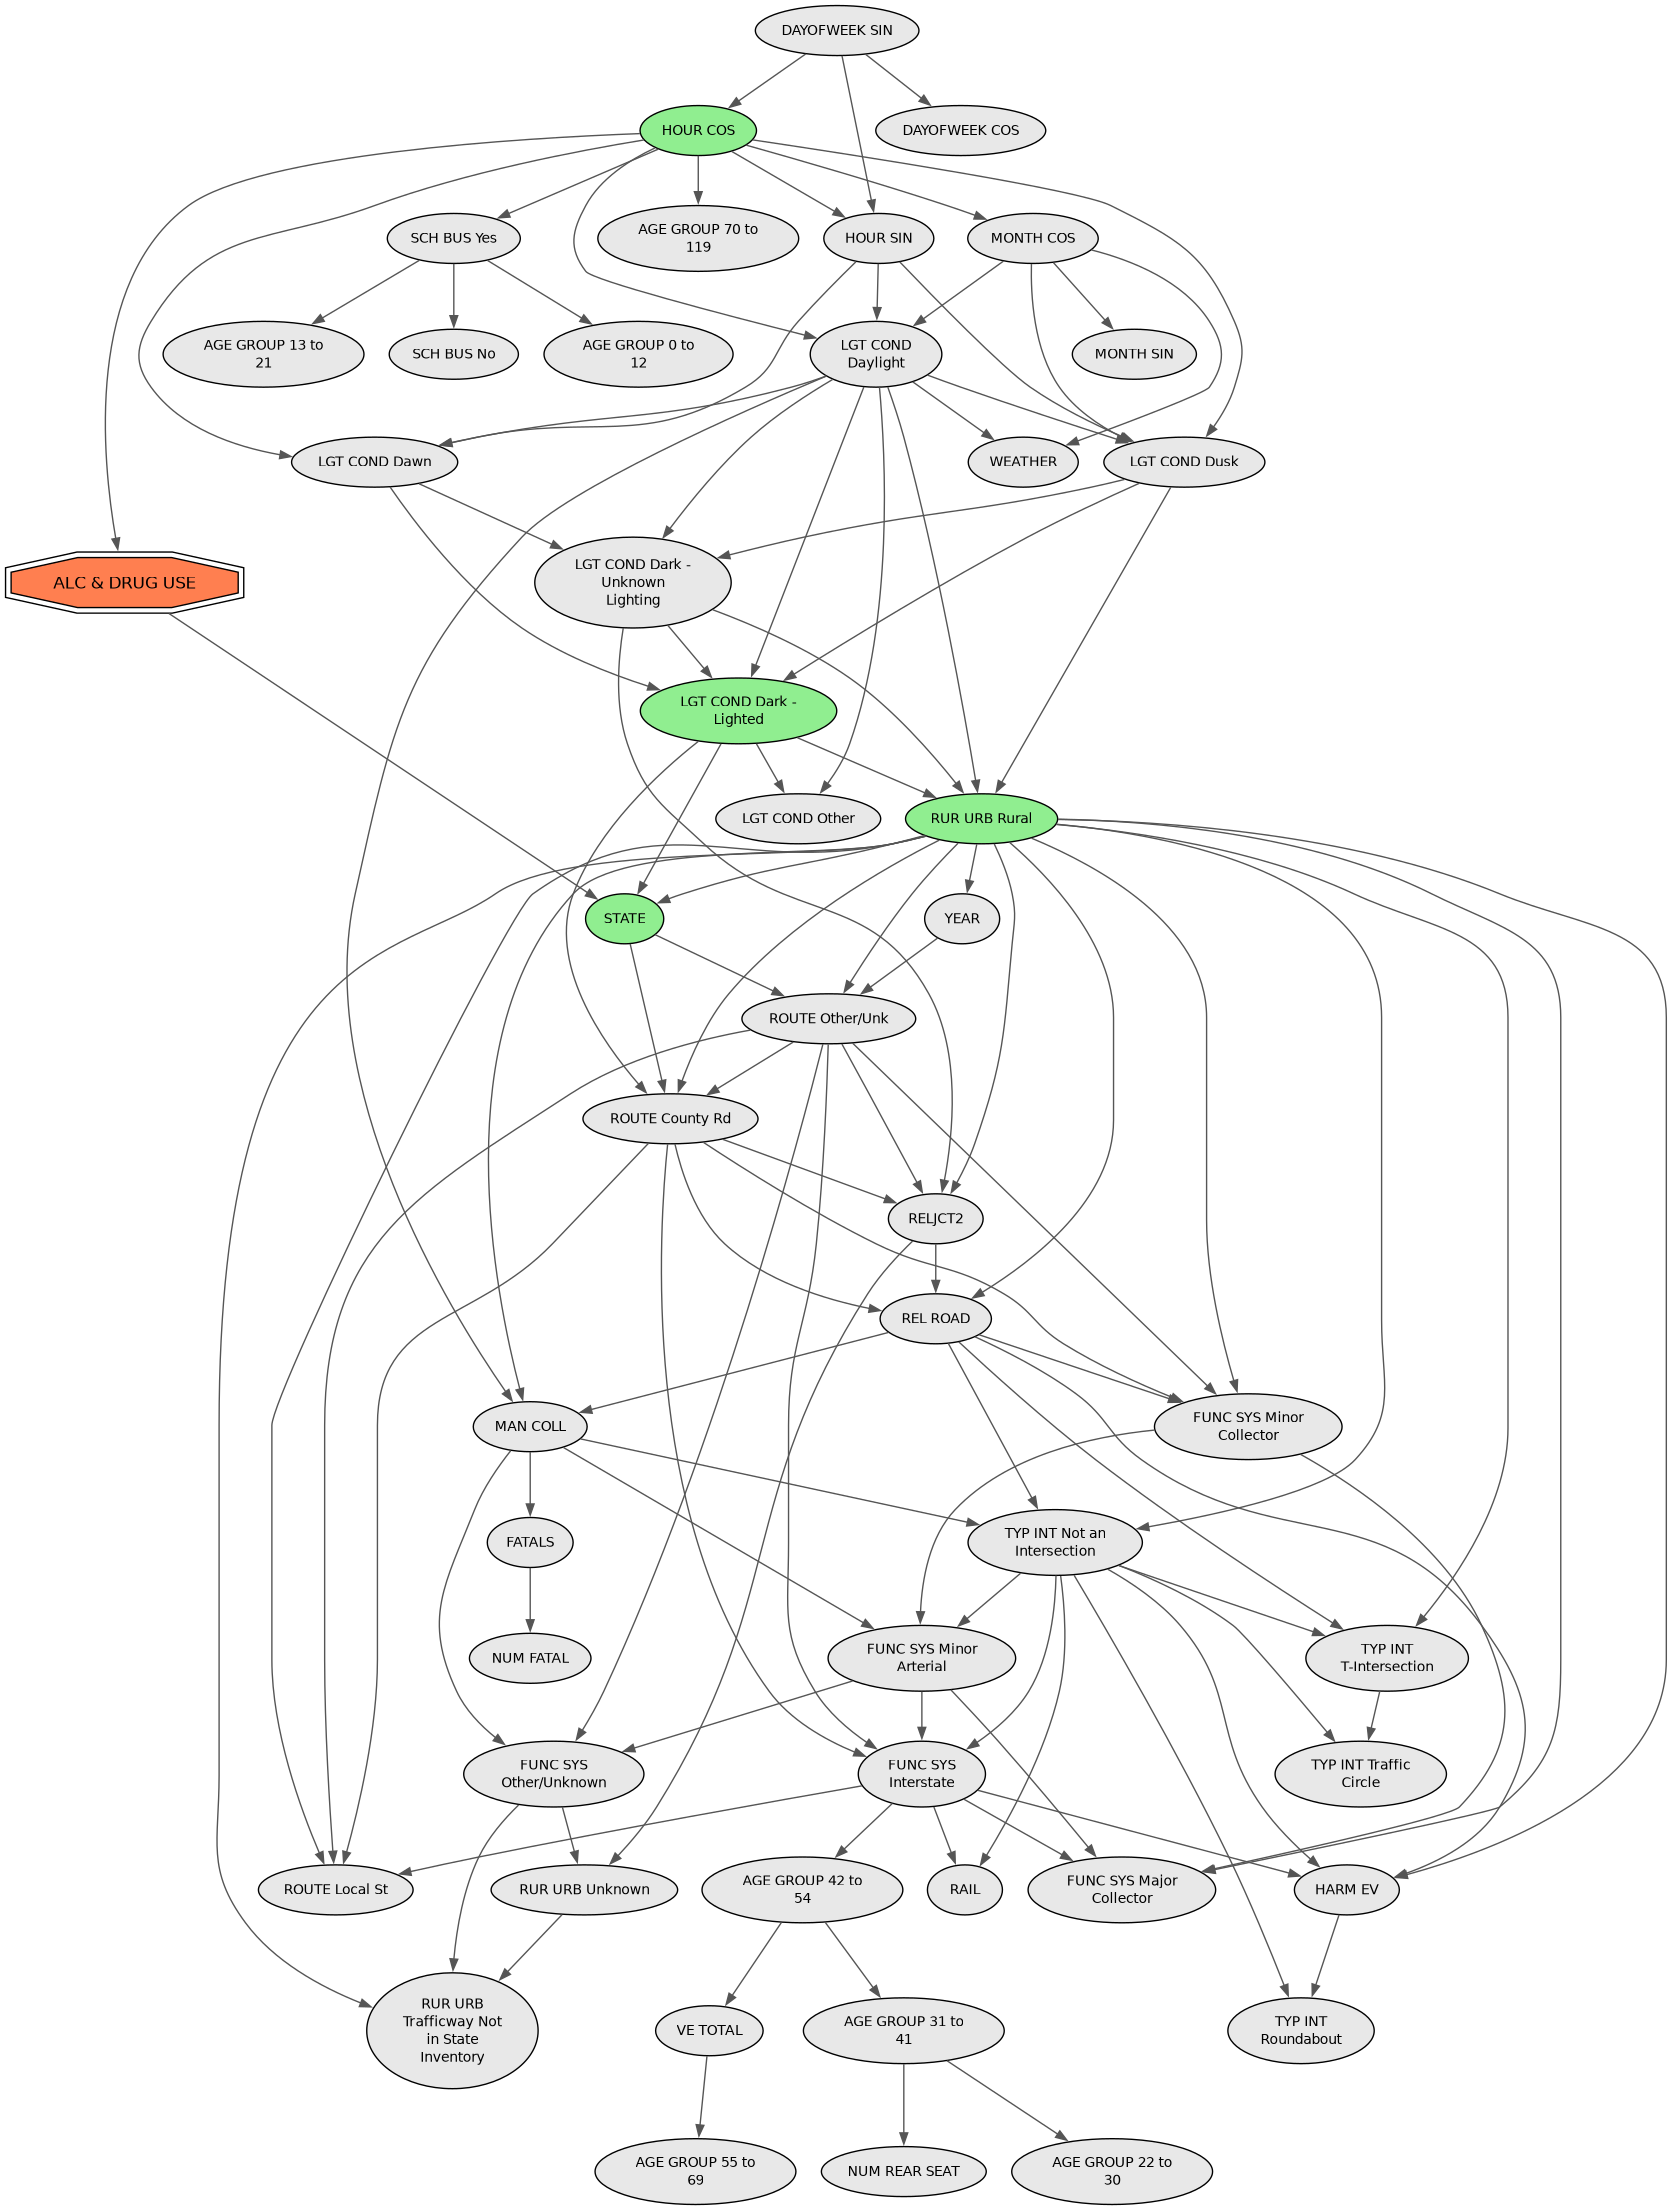



--- FINAL FEATURE SELECTION SUMMARY ---
Features Selected by Lasso (Used for Modeling): 51
Union of Markov Blankets (All Targets): 7
Global Markov Blanket Features (Encoded): ['HOUR_COS', 'ROUTE_Other/Unk', 'STATE', 'YEAR', 'LGT_COND_Dark - Lighted', 'ROUTE_Local St', 'RUR_URB_Rural']
Global Markov Blanket Features (Original): ['HOUR_COS', 'ROUTE', 'RUR_URB', 'STATE', 'LGT_COND', 'YEAR']


In [ ]:
# --- Configuration ---
TARGET_COL = 'ALC_&_DRUG_USE'
ALL_TARGETS = ['ALC_USE', 'DRUG_USE', 'ALC_&_DRUG_USE']

# --- 1. Dynamic Feature Grouping ---
def get_dynamic_feature_groups(df):
    """Dynamically determines WOE and OHE features based on cardinality threshold."""
    
    # Identify all categorical columns
    categorical_cols = df.select_dtypes(include=['object', 'category', 'string']).columns.tolist()
    
    # Exclude non-predictive/date columns before grouping
    non_feature_cols = ['ST_CASE', 'CRASH_DATETIME', 'MAX_INJ_SEV', 'ALC_USE', 'DRUG_USE', 'ALC_&_DRUG_USE']
    
    # Remove columns that have already been excluded or are targets
    categorical_features = [col for col in categorical_cols if col not in non_feature_cols]

    OHE_THRESHOLD = 10
    WOE_FEATURES = []
    OHE_FEATURES = []
    
    for col in categorical_features:
        unique_count = df[col].nunique()
        
        if unique_count < OHE_THRESHOLD:
            OHE_FEATURES.append(col)
        else:
            WOE_FEATURES.append(col)
            
    # Define EXCLUDE_COLS based on the fixed IDs and targets
    EXCLUDE_COLS = non_feature_cols
    
    return WOE_FEATURES, OHE_FEATURES, EXCLUDE_COLS

WOE_FEATURES, OHE_FEATURES, EXCLUDE_COLS = get_dynamic_feature_groups(df_final)

print(f"Target: {TARGET_COL}")
print(f"WOE Features ({len(WOE_FEATURES)}): {WOE_FEATURES}")
print(f"OHE Features ({len(OHE_FEATURES)}): {OHE_FEATURES}")

# --- 2. Encoding Pipeline ---
def encode_features_pipeline(df, woe_features, ohe_features, target_col):
    """
    Applies WOE to high-cardinality features and OHE to low-cardinality features.
    """
    X = df.drop(columns=EXCLUDE_COLS).copy() 
    if target_col in X.columns:
        X = X.drop(columns=[target_col])
        
    y = df[target_col].copy()
    
    # Define ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('woe', ce.WOEEncoder(cols=woe_features, regularization=1.0), woe_features),
            ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ohe_features),
        ],
        remainder='passthrough', # Keep numeric features as is
        verbose_feature_names_out=False
    ).set_output(transform='pandas')

    print("Number of features before encoding:", X.shape[1])
    X_processed = preprocessor.fit_transform(X, y)
    
    print(f"Encoding complete:\n\t - New feature count: {X_processed.shape[1]}")
    return X_processed, y

X_encoded, y_target = encode_features_pipeline(df_final, WOE_FEATURES, OHE_FEATURES, TARGET_COL)

# --- 3. Lasso Feature Selection ---
def select_features_with_lasso(X_data, y_target):
    """
    Performs feature selection using L1 regularization (Lasso).
    """
    print("\n--- Running Lasso (L1) Feature Selection ---")
    
    # Scale Data (Essential for penalized models)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_data)
    
    # C=0.05 applies strong regularization to reduce feature count significantly
    lasso_model = LogisticRegression(
        C=0.05, 
        penalty="l1", 
        solver="liblinear", 
        random_state=42
    ) 
    
    selector = SelectFromModel(lasso_model).fit(X_scaled, y_target)
    selected_features = X_data.columns[selector.get_support()].tolist()
    
    print(f"Features before Lasso: {X_data.shape[1]}")
    print(f"Features selected by Lasso: {len(selected_features)}")
    
    return selected_features

selected_lasso_features = select_features_with_lasso(X_encoded, y_target)

# --- 4. Bayesian Network Structure Learning and Markov Blanket Analysis ---
def analyze_markov_blanket(df_original, X_encoded, selected_features, targets):
    """
    Learns a separate Bayesian Network structure for EACH target to avoid data leakage between targets.
    Identifies the Markov Blanket for each target and returns the union of all relevant features.
    """
    # Suppress pgmpy INFO logs regarding datatype inference.
    # pgmpy sees integer codes as 'Numerical' (N), but BIC treats them as discrete states, which is correct.
    logging.getLogger('pgmpy').setLevel(logging.WARNING)

    # Define output directory for graphs
    graph_output_dir = Path("EDA_reports/Structure_learning")
    graph_output_dir.mkdir(parents=True, exist_ok=True)

    max_iter = 250

    print("\n--- Bayesian Structure Learning (Markov Blanket) ---")
    
    print(f"\n    - Configuring {max_iter} maximum iterations per target")
    results_summary = {}
    union_mb_features = set() # Initialize OUTSIDE the loop to accumulate across targets

    for target in targets:
        print(f"\n{'='*60}")
        print(f"Processing Target: '{target}'")
        print(f"{'='*60}")

        # 1. Construct dataset: Selected Features + ONLY the current target
        # This prevents 'ALC_USE' predicting 'ALC_&_DRUG_USE' directly (Leakage prevention)
        df_learning = X_encoded[selected_features].copy()
        df_learning[target] = df_original[target].values
        
        # Preprocessing for pgmpy: Ensure ALL data is discrete (integer codes)
        for col in df_learning.columns:
            # 1. Discretize high cardinality numerical columns
            if df_learning[col].nunique() > 10: 
                # Use 5 bins for discretization
                df_learning[col] = pd.cut(df_learning[col], bins=5, labels=False, duplicates='drop')
            
            # 2. Force everything to integer codes (0, 1, 2...)
            df_learning[col] = df_learning[col].astype('category').cat.codes
            
        # Define the search method
        hc = HillClimbSearch(df_learning)
        
        # Estimate model
        # Measure time
        start_time = time.time()
        best_model = hc.estimate(
            scoring_method=BIC(df_learning),
            max_indegree=4,
            max_iter=max_iter,
            show_progress=True # Shows iterations in output
        )
        end_time = time.time()
        elapsed_time = end_time - start_time
        # Format time string with minutes and seconds
        minutes = int(elapsed_time // 60)
        seconds = int(elapsed_time % 60)
        time_str = f"{minutes}m{seconds}s"
        
        print(f"\nStructure learning for {target} completed in {time_str}.")
        
        # Create Bayesian Network object
        bn_model = DiscreteBayesianNetwork(best_model.edges())
        
        # --- Retrieve Markov Blanket (Calculated BEFORE visualization for coloring) ---
        try:
            if target in bn_model.nodes():
                mb = bn_model.get_markov_blanket(target)
                mb_list = list(mb)
                results_summary[target] = mb_list
                union_mb_features.update(mb_list)
                
                print(f"\nTarget: '{target}'")
                print(f"  Markov Blanket Size: {len(mb_list)}")
                print(f"  Features: {mb_list}")
            else:
                print(f"\nTarget: '{target}' - Not found in learned structure (Independent node).")
                mb_list = []
                results_summary[target] = []
        except Exception as e:
            print(f"Could not retrieve Markov Blanket for {target}: {e}")
            mb_list = []
            results_summary[target] = []
        
# --- Visualization with Graphviz (High Quality) ---
        try:        
            print(f"Generating Graph Visualization for {target}...")
            
            # Convert NetworkX graph to PyGraphviz AGraph
            # pgmpy models inherit from nx.DiGraph, so we can use nx_agraph
            if len(bn_model.nodes()) > 0:
                A = nx.nx_agraph.to_agraph(bn_model)
                
                # Set global graph attributes
                A.graph_attr.update(dpi='100', rankdir='TB', splines='true', overlap='false')
                A.node_attr.update(style='filled', fontname='Helvetica', fontsize='10')
                A.edge_attr.update(color='#555555', arrowsize='0.8')
                # Color Nodes based on Markov Blanket
                for node in A.nodes():
                    n = A.get_node(node)
                    # Cast to Any to satisfy static type checkers (pygraphviz Node attributes are dynamic)
                    n_any = cast(Any, n)
                    
                    # Clean up label (wrap text)
                    clean_name = node.replace('_', ' ')
                    wrapped_name = "\\n".join(textwrap.wrap(clean_name, width=15))
                    n_any.attr['label'] = wrapped_name
                    
                    if node == target:
                        # Target: Orange/Red, Double Octagon
                        n_any.attr['fillcolor'] = '#FF7F50' # Coral
                        n_any.attr['shape'] = 'doubleoctagon'
                        n_any.attr['fontsize'] = '12'
                        n_any.attr['fontweight'] = 'bold'
                    elif node in mb_list:
                        # Markov Blanket: Light Green
                        n_any.attr['fillcolor'] = '#90EE90' # LightGreen
                        n_any.attr['shape'] = 'ellipse'
                    else:
                        # Others: Light Grey
                        n_any.attr['fillcolor'] = '#E8E8E8' # LightGrey
                        n_any.attr['shape'] = 'ellipse'

                # Render, Save and Display
                output_path = graph_output_dir / f"{target}_structure.png"
                A.draw(str(output_path), format='png', prog='dot')
                print(f"Graph saved to {output_path}")
                display(Image(filename=str(output_path)))
            else:
                print(f"No nodes to visualize for {target}.")
            
        except ImportError:
            print("PyGraphviz not found. Please install it (`sudo apt-get install graphviz libgraphviz-dev` + `pip install pygraphviz`) to use this visualization.")
        except Exception as e:
            print(f"Visualization failed: {e}")

    # --- Map Encoded Features back to Original Names ---
    original_features_set = set()
    original_cols = df_original.columns.tolist()
    
    for feat in union_mb_features:
        if feat in original_cols:
            original_features_set.add(feat)
        else:
            # Check for OHE prefixes (e.g., 'LGT_COND_Dark' -> 'LGT_COND')
            # Sort by length descending to match longest possible column name first
            matched = False
            for orig in sorted(original_cols, key=len, reverse=True):
                if feat.startswith(f"{orig}_"):
                    original_features_set.add(orig)
                    matched = True
                    break
            if not matched:
                # Fallback: keep the encoded name if we can't map it
                original_features_set.add(feat)

    return results_summary, list(union_mb_features), list(original_features_set)

# Run Structure Learning on the features selected by Lasso for ALL targets
mb_results_dict, final_mb_union, final_mb_original = analyze_markov_blanket(df_final, X_encoded, selected_lasso_features, ALL_TARGETS)

print("\n\n--- FINAL FEATURE SELECTION SUMMARY ---")

print(f"Features Selected by Lasso (Used for Modeling): {len(selected_lasso_features)}")

print(f"Union of Markov Blankets (All Targets): {len(final_mb_union)}")
print(f"Global Markov Blanket Features (Encoded): {final_mb_union}")
print(f"Global Markov Blanket Features (Original): {final_mb_original}")

In [18]:
FINAL_DATA_PATH = Path("data/processed/FARS_final.parquet")

def save_final_dataset(X_encoded, y_target, selected_features, ALL_TARGETS, path):
    print(f"--- Saving Final Dataset to {path} ---")
    
    # Combine selected features and target
    df_modeling = X_encoded[selected_features].copy()
    
    # Handle y_target input
    if isinstance(y_target, pd.Series):
        # If a Series is passed, it can only map to one target column.
        if len(ALL_TARGETS) != 1:
            raise ValueError(f"ALL_TARGETS contains {len(ALL_TARGETS)} columns, but y_target is a Series (1 column). Please pass a DataFrame containing all targets.")
        df_modeling[ALL_TARGETS[0]] = y_target.values
        
    elif isinstance(y_target, pd.DataFrame):
        # If a DataFrame is passed, ensure it has the required columns
        if set(ALL_TARGETS).issubset(y_target.columns):
            # Select specifically the columns in ALL_TARGETS to ensure order and correctness
            df_modeling[ALL_TARGETS] = y_target[ALL_TARGETS].values
        elif y_target.shape[1] == len(ALL_TARGETS):
            # Fallback: if columns don't match names but shape is correct, assign by value
            df_modeling[ALL_TARGETS] = y_target.values
        else:
            raise ValueError(f"y_target shape {y_target.shape} does not match expected targets {ALL_TARGETS}.")
    else:
        raise ValueError("y_target must be a pandas DataFrame or Series.")
    
    # Save to Parquet
    path.parent.mkdir(parents=True, exist_ok=True)
    df_modeling.to_parquet(path, compression='snappy')
    print(f"\nSaved dataframe with shape {df_modeling.shape}")

# We use the Lasso features for the final model as they are generally more robust for prediction
# (Markov Blanket is better for causal interpretation)
# Pass df_final[ALL_TARGETS] to ensure all target columns are saved, not just the single y_target Series produced earlier.
save_final_dataset(X_encoded, df_final[ALL_TARGETS], selected_lasso_features, ALL_TARGETS, FINAL_DATA_PATH)

--- Saving Final Dataset to data/processed/FARS_final.parquet ---

Saved dataframe with shape (144482, 54)


In [4]:
FINAL_DATA_PATH = Path("data/processed/FARS_final.parquet")
final_rel_path = rel_path(FINAL_DATA_PATH)
ALL_TARGETS = ['ALC_USE', 'DRUG_USE', 'ALC_&_DRUG_USE']

def load_final_dataset(path: Path = FINAL_DATA_PATH):
    """
    Loads the final modeling DataFrame from the saved Parquet file.
    Returns the DataFrame or None if the file is not found.
    """    
    if path.exists():
        try:
            # Read Parquet
            df = pd.read_parquet(path)
            print(f"Successfully loaded final dataset from {final_rel_path}")
            print(f"Loaded DataFrame shape: {df.shape}")
            print(f"Extracted Target Columns: {ALL_TARGETS} into 'y_targets'\n")
            y_targets = df[ALL_TARGETS]
            return df, y_targets
        except Exception as e:
            print(f"❌ ERROR reading Parquet file: {e}")
            return None
    else:
        print(f"⚠️ Final dataset file not found at: {final_rel_path}")
        print("Please run the feature selection and saving step first.")
        return None

if ('df_modeling' not in globals()) or (df_modeling is None):
    print("'df_modeling' not found in the current environment.")
    print("\nProceeding to load the final dataset from disk...\n")

    df_modeling, y_targets = load_final_dataset(FINAL_DATA_PATH)

if df_modeling is not None: 
    print("\n'df_modeling' is loaded and ready for modeling.")
else:
    print("Failed to load 'df_modeling'. Please ensure the feature selection step was completed successfully.")

'df_modeling' not found in the current environment.

Proceeding to load the final dataset from disk...

Successfully loaded final dataset from /FDS_G5_PROJECT/data/processed/FARS_final.parquet
Loaded DataFrame shape: (144482, 54)
Extracted Target Columns: ['ALC_USE', 'DRUG_USE', 'ALC_&_DRUG_USE'] into 'y_targets'


'df_modeling' is loaded and ready for modeling.



---

## 7. Model Training and Performance Analysis

### 7.1. Stratified Train-Test Split
Since you have multiple targets (`ALC_USE`, `DRUG_USE`, `ALC_&_DRUG_USE`) and imbalanced data, standard stratification won't work directly. We create a "combined label" (e.g., `0-1-0`) representing the unique combination of targets for each row and stratify based on that.



In [5]:
# 1. Create a stratification key (combine targets into a single string)
# This ensures that the combination of targets (e.g., Alcohol=1, Drug=0) is distributed evenly
# between train and test sets, which is crucial for imbalanced multi-label data.
y_stratify = y_targets.astype(str).agg('-'.join, axis=1)

# 2. Split Data
# We drop the targets from the input features (X)
X_train, X_test, y_train, y_test = train_test_split(
    df_modeling.drop(columns=ALL_TARGETS), # Features
    y_targets,                             # Targets
    test_size=0.2, 
    random_state=42, 
    stratify=y_stratify                    # Stratify based on combined labels
)

print(f"Training Set: {X_train.shape}")
print(f"Test Set:     {X_test.shape}")

# Verify stratification by checking mean of targets
print("\n--- Target Distribution Check (Mean) ---")
dist_df = pd.DataFrame({
    'Train': y_train.mean(),
    'Test': y_test.mean()
})
display(dist_df)

Training Set: (115585, 51)
Test Set:     (28897, 51)

--- Target Distribution Check (Mean) ---


Train  Test
ALC_USE          0.06  0.06
DRUG_USE         0.30  0.30
ALC_&_DRUG_USE   0.03  0.03

### 7.1. Logistic Regression with Stratified Cross-Validation

This block uses `MultiOutputClassifier` to fit a separate Logistic Regression for each target variable. 

**Why use `MultiOutputClassifier`?**
Standard **Logistic Regression** cannot natively predict multiple target variables simultaneously in Scikit-Learn for the following reasons:

1.  **Mathematical Limitation:** Logistic Regression calculates the probability of a single binary outcome ($y=1$) based on a linear combination of inputs ($y = \sigma(wX + b)$). To predict three distinct targets (Alcohol, Drugs, Both), we mathematically need three distinct sets of weights ($w$) and biases ($b$).
2.  **Scikit-Learn Implementation:** The `LogisticRegression` class in sklearn accepts a 1D array (single target) or a 1D array with multiple mutually exclusive classes (Multinomial). It throws an error if passed a 2D array (multiple columns) for the target.
3.  **The Wrapper:** `MultiOutputClassifier` is the standard Scikit-Learn design pattern to extend single-output estimators (like Logistic Regression or SVM) to handle multi-label data. It automates the process of fitting one model per column.

>**Note**: When we move to the **Random Forest** model later in the pipeline, we will not need this wrapper, as `RandomForestClassifier` supports multi-output natively.

>**DISCLAIMER**: The next code cell is computationally intensive and may take a significant amount of time to execute, depending on your hardware capabilities. It is recommended to run this code in an environment with sufficient resources.

Trick to set CPU performance in linux systems:
```bash
# Linux (Arch) — set "performance" governor using cpupower
# Install & enable (Arch):
sudo pacman -Syu linux-tools --needed
sudo pacman -S cpupower
sudo systemctl enable --now cpupower.service
# Set governor:
sudo cpupower frequency-set -g performance

# Generic Debian/Ubuntu — using cpufrequtils or cpupower
sudo apt update
sudo apt install linux-tools-$(uname -r) cpufrequtils -y
# Set governor (instant):
sudo cpufreq-set -r -g performance
# or (if cpupower available):
sudo cpupower frequency-set -g performance

# Low-level sysfs (works on many distros) — per CPU:
for cpu in /sys/devices/system/cpu/cpu[0-9]*; do
  echo performance | sudo tee "$cpu"/cpufreq/scaling_governor > /dev/null
done

# Revert to ondemand or powersave when done:
# sudo cpupower frequency-set -g ondemand
# or
# for cpu in /sys/devices/system/cpu/cpu[0-9]*; do echo ondemand | sudo tee "$cpu"/cpufreq/scaling_governor; done

# Monitor CPU & RAM (Linux)
# top (built-in)
top
# interactive improved (install if missing)
sudo pacman -S htop    # Arch
sudo apt install htop  # Debian/Ubuntu
htop
# real-time summary
watch -n 1 'free -h; echo; mpstat -P ALL 1 1'
# useful commands
free -h                # memory snapshot
vmstat 1               # short-term CPU/memory IO live
mpstat -P ALL 1        # per-core CPU usage (from sysstat package)
pidstat 1              # per-process CPU usage (sysstat)
# higher-level tools (optional)
sudo pacman -S glances || sudo apt install glances
glances
```

Linux quick notes:

- Use the performance governor only for compute-heavy runs; it increases power draw and heat.
- Some systems (Intel with intel_pstate) manage governors differently; cpupower / cpufreq tools still work in most cases.

Power / monitoring on Windows (PowerShell):
```powershell
# List available power schemes
powercfg /L

# Set active scheme (replace <GUID> with the GUID shown for "High performance" or "Ultimate Performance")
powercfg /S <GUID>

# Example: get CPU load sample (live)
Get-Counter '\Processor(_Total)\% Processor Time' -SampleInterval 1 -MaxSamples 10

# Top CPU processes (sample)
Get-Process | Sort-Object CPU -Descending | Select-Object -First 10 Id,ProcessName,CPU,PM

# Memory summary
Get-CimInstance -ClassName Win32_OperatingSystem | Select-Object FreePhysicalMemory,TotalVisibleMemorySize

# Continuous live update in PowerShell (every 1s):
while ($true) { Clear-Host; Get-Counter '\Processor(_Total)\% Processor Time'; Get-CimInstance Win32_OperatingSystem | Select @{n='FreeMB';e={[math]::Round($_.FreePhysicalMemory/1024,1)}}, @{n='TotalMB';e={[math]::Round($_.TotalVisibleMemorySize/1024,1)}}; Start-Sleep -Seconds 1 }
```
Windows quick notes:

- You can toggle "High performance" in Control Panel → Power Options, or use powercfg to switch schemes.
- Use Task Manager / Resource Monitor for GUI monitoring.

--- Running Stratified K-Fold Cross Validation (5 Folds) ---


/home/pfanyka/adv_ml_venv_sys/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Fold 1 ROC-AUC (Macro): 0.6720


/home/pfanyka/adv_ml_venv_sys/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Fold 2 ROC-AUC (Macro): 0.6730
  Fold 3 ROC-AUC (Macro): 0.6860


/home/pfanyka/adv_ml_venv_sys/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pfanyka/adv_ml_venv_sys/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Fold 4 ROC-AUC (Macro): 0.6760


/home/pfanyka/adv_ml_venv_sys/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Fold 5 ROC-AUC (Macro): 0.6785

Mean CV ROC-AUC: 0.6771 (+/- 0.0050)

--- Training Final Model on Full Training Set ---

PERFORMANCE REPORT: ALC_USE
              precision    recall  f1-score   support

           0       0.95      0.81      0.88     27092
           1       0.11      0.35      0.17      1805

    accuracy                           0.79     28897
   macro avg       0.53      0.58      0.52     28897
weighted avg       0.90      0.79      0.83     28897

Test ROC-AUC Score: 0.6510


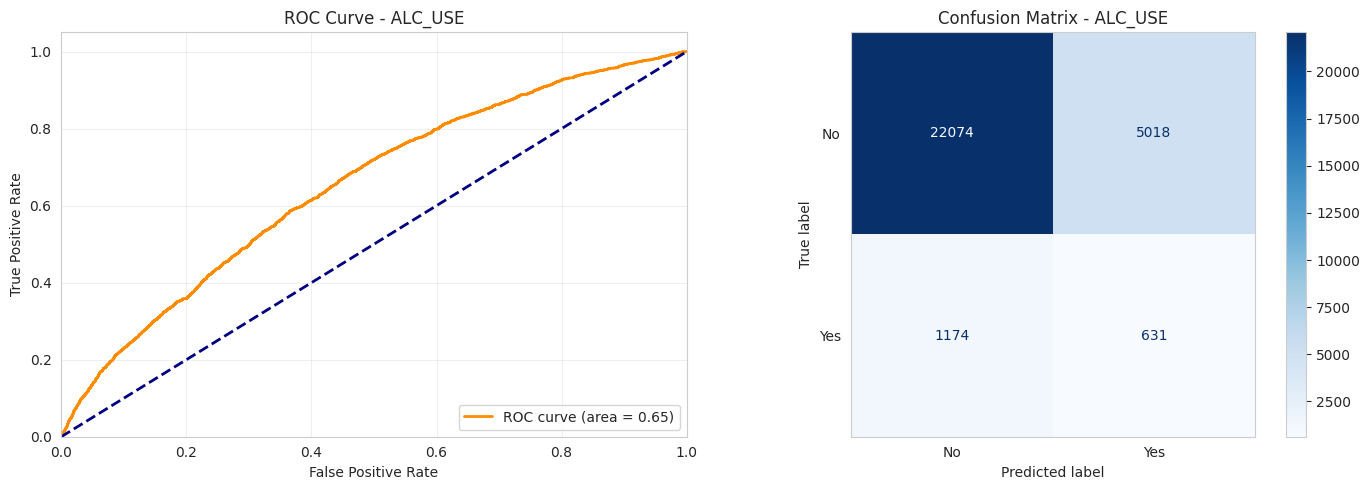


PERFORMANCE REPORT: DRUG_USE
              precision    recall  f1-score   support

           0       0.81      0.59      0.68     20142
           1       0.42      0.68      0.52      8755

    accuracy                           0.62     28897
   macro avg       0.61      0.63      0.60     28897
weighted avg       0.69      0.62      0.63     28897

Test ROC-AUC Score: 0.6873


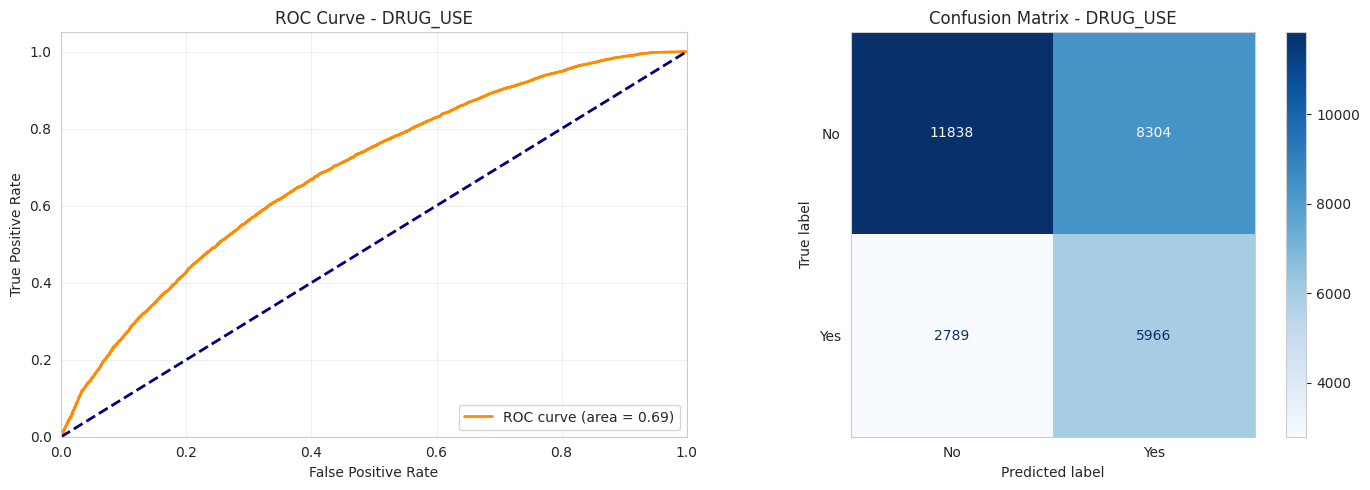


PERFORMANCE REPORT: ALC_&_DRUG_USE
              precision    recall  f1-score   support

           0       0.98      0.59      0.74     27933
           1       0.05      0.68      0.10       964

    accuracy                           0.60     28897
   macro avg       0.52      0.64      0.42     28897
weighted avg       0.95      0.60      0.72     28897

Test ROC-AUC Score: 0.6904


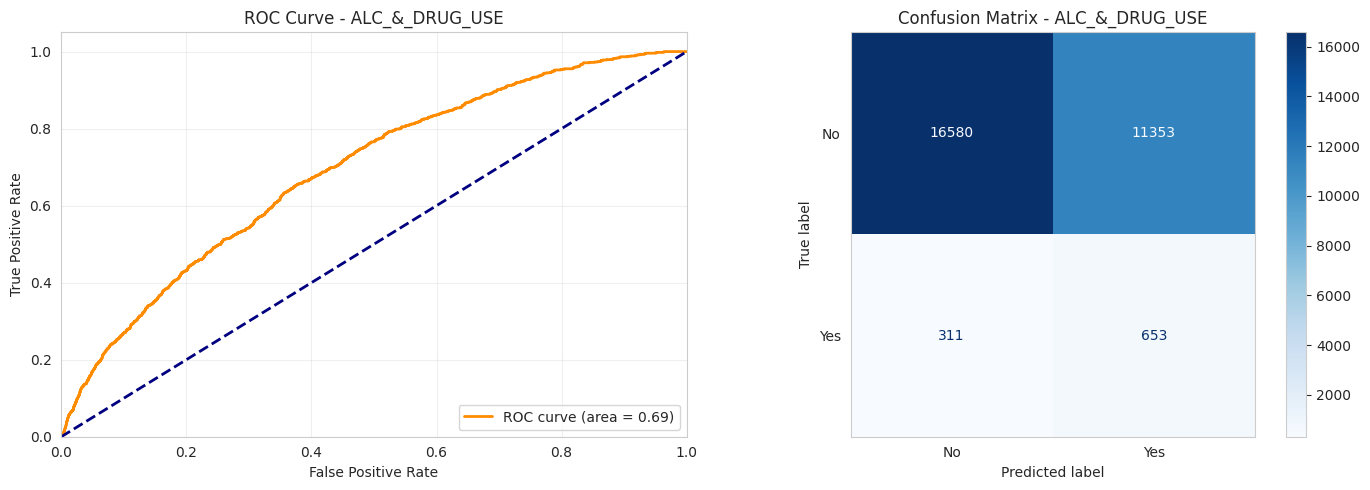

In [10]:
# --- 1. Initialize Model (Optimized) ---
log_reg_multi = MultiOutputClassifier(
    LogisticRegression(
        class_weight='balanced',
        solver='saga',  # Faster for large datasets, supports L1
        penalty='l1',
        C=0.1,
        random_state=42,
        max_iter=500,  # Reduced iterations
        tol=1e-3,      # Relaxed tolerance for faster convergence
        n_jobs=1       # SAGA handles parallelism internally
    ),
    n_jobs=-1  # Parallelize across targets
)

# --- 2. Stratified K-Fold Cross-Validation (Optimized) ---
print("--- Running Stratified K-Fold Cross Validation (5 Folds) ---")

y_train_stratify = y_train.astype(str).agg('-'.join, axis=1)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = []

# Use numpy arrays instead of iloc for faster indexing
X_train_np = X_train.values
y_train_np = y_train.values

for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_train_np, y_train_stratify)):
    X_cv_train, X_cv_val = X_train_np[train_idx], X_train_np[val_idx]
    y_cv_train, y_cv_val = y_train_np[train_idx], y_train_np[val_idx]
    
    log_reg_multi.fit(X_cv_train, y_cv_train)
    
    # Vectorized probability extraction
    y_pred_prob = np.column_stack([
        est.predict_proba(X_cv_val)[:, 1] for est in log_reg_multi.estimators_
    ])
    
    score = roc_auc_score(y_cv_val, y_pred_prob, average='macro')
    cv_scores.append(score)
    print(f"  Fold {fold_idx+1} ROC-AUC (Macro): {score:.4f}")

print(f"\nMean CV ROC-AUC: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")

# --- 3. Final Training ---
print("\n--- Training Final Model on Full Training Set ---")
log_reg_multi.fit(X_train, y_train)

# --- 4. Evaluation ---
y_pred = log_reg_multi.predict(X_test)
y_pred_proba = np.column_stack([
    est.predict_proba(X_test)[:, 1] for est in log_reg_multi.estimators_
])

# --- 5. Metrics & Plots ---
for i, target_name in enumerate(ALL_TARGETS):
    print(f"\n{'='*60}")
    print(f"PERFORMANCE REPORT: {target_name}")
    print(f"{'='*60}")
    
    print(classification_report(y_test.iloc[:, i], y_pred[:, i], zero_division=0))
    print(f"Test ROC-AUC Score: {roc_auc_score(y_test.iloc[:, i], y_pred_proba[:, i]):.4f}")
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test.iloc[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    
    axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_ylim([0.0, 1.05])
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title(f'ROC Curve - {target_name}')
    axes[0].legend(loc="lower right")
    axes[0].grid(True, alpha=0.3)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test.iloc[:, i], y_pred[:, i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
    disp.plot(ax=axes[1], cmap='Blues', values_format='d')
    axes[1].set_title(f'Confusion Matrix - {target_name}')
    axes[1].grid(False)
    
    plt.tight_layout()
    plt.show()

TODO the previous version was taking too long to run, the optimized version lead to not reaching convergence during K-Fold CV. Needs further investigation.

**For testing only**, we replaced the computationally expensive 5-Fold Cross-Validation loop with a simple Hold-Out Validation strategy (fitting once on X_train and evaluating on X_test).

--- Training Model on Training Set (Hold-Out Strategy) ---
Training completed in 74.35 seconds
Generating predictions...

PERFORMANCE REPORT: ALC_USE
              precision    recall  f1-score   support

           0       0.95      0.81      0.88     27092
           1       0.11      0.35      0.17      1805

    accuracy                           0.79     28897
   macro avg       0.53      0.58      0.52     28897
weighted avg       0.90      0.79      0.83     28897

Test ROC-AUC Score: 0.6510


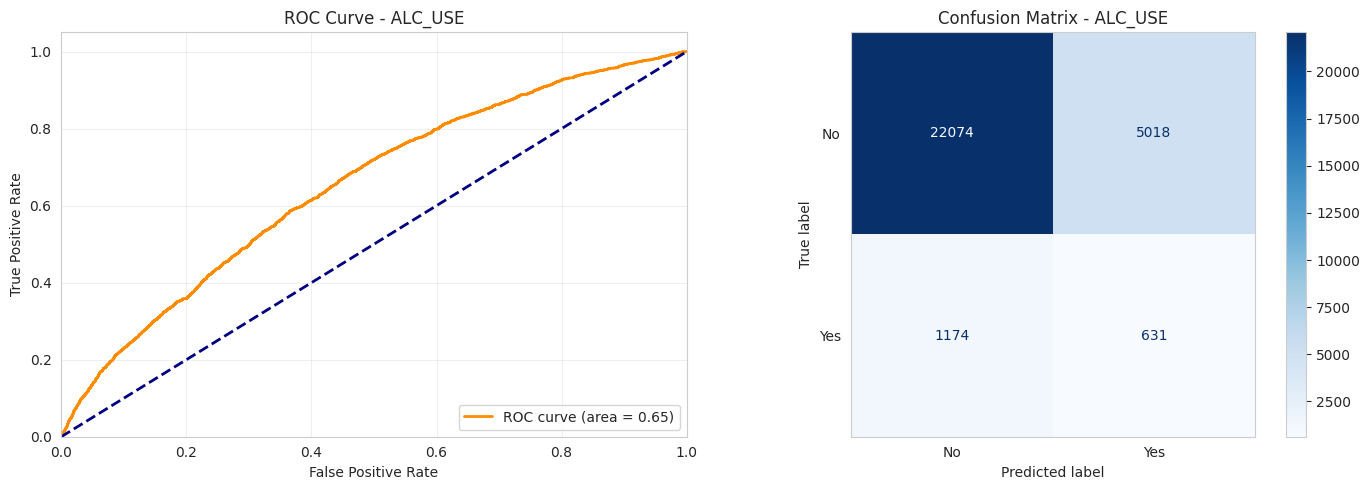


PERFORMANCE REPORT: DRUG_USE
              precision    recall  f1-score   support

           0       0.81      0.59      0.68     20142
           1       0.42      0.68      0.52      8755

    accuracy                           0.62     28897
   macro avg       0.61      0.63      0.60     28897
weighted avg       0.69      0.62      0.63     28897

Test ROC-AUC Score: 0.6873


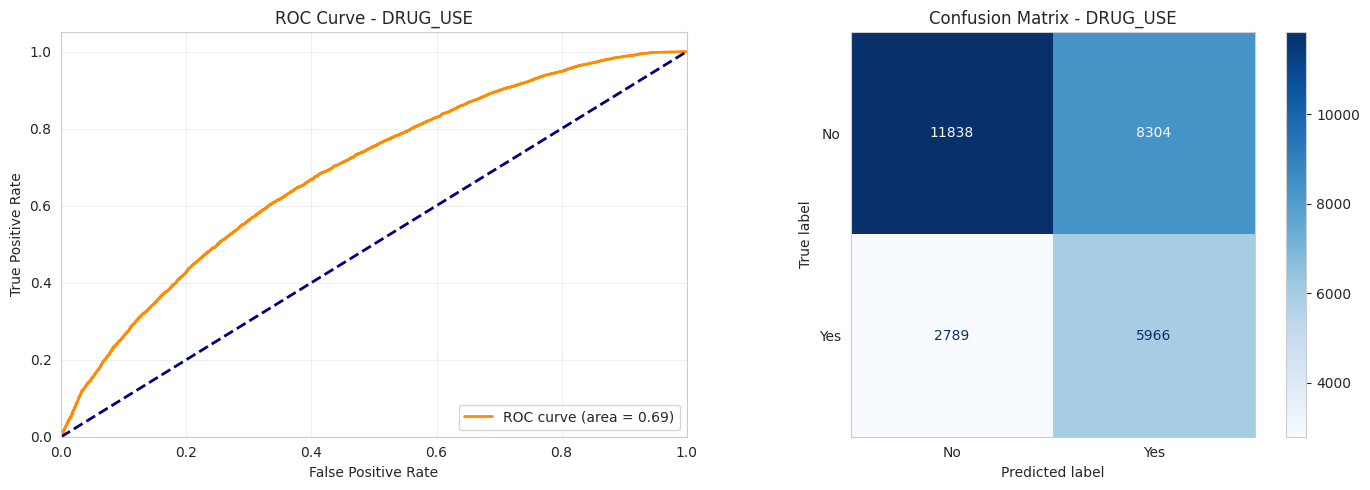


PERFORMANCE REPORT: ALC_&_DRUG_USE
              precision    recall  f1-score   support

           0       0.98      0.59      0.74     27933
           1       0.05      0.68      0.10       964

    accuracy                           0.60     28897
   macro avg       0.52      0.64      0.42     28897
weighted avg       0.95      0.60      0.72     28897

Test ROC-AUC Score: 0.6904


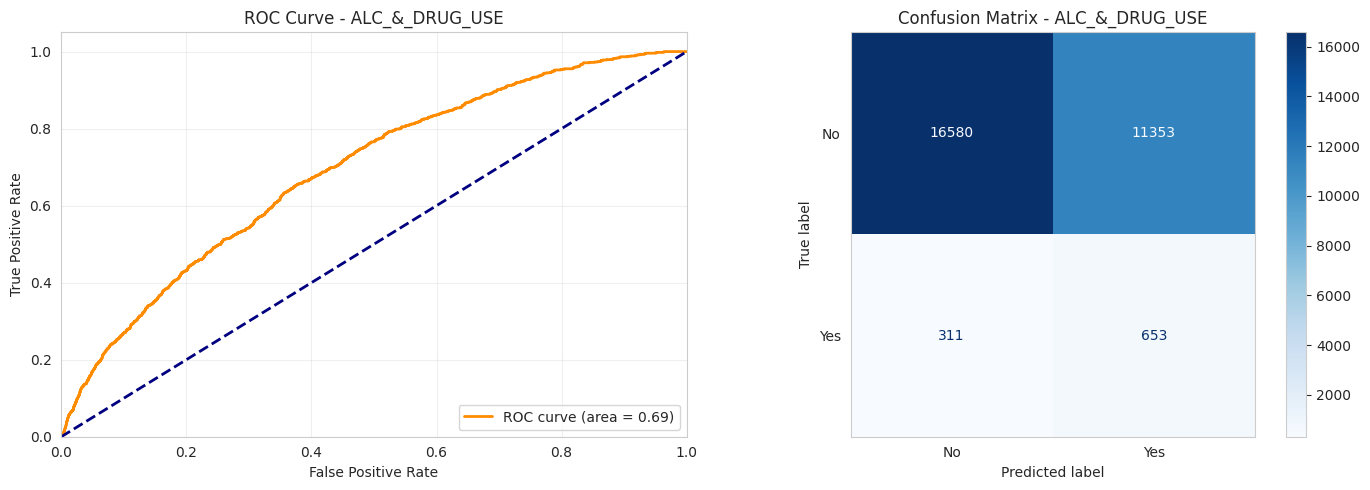

In [9]:
# --- 1. Initialize Model (Optimized Settings) ---
log_reg_multi = MultiOutputClassifier(
    LogisticRegression(
        class_weight='balanced',
        solver='saga',  # SAGA is faster than liblinear for large datasets
        penalty='l1',
        C=0.1,
        random_state=42,
        max_iter=500,  # Reduced from 1000
        tol=1e-3,  # Relaxed convergence tolerance
        warm_start=False,
        n_jobs=1  # SAGA doesn't benefit from parallelization
    ),
    n_jobs=-1  # Parallelize across targets instead
)

# --- 2. Train Model ---
print("--- Training Model on Training Set (Hold-Out Strategy) ---")
start_time = time.time()
log_reg_multi.fit(X_train, y_train)
print(f"Training completed in {time.time() - start_time:.2f} seconds")

# --- 3. Predictions (Vectorized) ---
print("Generating predictions...")
y_pred = log_reg_multi.predict(X_test)
y_pred_proba = np.column_stack([est.predict_proba(X_test)[:, 1] for est in log_reg_multi.estimators_])

# --- 4. Metrics & Plots per Target ---
for i, target_name in enumerate(ALL_TARGETS):
    print(f"\n{'='*60}")
    print(f"PERFORMANCE REPORT: {target_name}")
    print(f"{'='*60}")
    
    # Classification Report
    print(classification_report(y_test.iloc[:, i], y_pred[:, i], zero_division=0))
    print(f"Test ROC-AUC Score: {roc_auc_score(y_test.iloc[:, i], y_pred_proba[:, i]):.4f}")
    
    # Setup Plots
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test.iloc[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    
    axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_ylim([0.0, 1.05])
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title(f'ROC Curve - {target_name}')
    axes[0].legend(loc="lower right")
    axes[0].grid(True, alpha=0.3)
    
    # Plot Confusion Matrix
    cm = confusion_matrix(y_test.iloc[:, i], y_pred[:, i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
    disp.plot(ax=axes[1], cmap='Blues', values_format='d')
    axes[1].set_title(f'Confusion Matrix - {target_name}')
    axes[1].grid(False)
    
    plt.tight_layout()
    plt.show()

TODO : Add Random Forest model training with similar cross-validation and evaluation metrics.